# Stellar Feedback Analysis
This notebook was inherited from Leo's original analysis on SN-heated gas distribution. This notebook consists of 3 main ideas: reading discharged gas data, making distance, velocity, and temperature dependency graphs on gas distribution, and making gas-loss graphs based on infall time. The first half treats one satellite data for analysis, and the second half treats all the satellite data for analysis.

I found out that compare with Leo's results, since I included SN-heated gas rich galaxies more, which are frequently star-forming and have massive stellar/gas mass, the fraction of SN-heated gas discharging is larger, even in closer distance from the center of the satellite. This is the case for PAI based gas loss graph, where the portion of SN-heated gas loss is larger in closer distance b/w sat and host, compared with Leo's result, and yet the fraction of SN-heated gas loss to total gas loss is almost flat across any infalling point.

In [1]:
import pylab
import pynbody
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec
import tqdm


from astropy import units
from astropy import constants as c

import warnings
warnings.filterwarnings("ignore")

from base import *
from compiler import *
from analysis import *

base.py executed
compiler.py executed


In [2]:
# quick check to ensure all selected satellites are accounted for.
path = f'{rootPath}SNe-heated_Gas_Flow/SNeData/discharged_particles.hdf5'
with pd.HDFStore(path) as hdf:
    keys = np.array([h[1:] for h in hdf.keys()])

print(len(keys), 'Available Keys:\n', *keys)

29 Available Keys:
 h148_10 h148_12 h148_2 h148_249 h148_251 h148_27 h148_282 h148_3 h148_34 h148_38 h148_4 h148_55 h148_6 h148_65 h229_14 h229_18 h229_20 h229_22 h229_49 h242_10 h242_21 h242_30 h242_38 h242_401 h242_69 h242_8 h329_117 h329_29 h329_7


# Single Data Table
Before moving onto the analysis, it is always helpful to sort the data in order and check variables.
These lines are simple function and code that can create a table that lists all the satellite data at the last snapshot.

In [4]:
def read_file(simname):
    '''
    A function that returns the compiled .data file for the given simname (one of 'h148', 'h229', 'h242', or 'h329'). 
    '''
    data = []
    with open(rootPath + 'Justice_League_Code/Data/timesteps_data/' + simname + '.data', 'rb') as f:
        while True:
            try:
                data.append(pickle.load(f,encoding='latin1'))
            except EOFError:
                break

        data1 = pd.DataFrame(data)
        data1['sim'] = [simname]*len(data1)
        #data1['g-r'] = 1.646*(data1['V_mag'] - data1['R_mag']) - 0.139
        
        return data1

In [7]:
import math #used for isin
#generate tables of sim satellites
data = pd.DataFrame()

data = read_file('h148')
data = data.append(read_file('h229'))
data = data.append(read_file('h242'))
data = data.append(read_file('h329'))


data['haloid'] = data['haloid'].astype(int)
data['key'] = data['sim'] + '_' + data['haloid'].astype(str)
data['Hdist'] = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2)

data = data[['key','time','mstar','mgas','mass','Rvir','x','y','z', 'Hdist', 'sfr']]
data = data.loc[data['key'].isin(keys)] #look at only sim data used
data = data.loc[(data['time'] < 14) & (data['time'] > 13.7)] #only include present day

data.to_csv('all-satellite-data.csv', index=False)
pd.read_csv('all-satellite-data.csv')

key       time         mstar          mgas          mass       Rvir  \
0     h148_2  13.800797  2.268773e+09  8.252345e+09  9.575866e+10  95.146148   
1     h148_3  13.800797  1.502171e+09  2.975036e+09  4.697010e+10  76.051992   
2     h148_4  13.800797  4.317847e+08  9.706413e+08  3.248971e+10  67.257466   
3     h148_6  13.800797  3.315968e+08  1.010160e+09  2.869601e+10  64.527622   
4    h148_10  13.800797  1.353274e+08  1.139460e+09  1.055766e+10  46.245041   
5    h148_12  13.800797  1.043767e+08  7.503453e+06  9.071870e+09  43.957874   
6    h148_27  13.800797  8.415728e+07  1.026774e+08  3.249352e+09  31.223519   
7    h148_34  13.800797  5.759679e+06  5.869542e+07  2.628660e+09  29.083911   
8    h148_38  13.800797  1.374093e+07  0.000000e+00  1.883522e+09  26.029436   
9    h148_55  13.800797  2.822993e+06  5.263210e+06  1.361924e+09  23.373371   
10   h148_65  13.800797  3.001293e+07  0.000000e+00  8.996108e+08  20.348408   
11  h148_251  13.800797  2.149496e+06  0.000000e+00  1.815621e+08  11.937536   
12  h148_249  13.800797  2.063790e+06  0.000000e+00  1.861386e+08  12.070339   
13  h148_282  13.800797  3.984286e+06  0.000000e+00  1.495318e+08  11.199740   
14   h229_14  13.800797  3.338275e+06  2.703543e+07  2.403511e+09  28.228068   
15   h229_18  13.800797  7.714878e+07  0.000000e+00  1.509991e+09  24.184947   
16   h229_20  13.800797  8.610682e+05  6.519790e+05  2.025912e+09  26.663941   
17   h229_22  13.800797  4.786508e+06  0.000000e+00  1.551642e+09  24.406285   
18   h229_49  13.800797  6.790767e+06  0.000000e+00  7.641975e+08  19.285983   
19    h242_8  13.800797  8.002777e+08  1.114763e+09  1.194735e+10  48.192822   
20   h242_10  13.800797  7.955202e+08  5.163923e+08  9.255528e+09  37.834169   
21   h242_21  13.800797  1.365987e+07  0.000000e+00  4.014776e+09  33.495930   
22   h242_30  13.800797  3.872857e+06  0.000000e+00  2.768428e+09  29.615124   
23   h242_38  13.800797  1.833826e+06  0.000000e+00  1.976432e+09  26.457358   
24   h242_69  13.800797  2.351661e+07  1.342686e+07  8.650895e+08  20.082802   
25  h242_401  13.800797  7.590571e+06  0.000000e+00  8.278025e+07   9.207692   
26    h329_7  13.800797  2.747402e+07  2.476791e+08  5.129210e+09  32.507283   
27   h329_29  13.800797  1.491121e+06  0.000000e+00  1.403478e+09  23.609466   
28  h329_117  13.800797  3.084173e+06  0.000000e+00  2.398850e+08  13.103254   

             x           y           z       Hdist       sfr  
0    -3.128655  484.000000 -141.145879  504.170554  0.476290  
1   207.196879  197.000000  -55.850550  291.305391  0.098870  
2   139.893318   54.000000  -86.350237  173.039024  0.025735  
3   299.101876   74.000000  115.614250  329.096623  0.037392  
4    21.186472   32.000000  -47.891312   61.371365  0.022669  
5   -52.348853   16.000000  114.143760  126.590680  0.000137  
6   175.981794    1.000000  173.993626  247.476006  0.000535  
7  -176.110608  235.000000   63.534840  300.460683  0.000000  
8   -13.254242   29.980248  185.272730  188.150138  0.000000  
9   -72.292718   44.000000  -34.724669   91.476990  0.000000  
10   -6.338927   43.515903 -109.608287  118.100772  0.000000  
11  184.780480   22.454225  229.726349  295.672477  0.000000  
12  -31.920348 -169.583192   61.704666  183.261653  0.000000  
13   63.915278 -169.634410    8.127366  181.458121  0.000000  
14  158.327707  175.000000  198.869114  308.612357  0.000000  
15    6.874170  -49.039491  128.480495  137.693005  0.000000  
16  -65.512496  264.077655  -13.798546  272.432184  0.000000  
17  -15.438021  110.306651 -194.636142  224.252352  0.000000  
18   39.261319  -69.717659  -75.543153  110.039862  0.000000  
19  -75.576339   30.000000  -36.990680   89.331368  0.034354  
20   -1.999205  157.000000  -36.146373  161.119698  0.009396  
21  124.175898  -25.172507  180.089826  220.194582  0.000000  
22   46.863181  375.090693 -234.846908  445.019388  0.000000  
23  -81.658794  -81.952902  230.789237  258.162950  0.000000  
24   60.303360  183.000000 -103.6

# Particle Tracking
Here's for tracking particles in one satellite

In [7]:
#if you want to read in particle data in one single satellite
#read
key = 'h148_10'
data = pd.read_hdf(path, key=key)

data.head()
#data.count()

time      pid        rho          temp          mass  \
1608913  12.938837   936805   0.029028  10118.519531  26612.024429   
1342436  12.076876  1336093   0.010847  10729.565430  27209.291738   
1697121  13.369817  1336093   0.075779   9359.319336  27332.201291   
1431374  12.150951  1352518   0.074848   9714.401367  31133.795216   
1520259  12.507856  2173227  12.033213  75236.117188  26610.867333   

         coolontime         r  r_per_Rvir         x         y  ...  \
1608913   12.754997  4.882481    0.102766 -2.607572  0.112852  ...   
1342436    2.053747  3.202479    0.067591  2.241762 -1.967134  ...   
1697121    2.053747  2.226131    0.047559  0.446497  1.933998  ...   
1431374    1.039431  3.507150    0.073944  2.783728  2.129702  ...   
1520259   12.510046  1.916669    0.040271  1.398115  0.671104  ...   

         host_r_gal  sat_disk  sat_halo  host_disk  host_halo  other_sat  \
1608913   17.456248     False      True      False      False      False   
1342436   19.769437     False      True      False      False      False   
1697121   16.237911     False      True      False      False      False   
1431374   19.815729     False      True      False      False      False   
1520259   18.573006     False      True      False      False      False   

           IGM      sat_Mvir      angle  snHeated  
1608913  False  1.215825e+10  75.283740      True  
1342436  False  1.292568e+10  66.424646     False  
1697121  False  1.125820e+10  57.979727     False  
1431374  False  1.288683e+10  78.808141     False  
1520259  False  1.263197e+10  59.673742      True  

[5 rows x 63 columns]

In [8]:
np.sort(data['time'].unique())

array([ 6.90511141,  7.03979278,  7.33609179,  7.76707217,  8.19805255,
        8.60883073,  9.06001331,  9.49099369,  9.92197407, 10.35295445,
       10.76709966, 10.78393483, 11.21491521, 11.6458956 , 12.07687598,
       12.15095073, 12.50785636, 12.93883674, 13.36981712, 13.8007975 ])

In [9]:
np.diff(np.sort(data['time'].unique()))

array([0.13468137, 0.29629901, 0.43098038, 0.43098038, 0.41077818,
       0.45118259, 0.43098038, 0.43098038, 0.43098038, 0.41414521,
       0.01683517, 0.43098038, 0.43098038, 0.43098038, 0.07407475,
       0.35690563, 0.43098038, 0.43098038, 0.43098038])

In [9]:
def read_one_discharged(key):
    '''
    -> Reads predischarged, discharged, accreted, and hot_predischarged into workable dataframes.
        Only run for one sat.
    '''
    #--------------------------------#
    
    predischarged = pd.DataFrame()
    discharged = pd.DataFrame()
    hot_predischarged= pd.DataFrame()
    
    sim = key[:4]
    haloid = int(key[5:])
    predischarged1 = pd.read_hdf(f'{rootPath}SNe-heated_Gas_Flow/SNeData/predischarged_particles.hdf5', key=key)
    predischarged1['key'] = key
    predischarged = pd.concat([predischarged, predischarged1])

    discharged1 = pd.read_hdf(f'{rootPath}SNe-heated_Gas_Flow/SNeData/discharged_particles.hdf5', key=key)
    discharged1['key'] = key
    discharged = pd.concat([discharged, discharged1])

    hot_predischarged1 = pd.read_hdf(f'{rootPath}SNe-heated_Gas_Flow/SNeData/hot_predischarged_particles.hdf5', key=key)
    hot_predischarged1['key'] = key
    hot_predischarged = pd.concat([hot_predischarged, hot_predischarged1])
       
    print(f'> Returning (predischarged, discharged, hot_predischarged) for satellite {key} <')
    return predischarged, discharged, hot_predischarged

In [10]:
def read_one_sngas(key):
    '''
    -> Reads one gas particles in selected satellites ever SN-heated (irrespective of whether or not
        they were discharged.
    '''
    #--------------------------------#
    
    snone = pd.DataFrame()

    sim = key[:4]
    haloid = int(key[5:])
    snone1 = pd.read_hdf(f'{rootPath}SNe-heated_Gas_Flow/SNeData/sngas_particles.hdf5',
                           key=key)
    snone1['key'] = key
    snone = pd.concat([snone, snone1])

    print(f'> Returning (SN-heated gas) for satellite {key} <')
    return snone

In [16]:
# importing data from h148_10
key = 'h148_10'
predischarged, discharged, hot_predischarged = read_one_discharged(key)

# gas SN-heated/unheated prior to discharge.
hot = discharged[discharged['snHeated']==True]  # heated.
cold = discharged[discharged['snHeated']==False]  # unheated.

sngas = read_one_sngas(key)  # all SN-heated

> Returning (predischarged, discharged, hot_predischarged) for satellite h148_10 <
> Returning (SN-heated gas) for satellite h148_10 <


In [26]:
snapshots = np.round(np.sort(predischarged['time'].unique())*4096/13.8)
for snap in snapshots:
    

array([1922., 2050., 2089., 2177., 2305., 2433., 2555., 2689., 2817.,
       2945., 3073., 3196., 3201., 3329., 3457., 3585., 3607., 3712.,
       3840., 3968.])

# Plotting Functions

In [7]:
# quick calc. for ubiquitous weights in plotting.
@pynbody.derived_array
def wt(*gas):
    if len(gas) == 1:
        return np.array(gas[0]['mass'] / gas[0]['mass'].sum())
    
    else:
        return np.array(gas[0]['mass'] / gas[1]['mass'].sum())

> Returning (predischarged, discharged, hot_predischarged) for satellite h242_10 <
Loaded: h242_10
> Returning (predischarged, discharged, hot_predischarged) for satellite h242_21 <
Loaded: h242_21
> Returning (predischarged, discharged, hot_predischarged) for satellite h242_30 <
Loaded: h242_30
> Returning (predischarged, discharged, hot_predischarged) for satellite h242_38 <
Loaded: h242_38
> Returning (predischarged, discharged, hot_predischarged) for satellite h242_401 <
Loaded: h242_401
> Returning (predischarged, discharged, hot_predischarged) for satellite h242_69 <
Loaded: h242_69
> Returning (predischarged, discharged, hot_predischarged) for satellite h242_8 <
Loaded: h242_8
> Returning (predischarged, discharged, hot_predischarged) for satellite h329_117 <
Loaded: h329_117
> Returning (predischarged, discharged, hot_predischarged) for satellite h329_29 <
Loaded: h329_29
> Returning (predischarged, discharged, hot_predischarged) for satellite h329_7 <
Loaded: h329_7


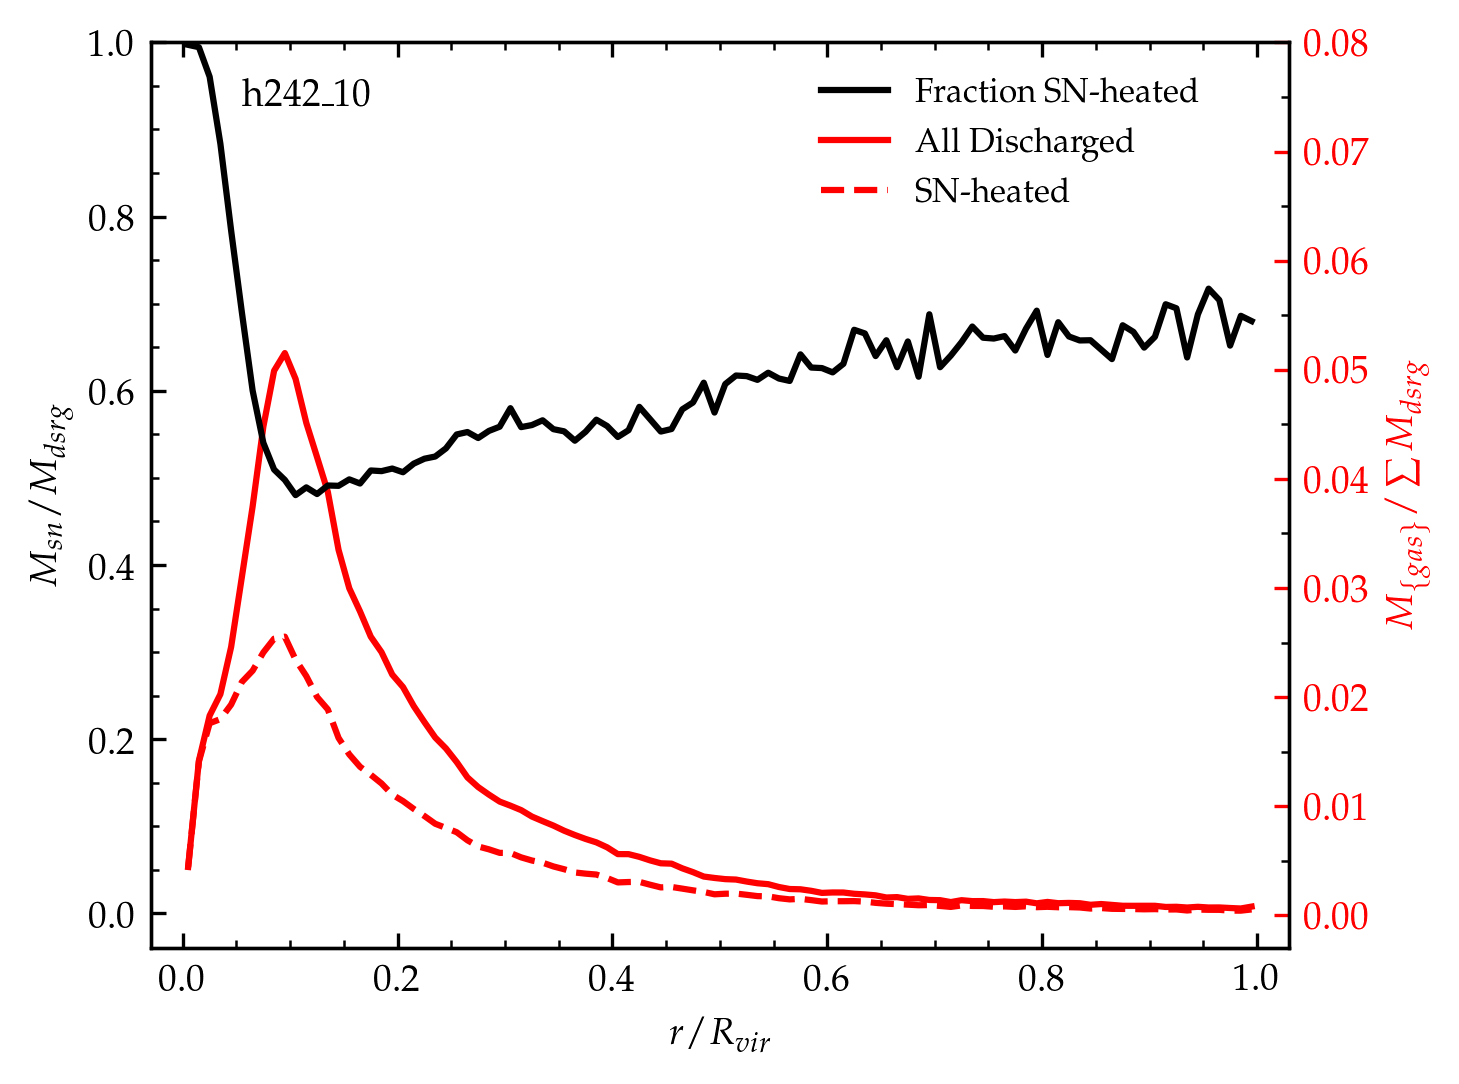

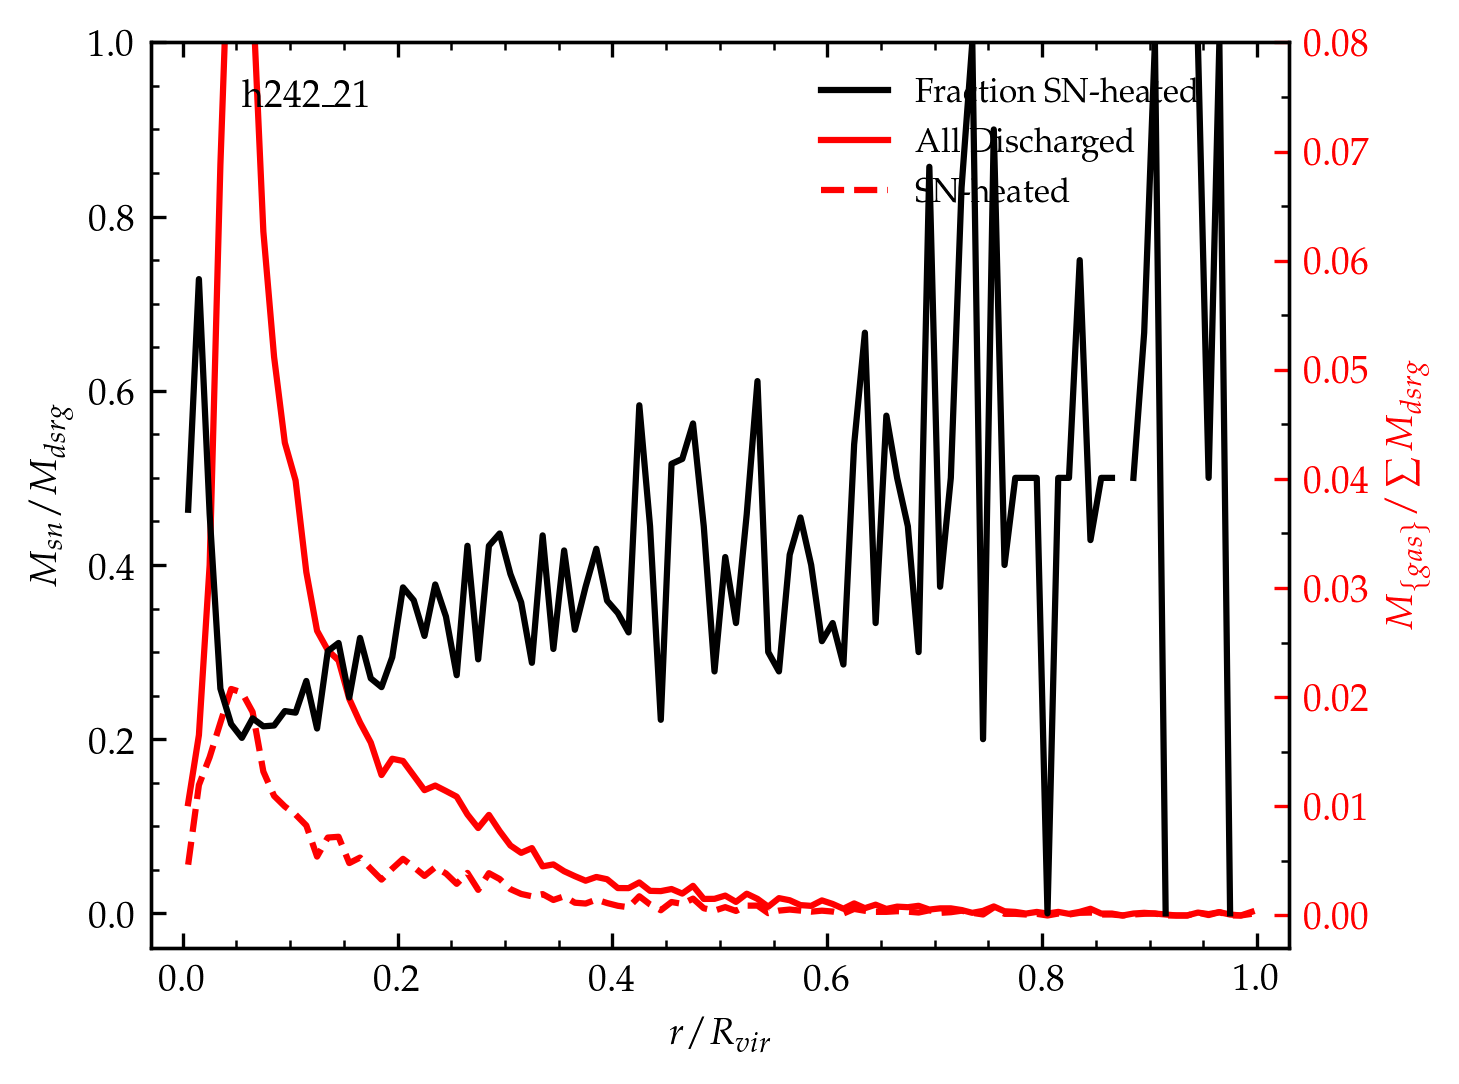

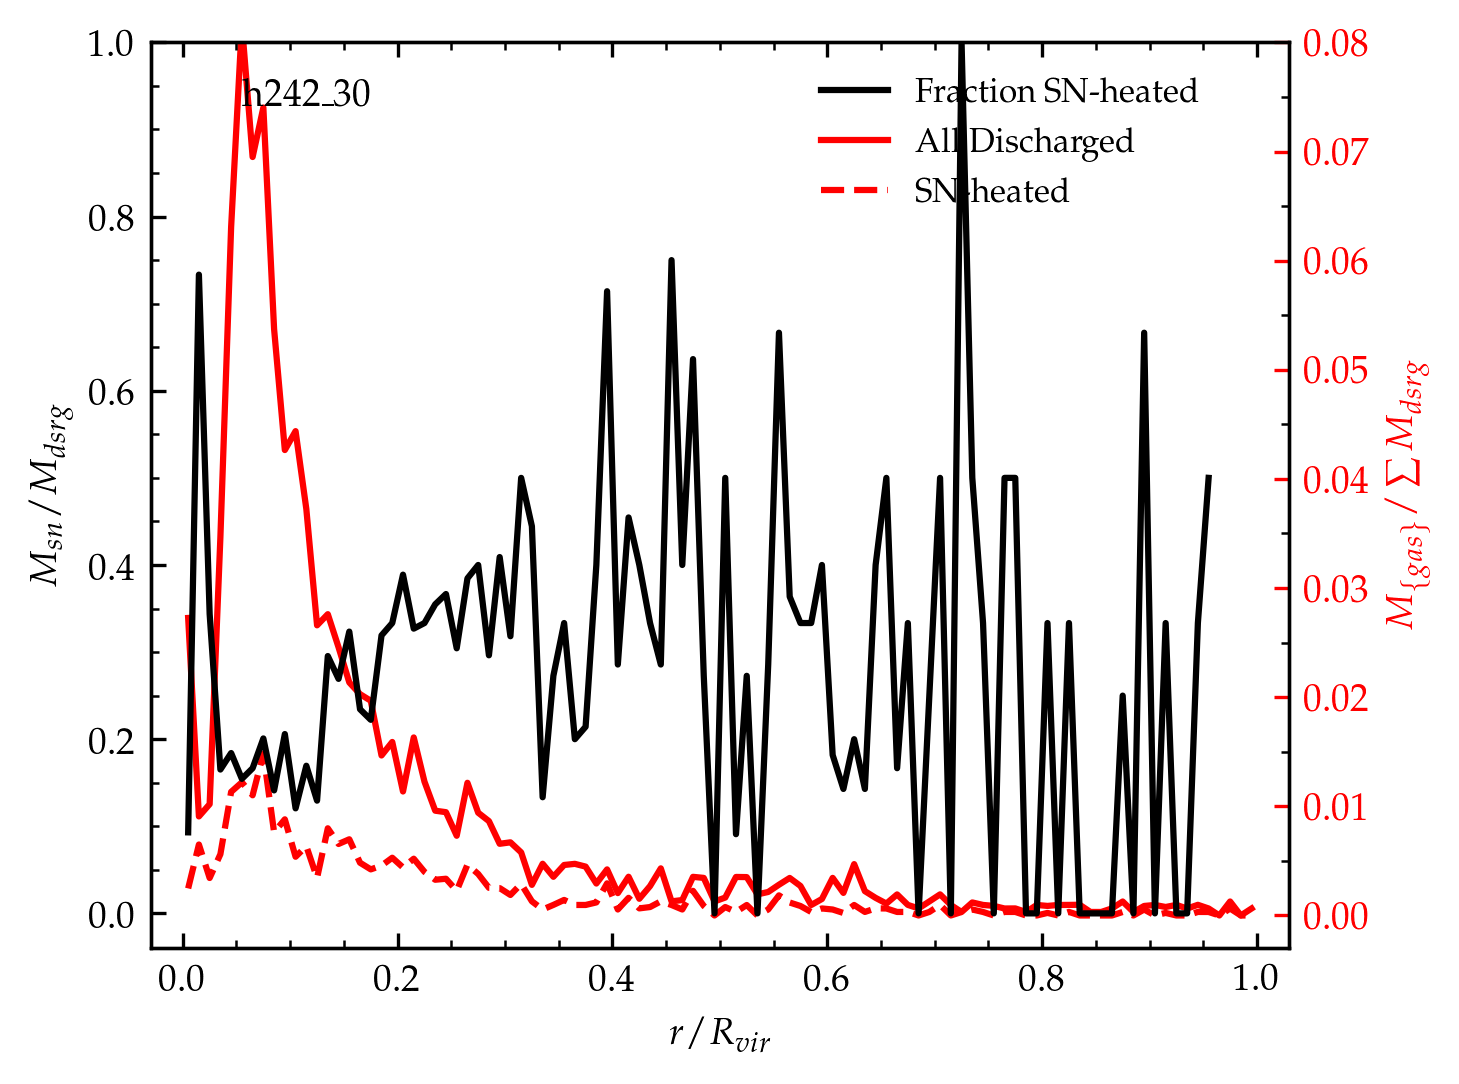

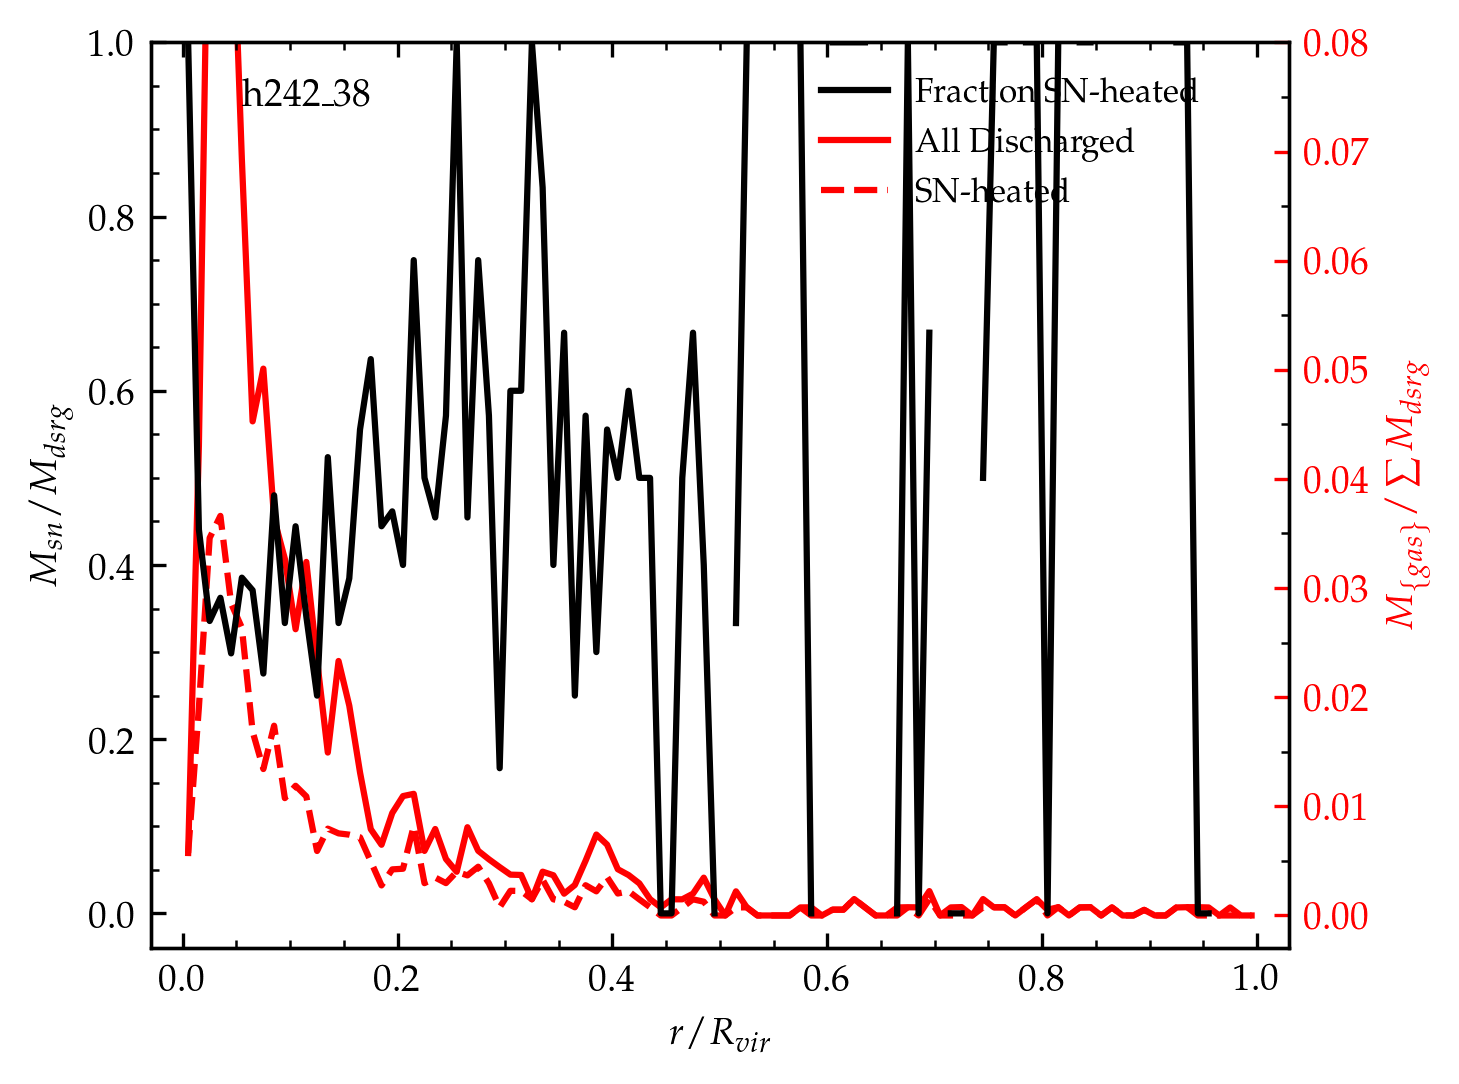

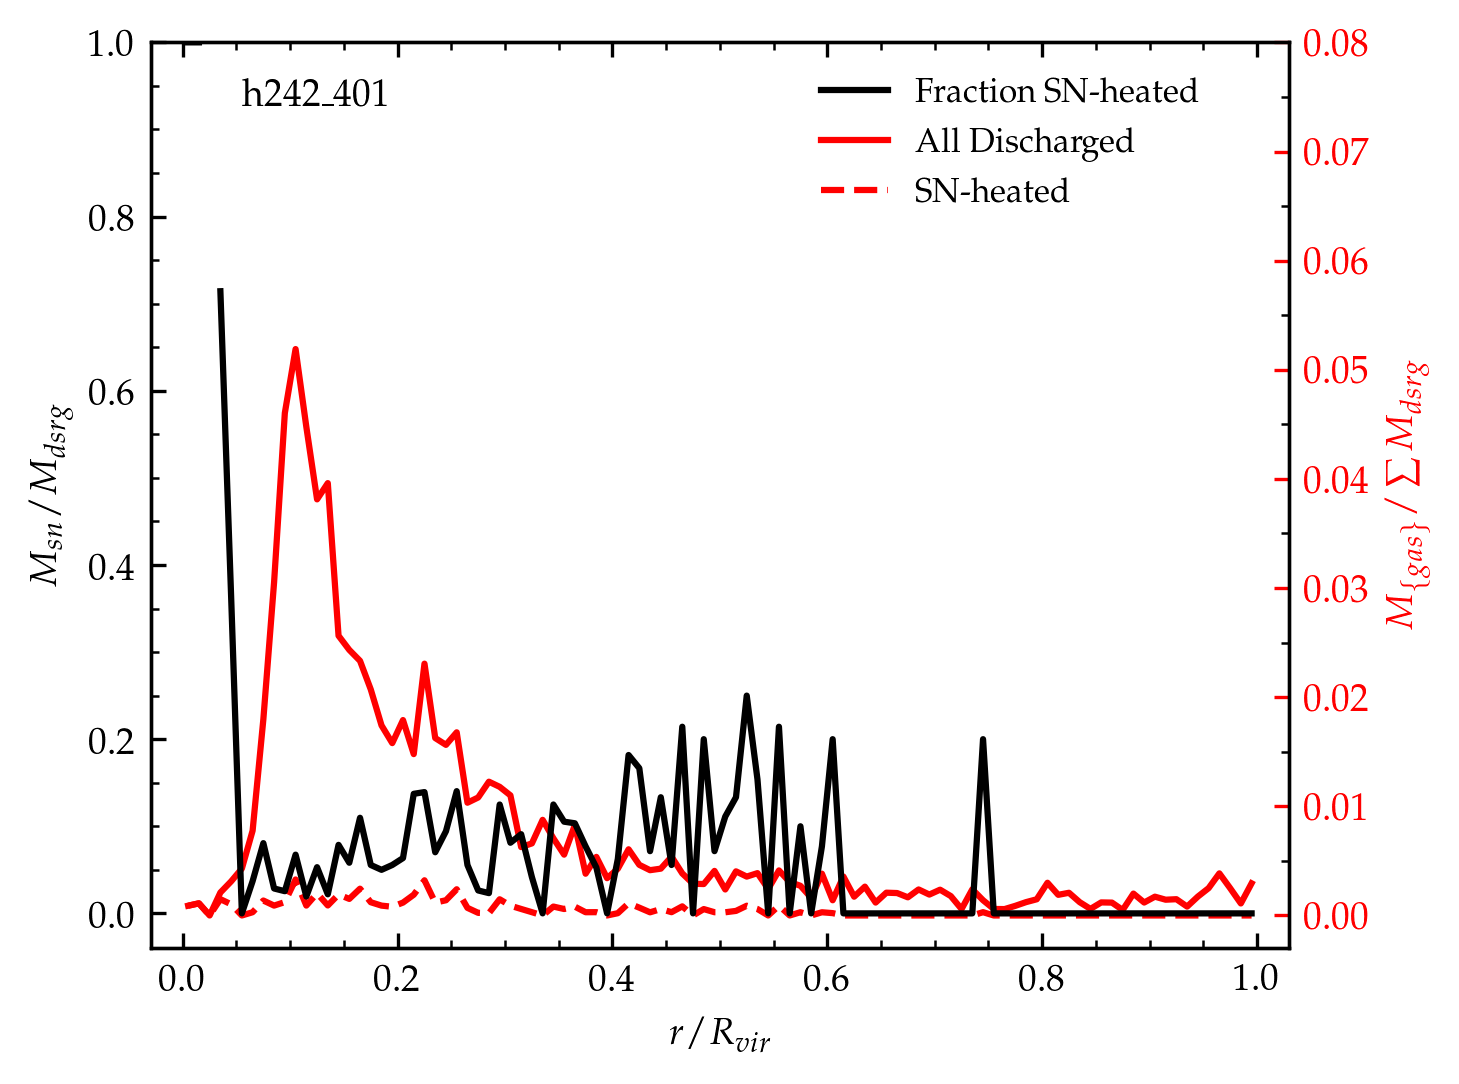

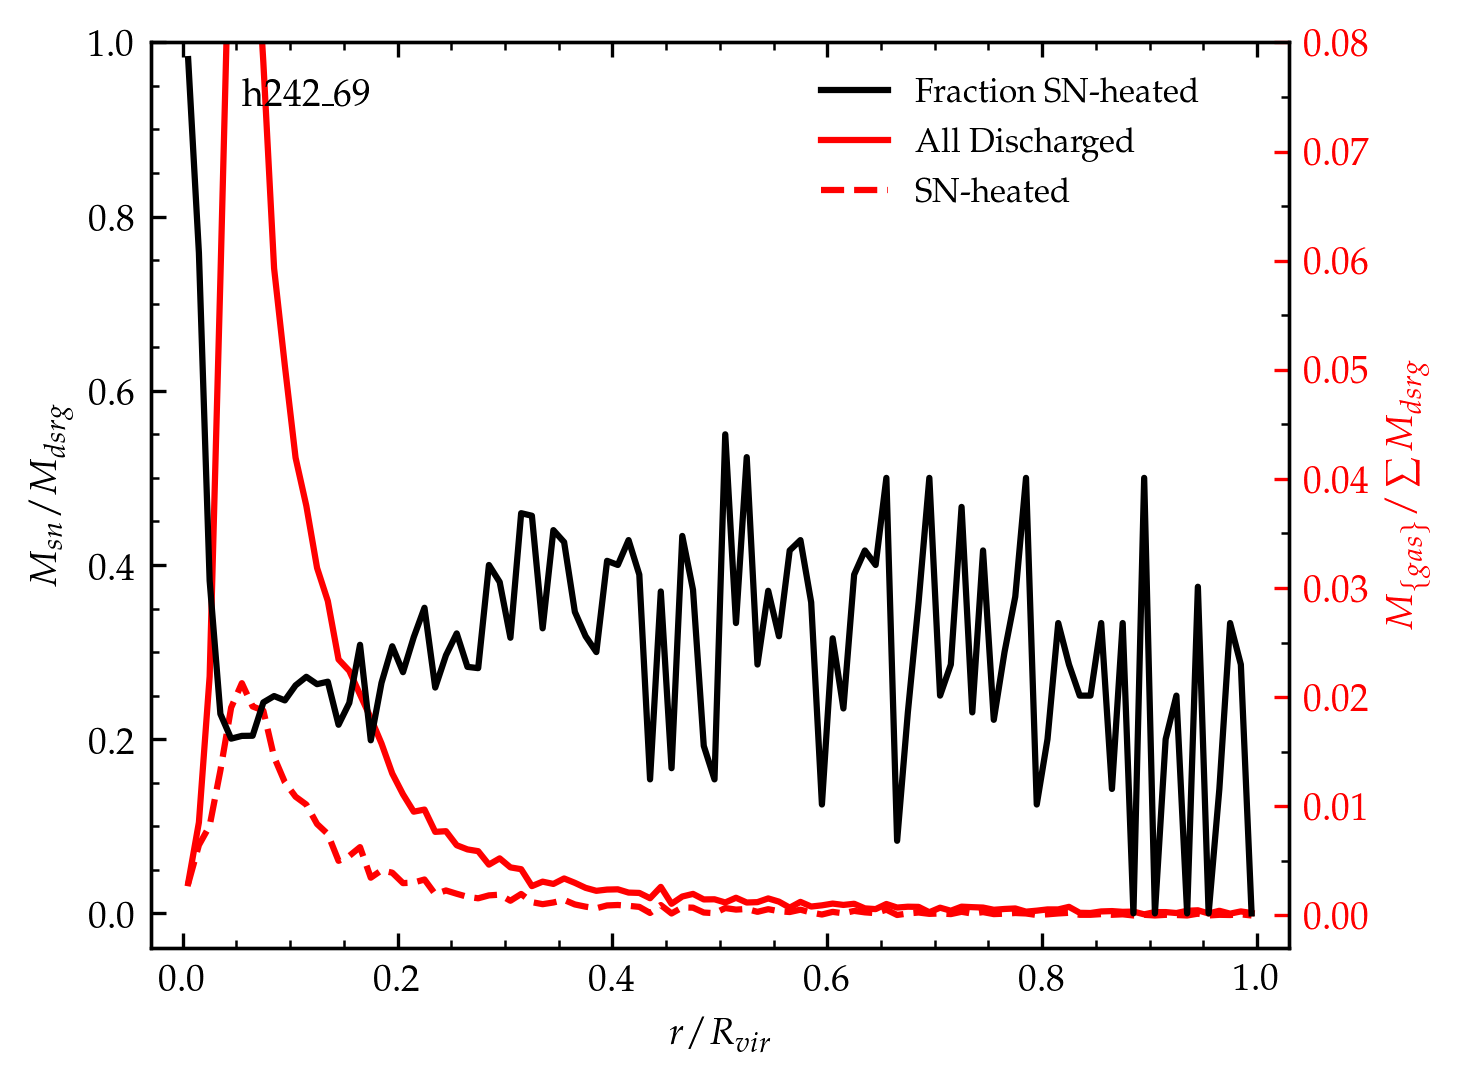

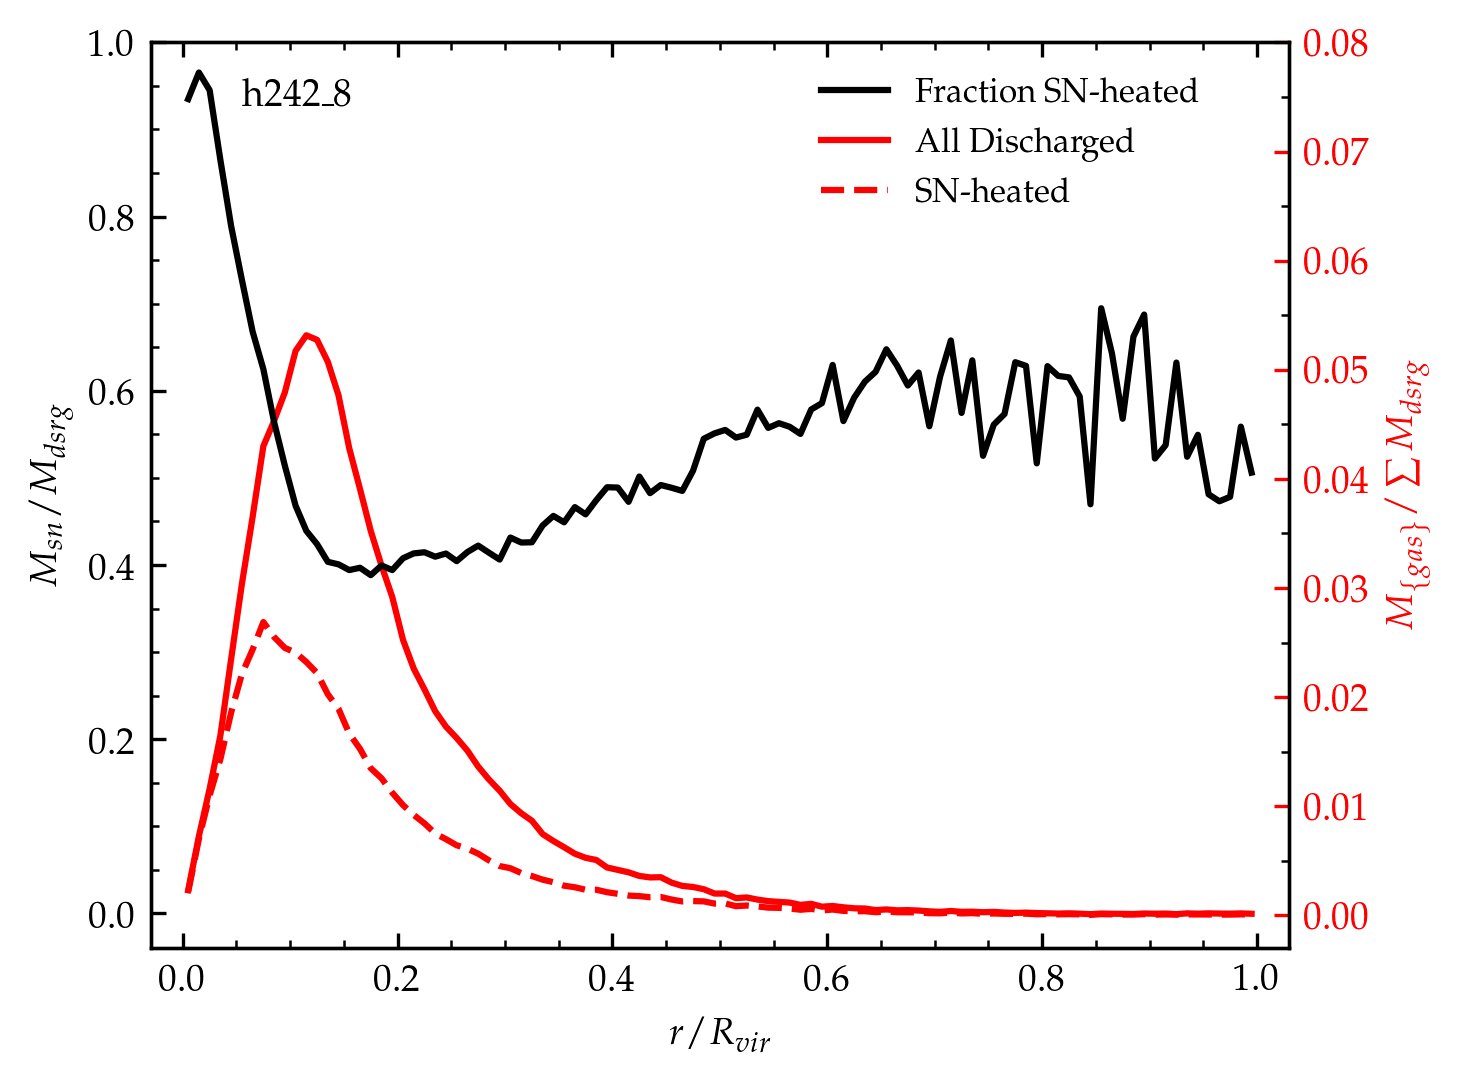

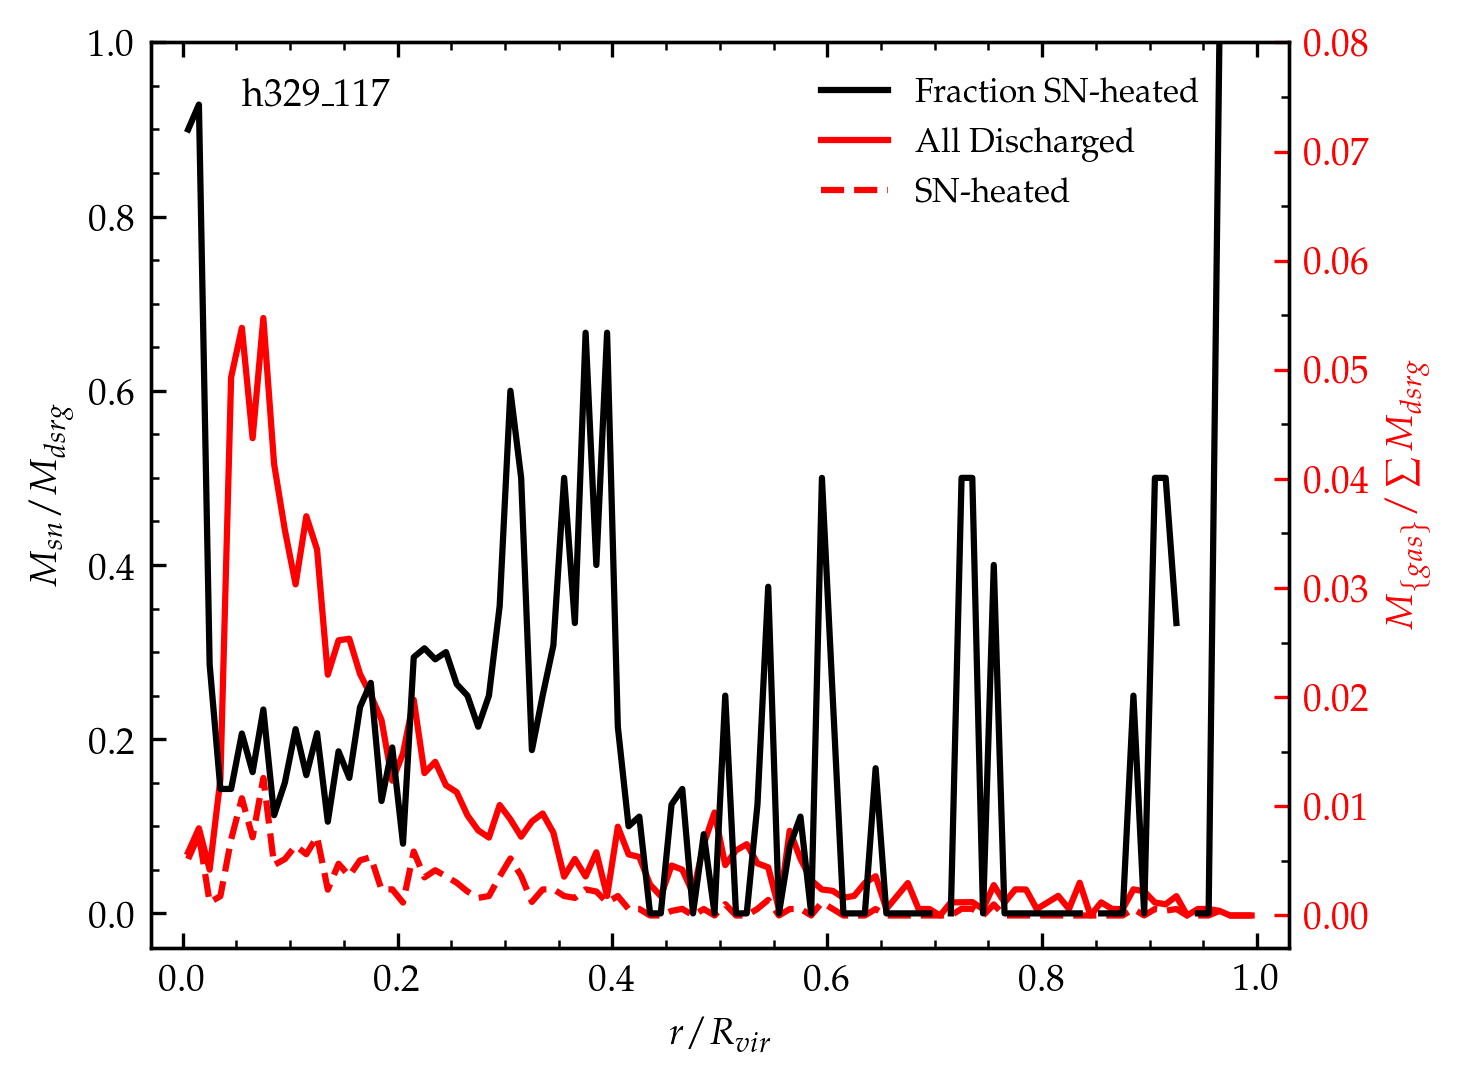

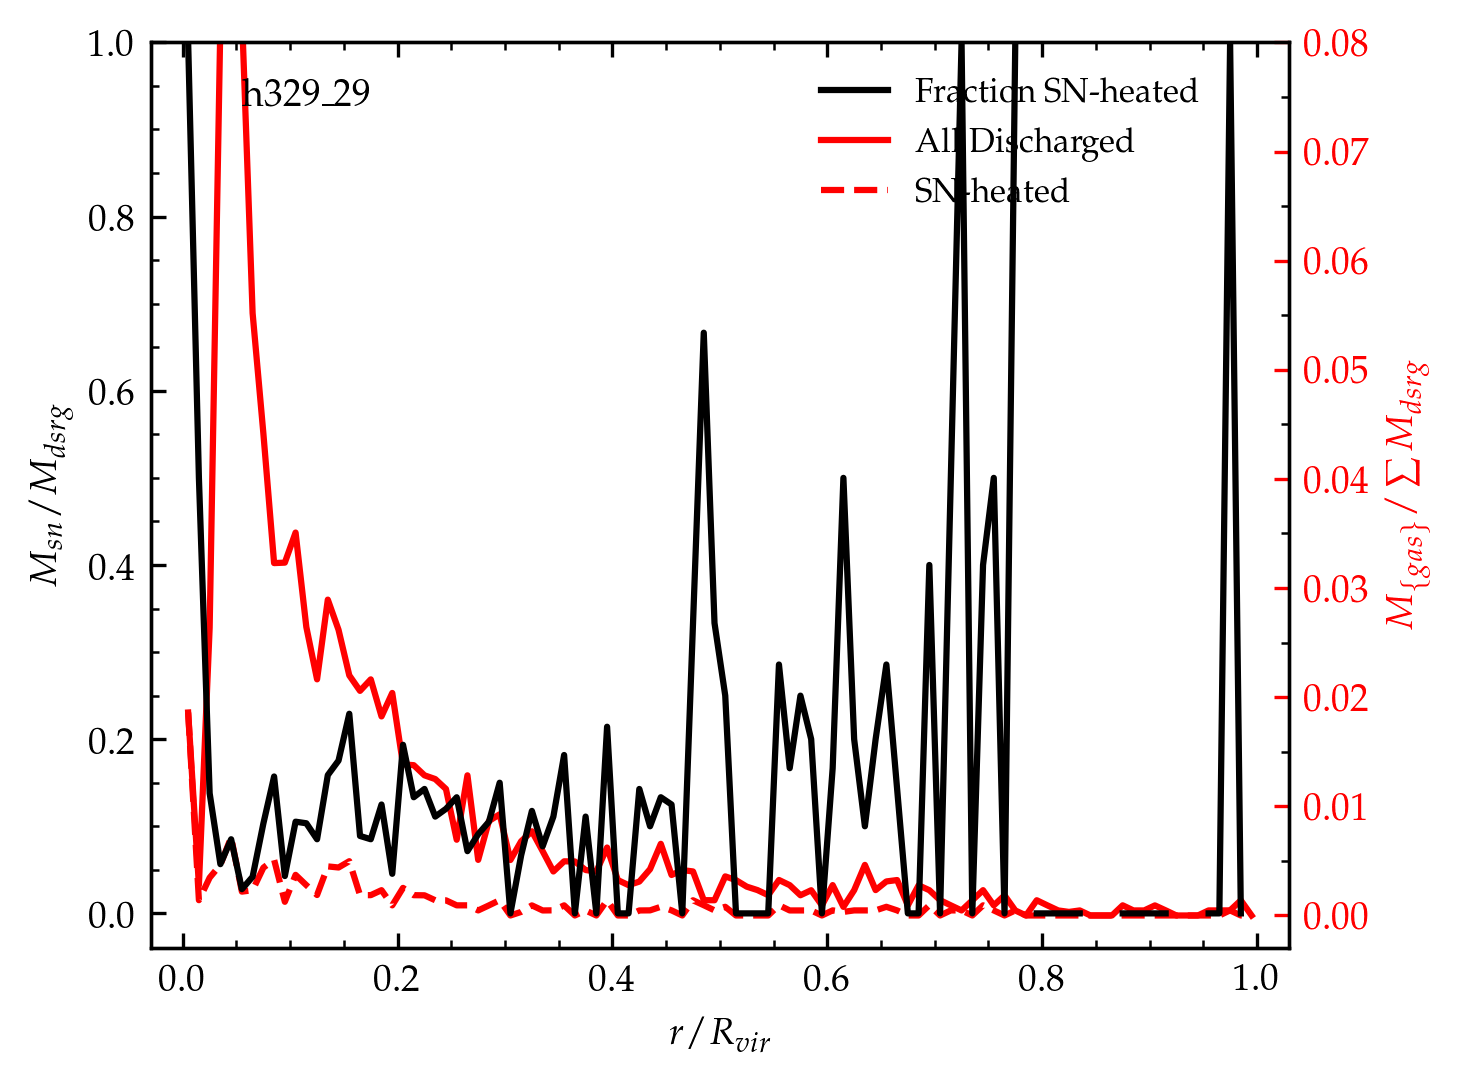

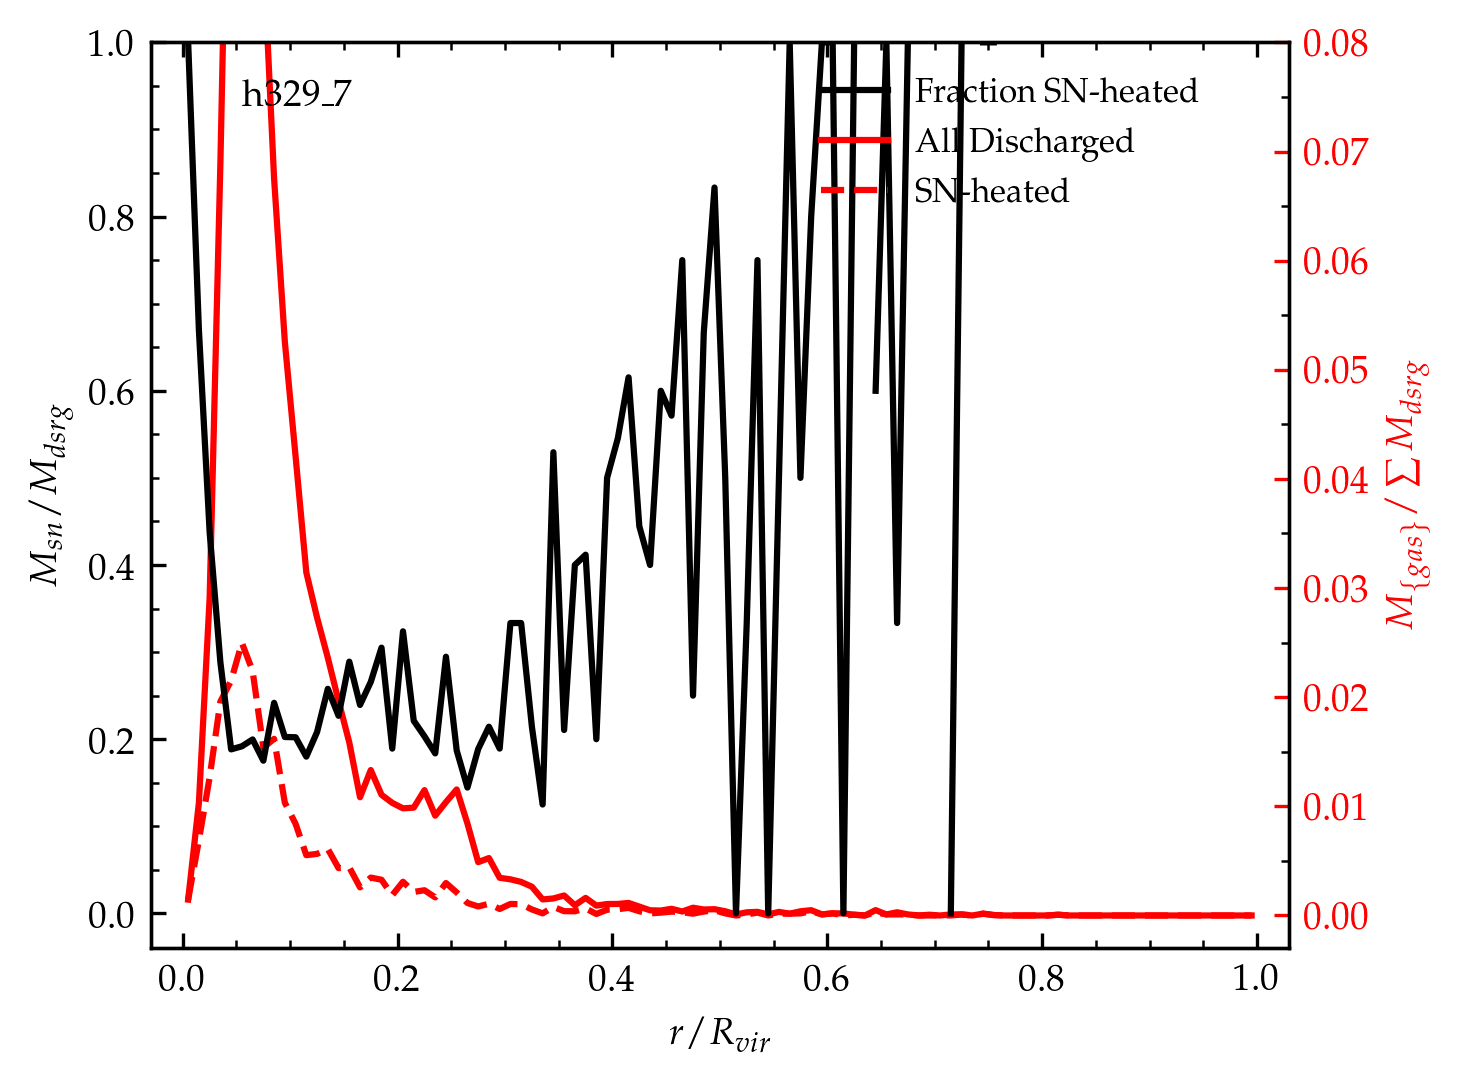

In [11]:
### Code for plotting all satellites below ###

for key in keys:
    
    # Skip the ones I already have
    exclude = ['h148_10', 'h148_12', 'h148_249', 'h148_251', 'h148_27', 'h148_282', 'h148_3', 'h148_34',
               'h148_38', 'h148_4', 'h148_55','h148_6', 'h148_65', 'h229_14', 'h229_18', 'h229_20',
               'h229_22', 'h229_49']
    if key in exclude:
        continue
    
    predischarged, discharged, hot_predischarged = read_one_discharged(key)
    # gas SN-heated/unheated prior to discharge.
    hot = discharged[discharged['snHeated']==True]  # heated.
    cold = discharged[discharged['snHeated']==False]  # unheated.
    print('Loaded:', key)
    
### Code for plotting all satellites above ###

    bins = 100
    rangemax = 1.0

    # assigning particles in each set to equal sets of bins.

    # all discharged gas.
    post, x = np.histogram(discharged.r_per_Rvir, bins=bins, range=(0,rangemax))

    # SN-heated, discharged.
    postHot, x = np.histogram(hot.r_per_Rvir, bins=bins, range=(0,rangemax))


    # computing fraction heated/all at each radial position.
    sn_ratio = np.array([])

    for i in range(0, bins):
        ratio = postHot[i]/post[i]
        sn_ratio = np.append(sn_ratio, ratio)
        i += 1


    ### plotting fractions heated/discharged for different r/Rvir bins ###
    # ax1 = plot of heated/discharged ratios;
    # ax2 = plot for percent mass of discharged and SN-heated, discharged gas, respectively, 
    # at different r/Rvir.
    fig, ax1 = plt.subplots(1, 1, dpi=300, figsize=(4.75,3.5), constrained_layout=True)
    ax2 = ax1.twinx()

    # fraction sne/all:
    bincenters = 0.5*(x[1:] + x[:-1])
    ax1.plot(bincenters, sn_ratio, label='Fraction SN-heated', c='black')

    # mass distributions:
    y1, x = np.histogram(discharged.r_per_Rvir, bins=bins, weights=wt(discharged),
                        range=(0,rangemax))
    bincenters = 0.5*(x[1:] + x[:-1])
    ax2.plot(bincenters, y1, label='All Discharged', c='red')

    y1, x = np.histogram(hot.r_per_Rvir, bins=bins, weights=wt(hot,discharged),
                        range=(0,rangemax))
    bincenters = 0.5*(x[1:] + x[:-1])
    ax2.plot(bincenters, y1, label='SN-heated', c='red', linestyle='--')


    # ax1.set_title('Fraction of Discharged Gas SN-heated over Radial Distance',
    #               fontsize='small')
    ax1.set_xlabel(r'$r/R_{vir}$')
    ax1.set_ylabel('% SN-heated')
    ax1.set_ylabel('$M_{sn} / M_{dsrg}$')
    ax2.set_ylabel('$M_{\{gas\}} / \sum M_{dsrg}$', color='red')

    fig.legend(frameon=False, fontsize='8', bbox_to_anchor=(0.85, 0.97))

    ax1.set_zorder(2)
    ax2.set_zorder(1)
    ax1.patch.set_visible(False)

    ax1.set_xlim(-0.03,1.03)
    ax1.set_ylim(-0.04,1)
    ax2.set_ylim(-0.003,0.08)

    ax1.tick_params(direction='in',which='both',top=True)
    ax1.tick_params(axis ='y') 
    ax2.tick_params(axis ='y', colors='red')
    ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
    ax1.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
    ax2.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.005))

    ax1.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
    ax1.annotate(key, (0.08, 0.96), xycoords='axes fraction', va='top', zorder=1000)
    plt.savefig(f'plots/sn_fraction_{key}.pdf')

In [14]:
# Point At Infall (PAI) and gas loss analysis
# callable derivation for satellite distance from host:
@pynbody.derived_array
def pai(gas):
    return np.array(np.sqrt((gas['host_Xc'] - gas['sat_Xc'])**2
                            + (gas['host_Yc'] - gas['sat_Yc'])**2
                            + (gas['host_Zc'] - gas['sat_Zc'])**2
                           )/ gas['hostRvir']
                   )


# callable for satellite infall time:
from scipy import interpolate

@pynbody.derived_array
def infall(gas, key):
    gas1 = gas[gas.key==key]  # will get errors if not using array of all gas.
    gas1 = gas1.sort_values(by=['time'])
    
    pai1 = np.unique(pai(gas))
    time = np.unique(gas.time)

    f = interpolate.interp1d(pai1, time)

    return f(1)  # finding time when at 1 Rvir of host 

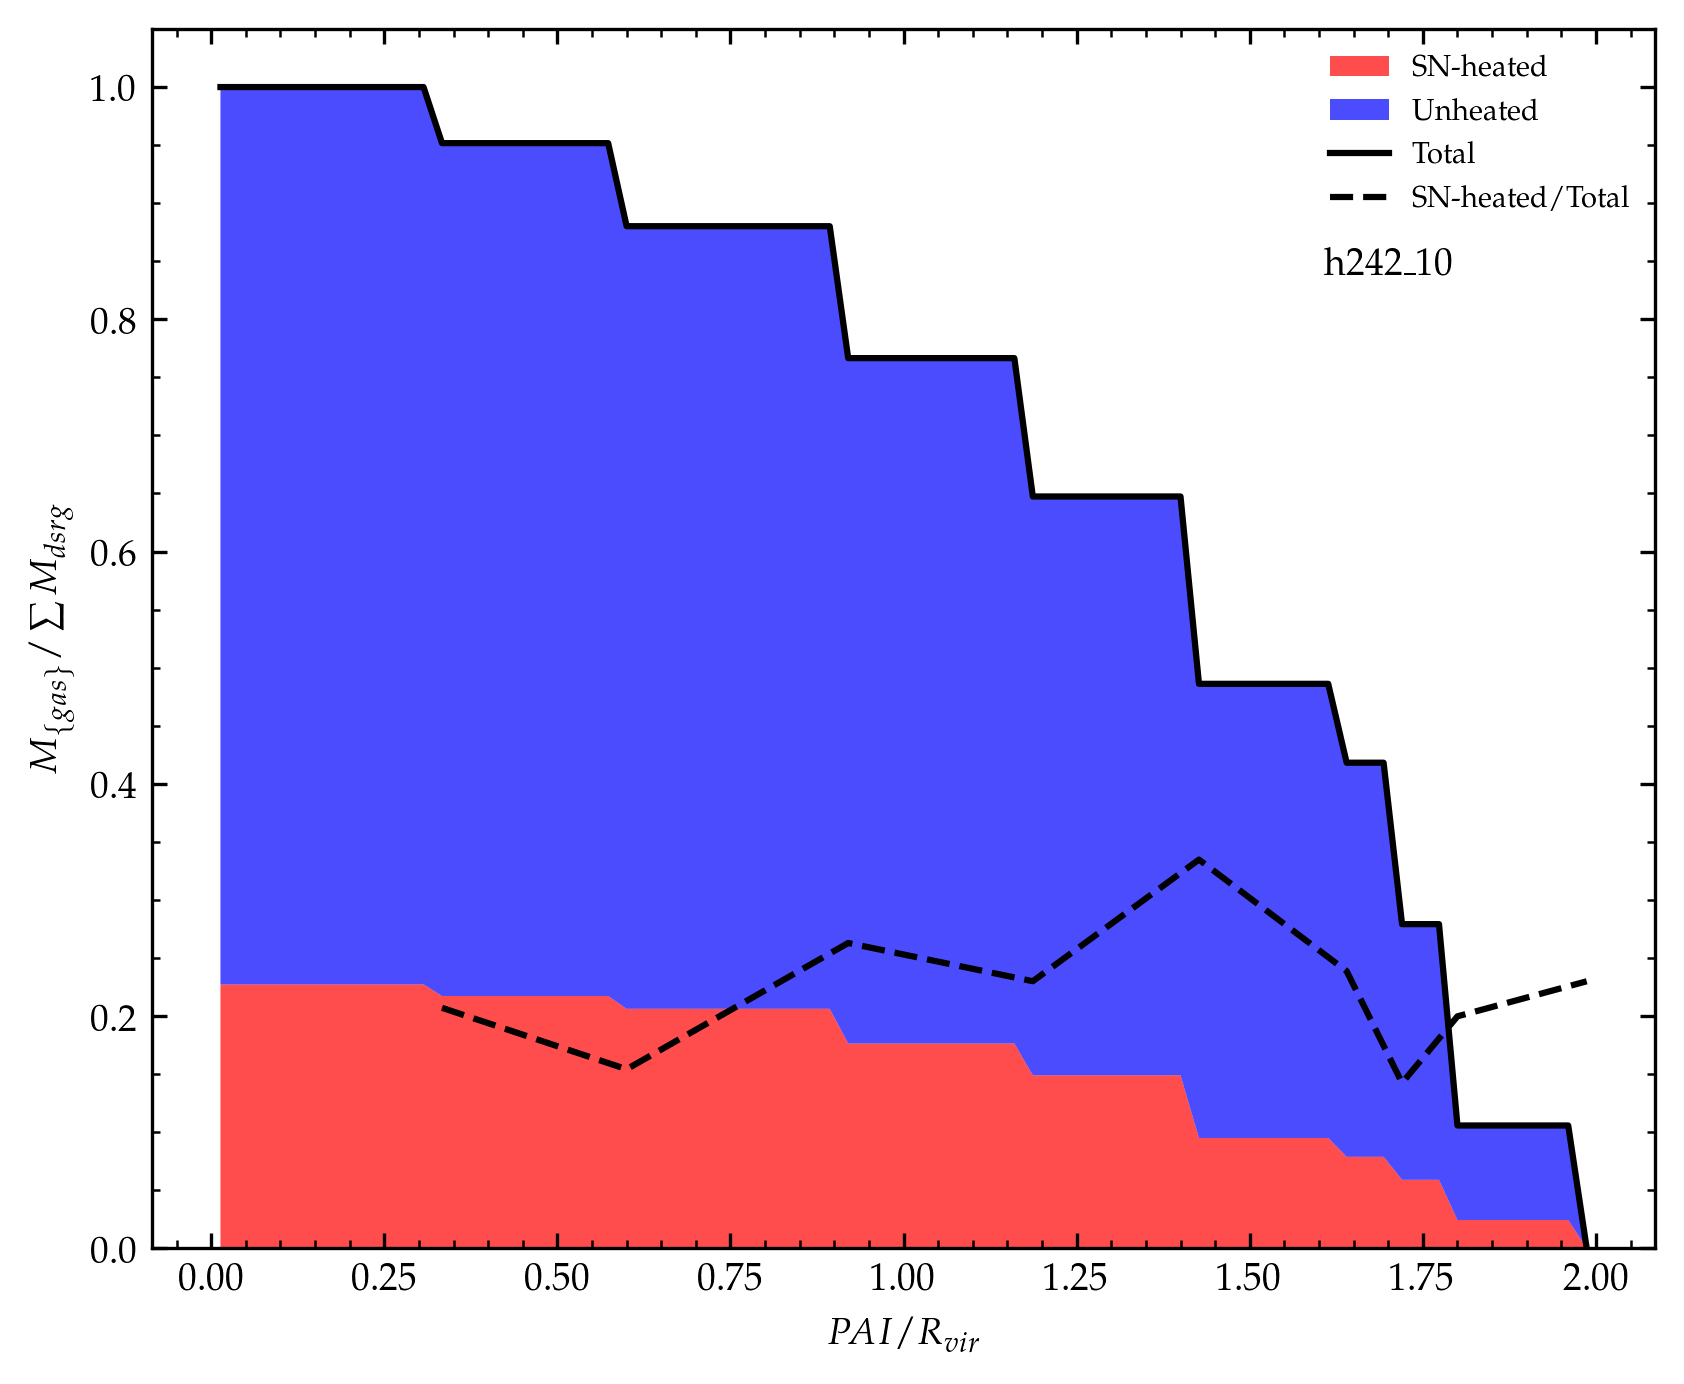

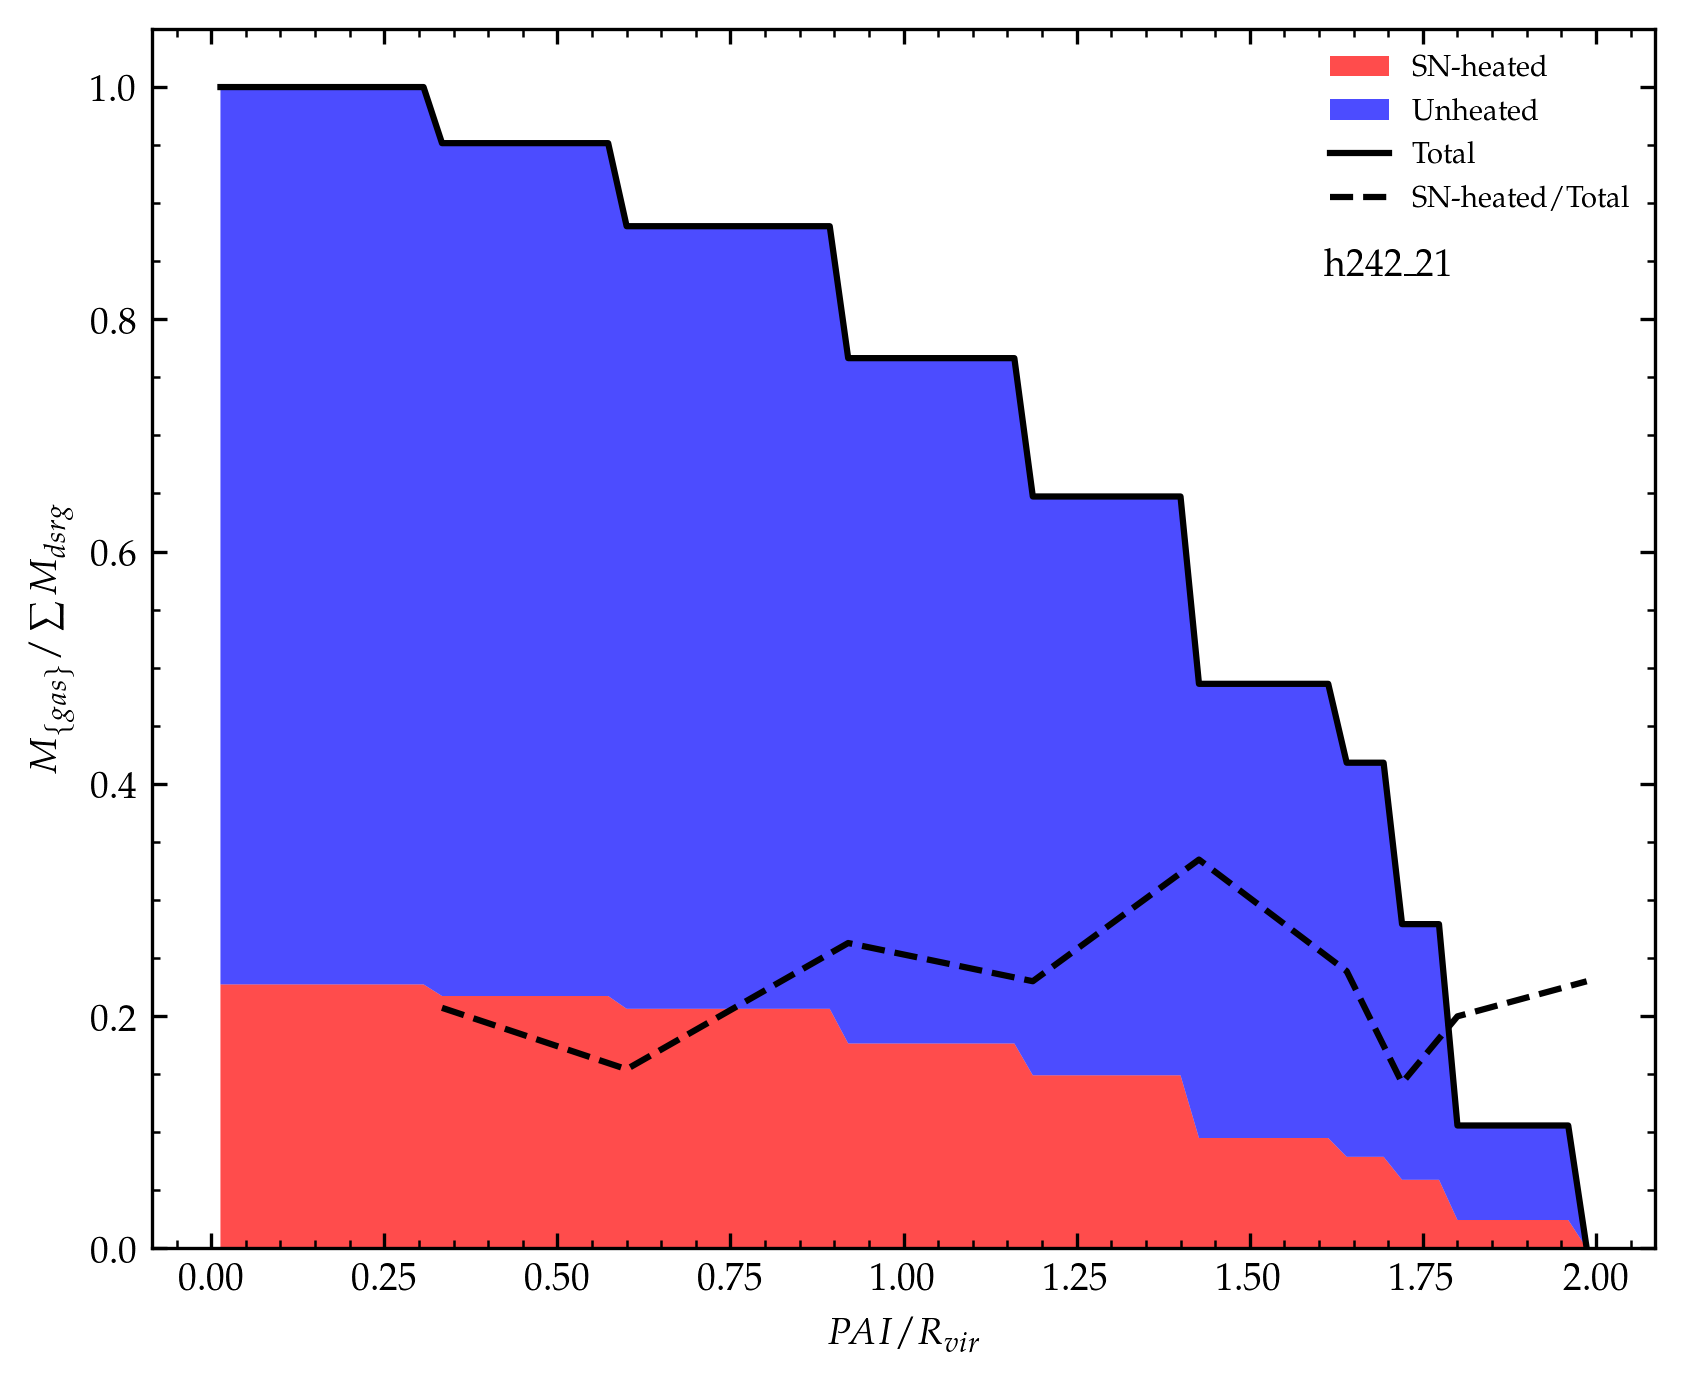

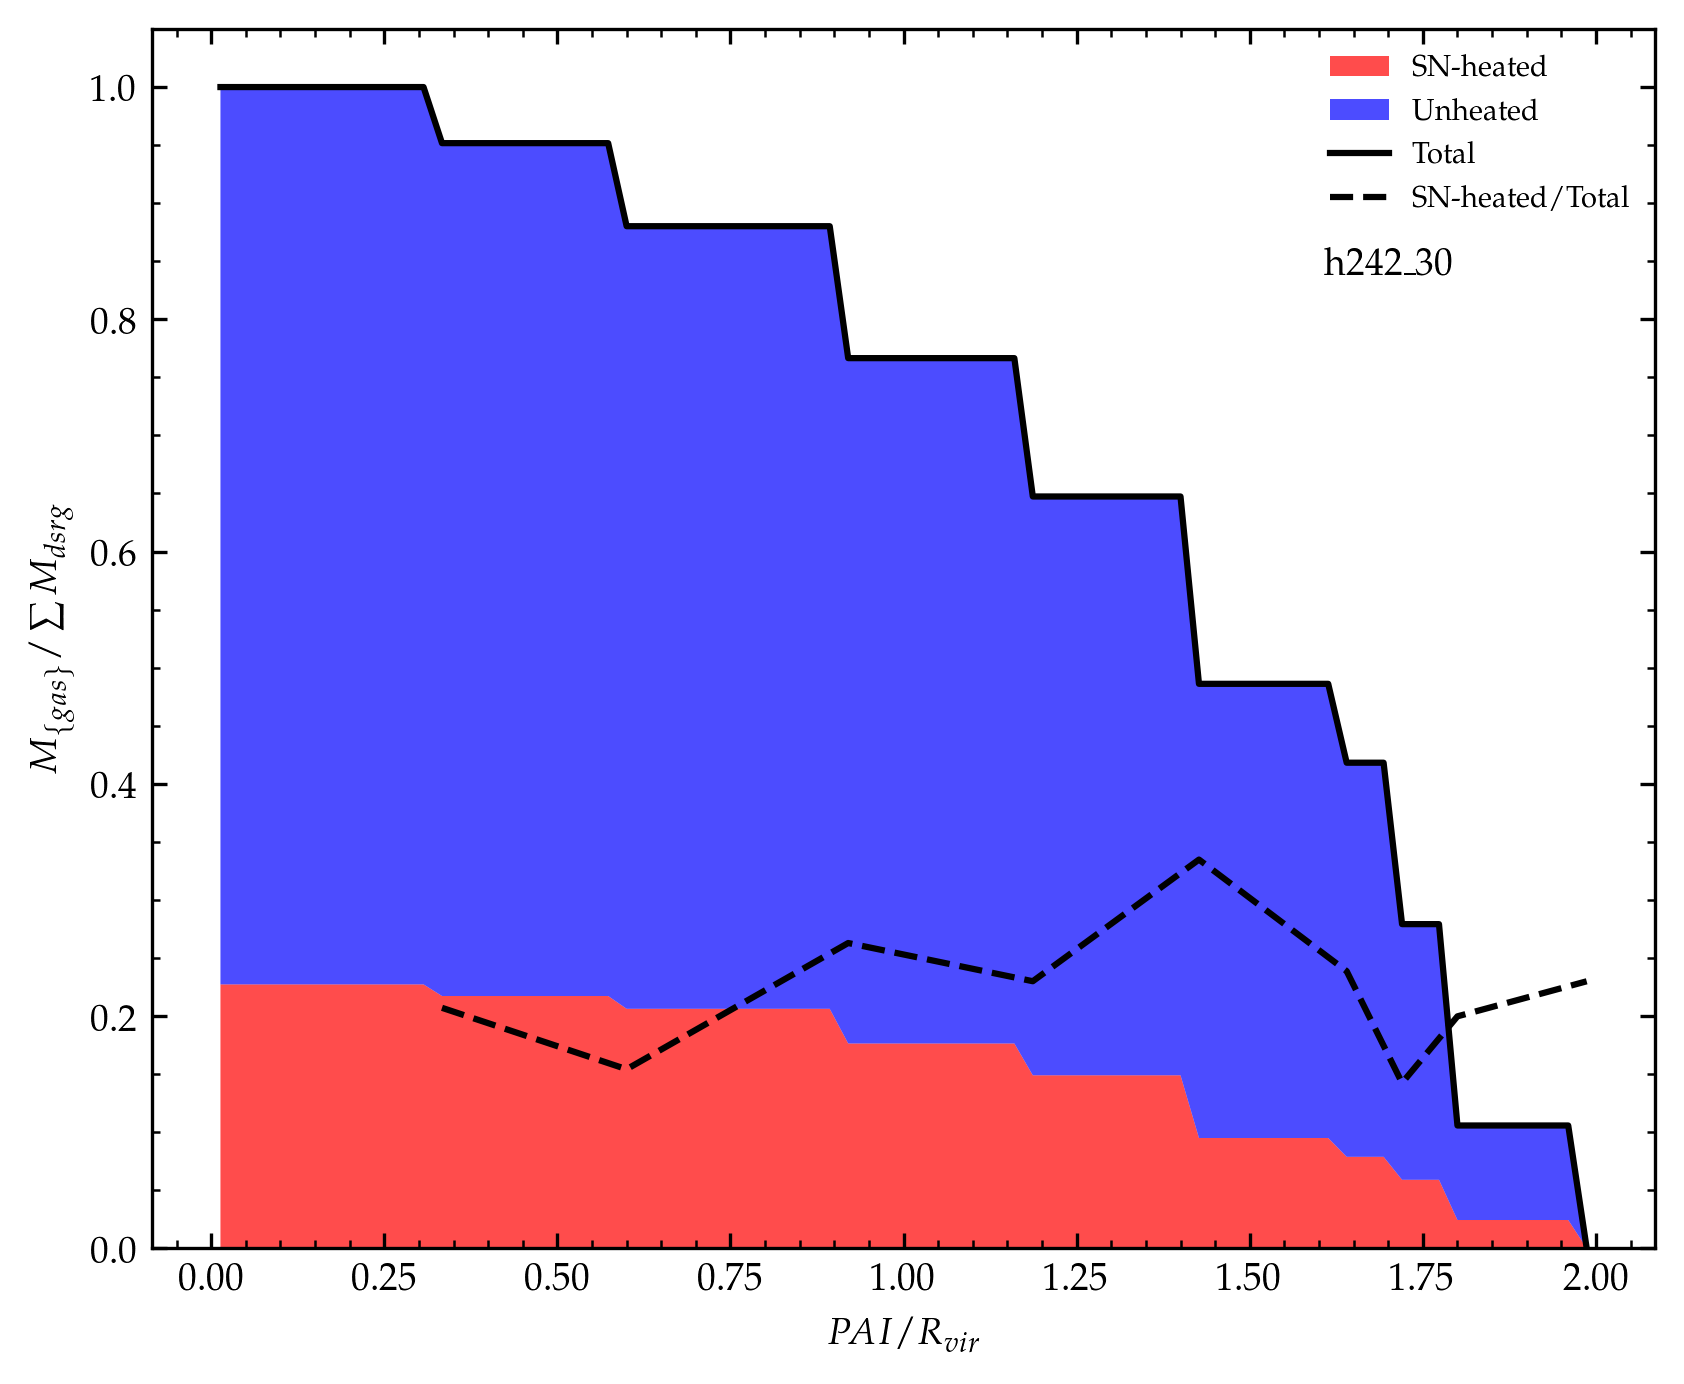

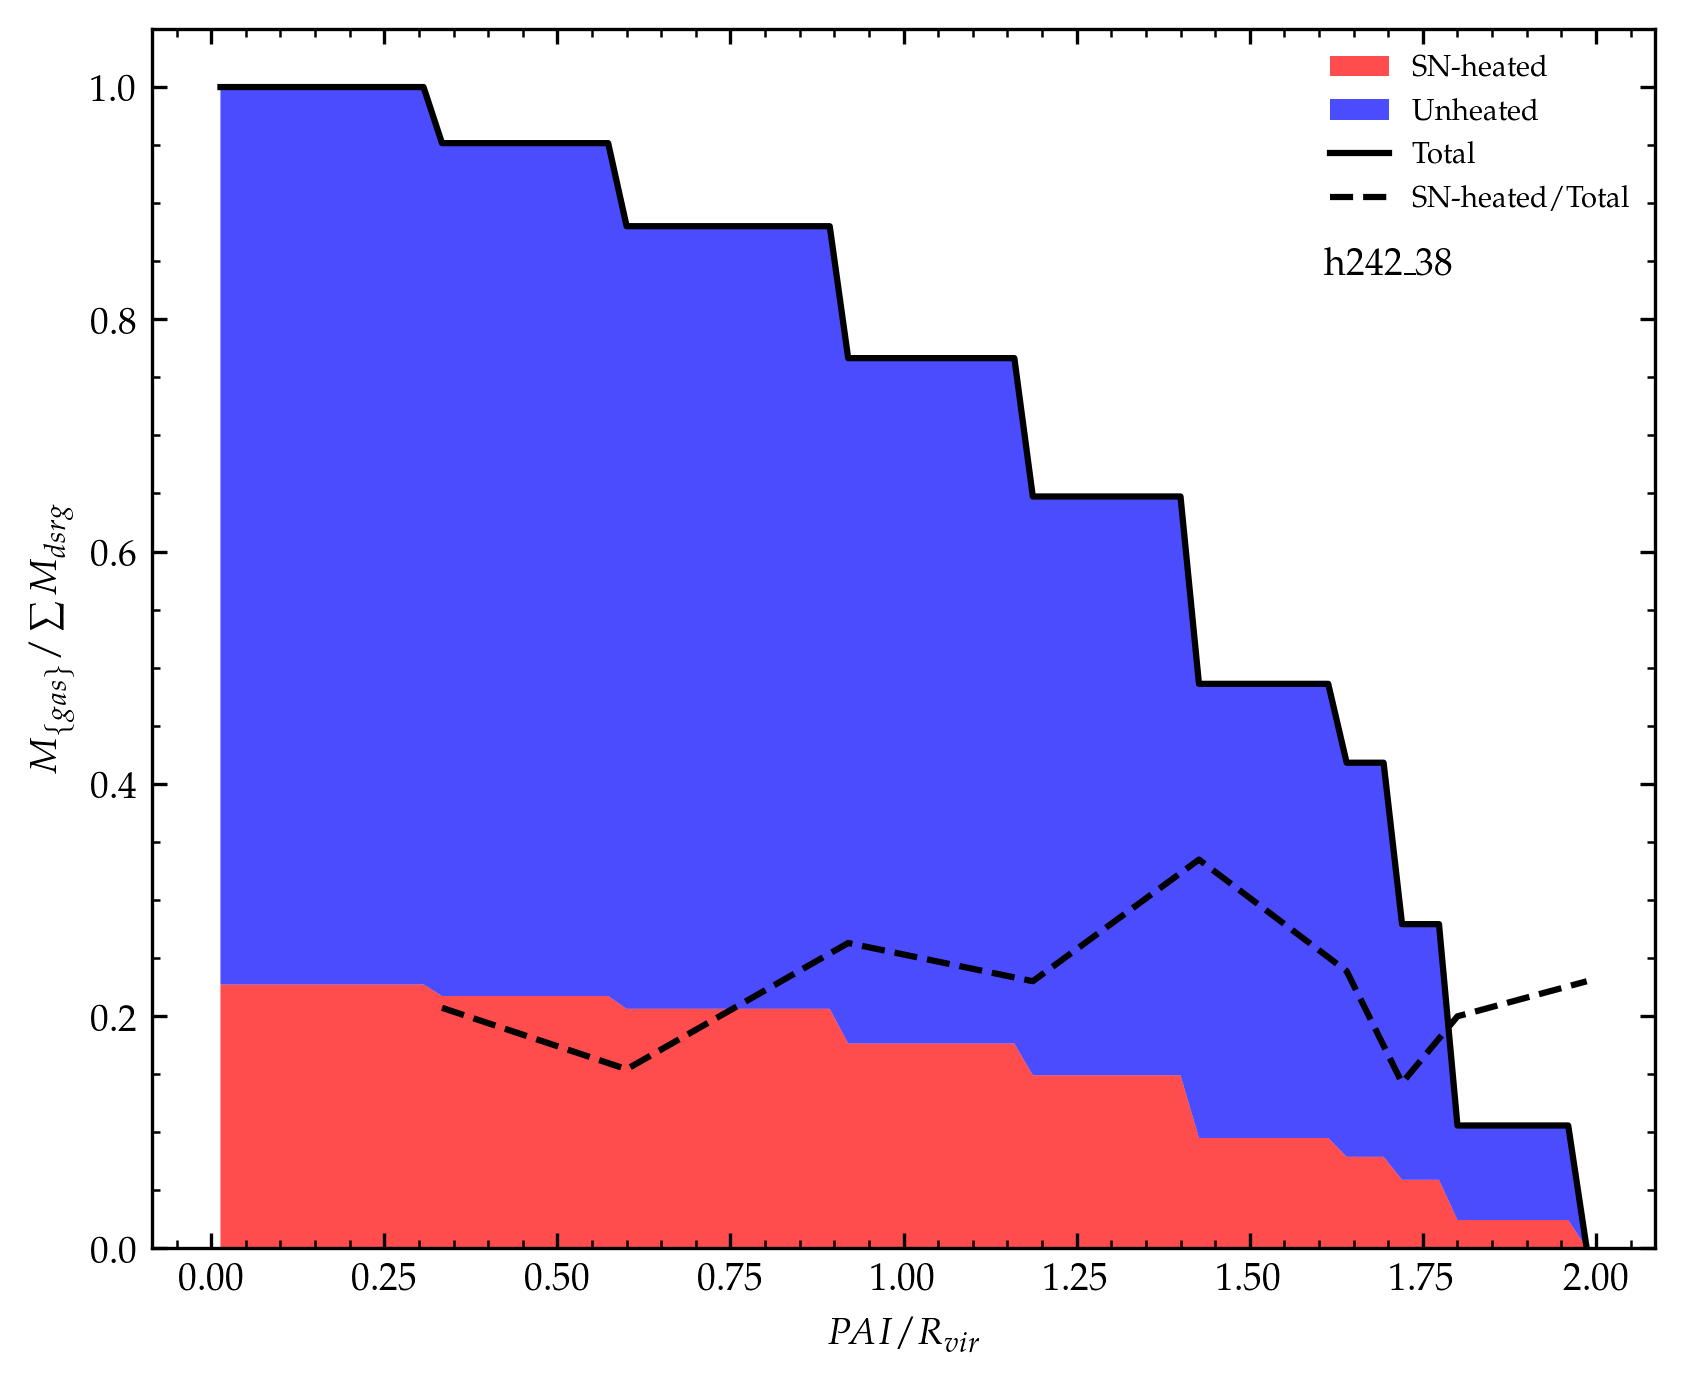

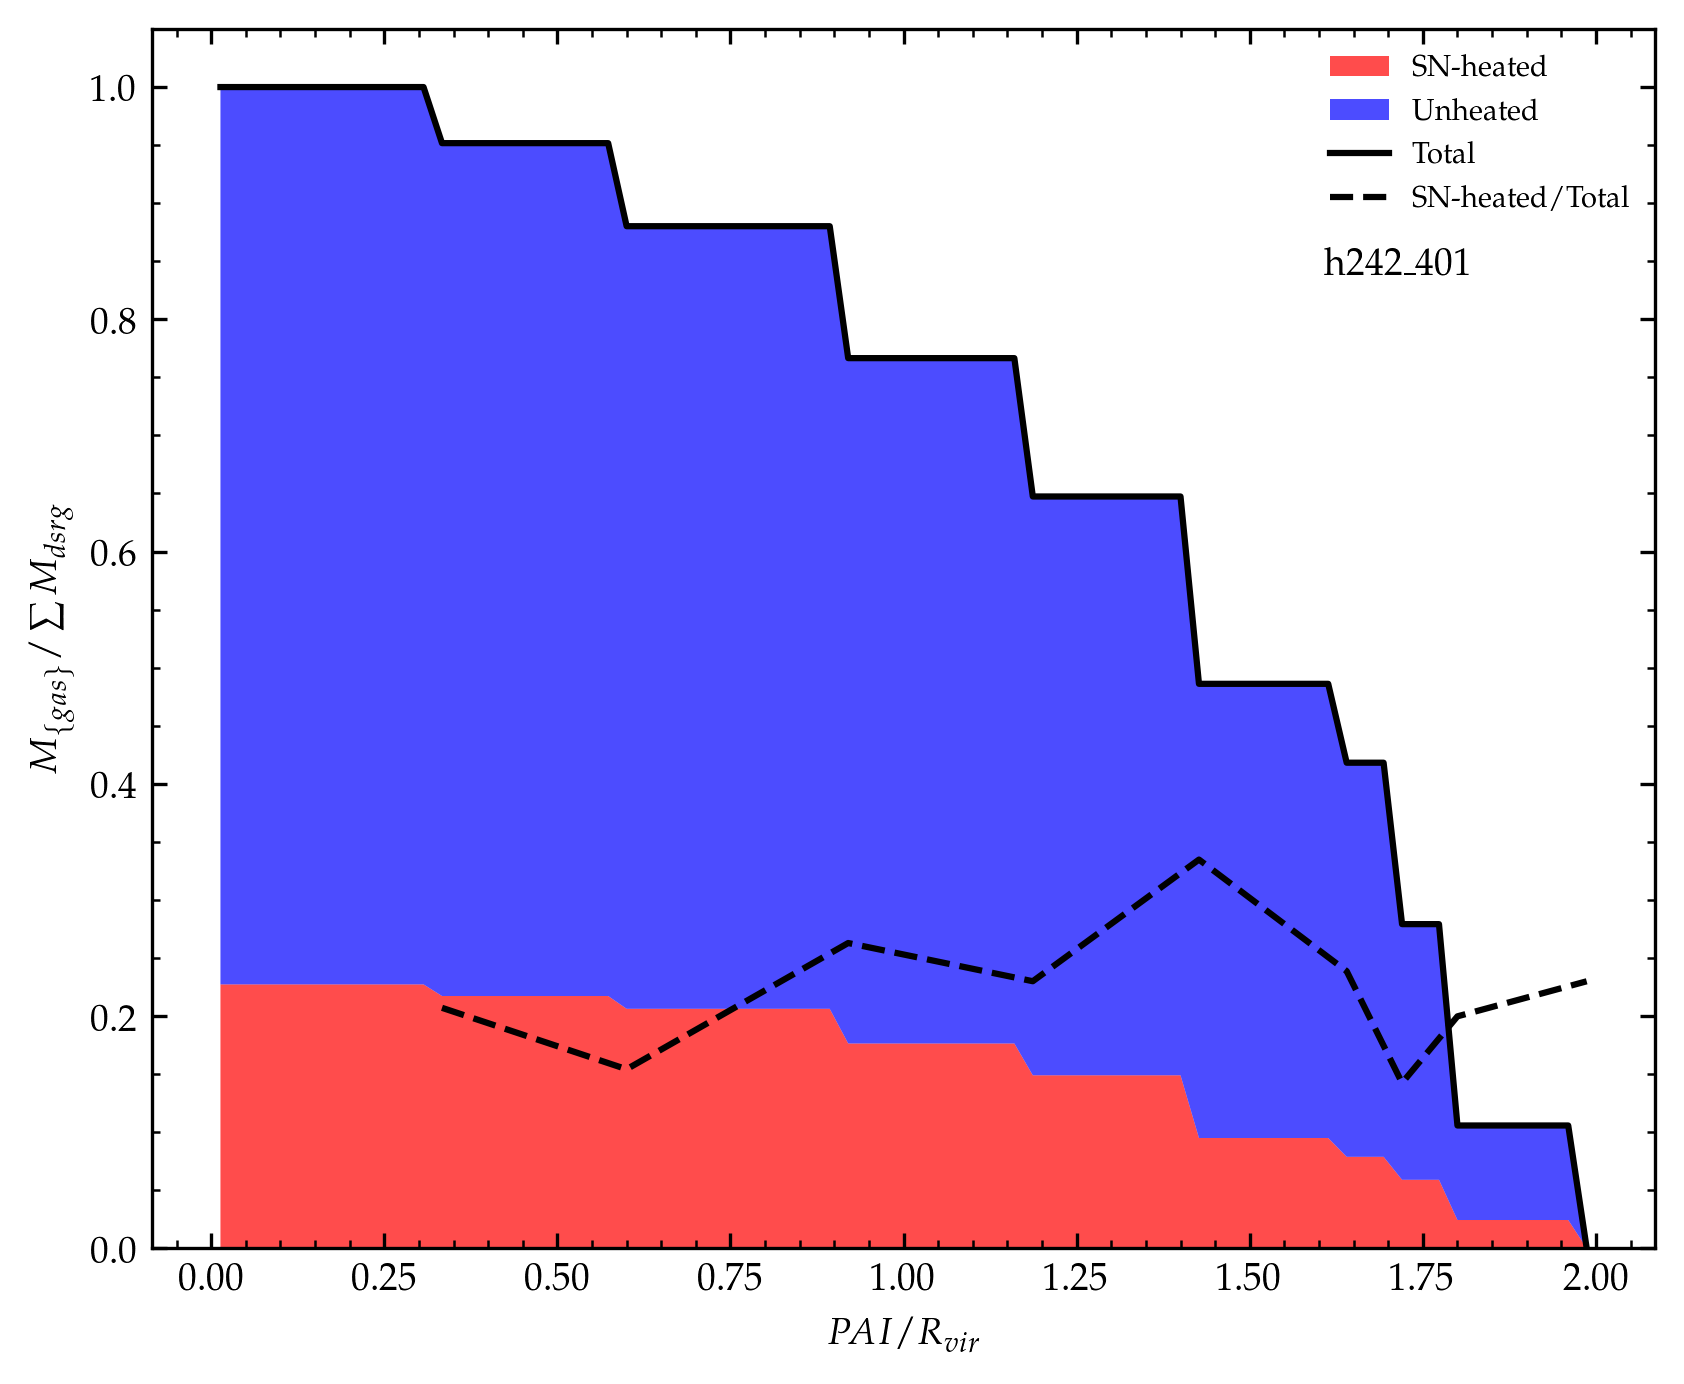

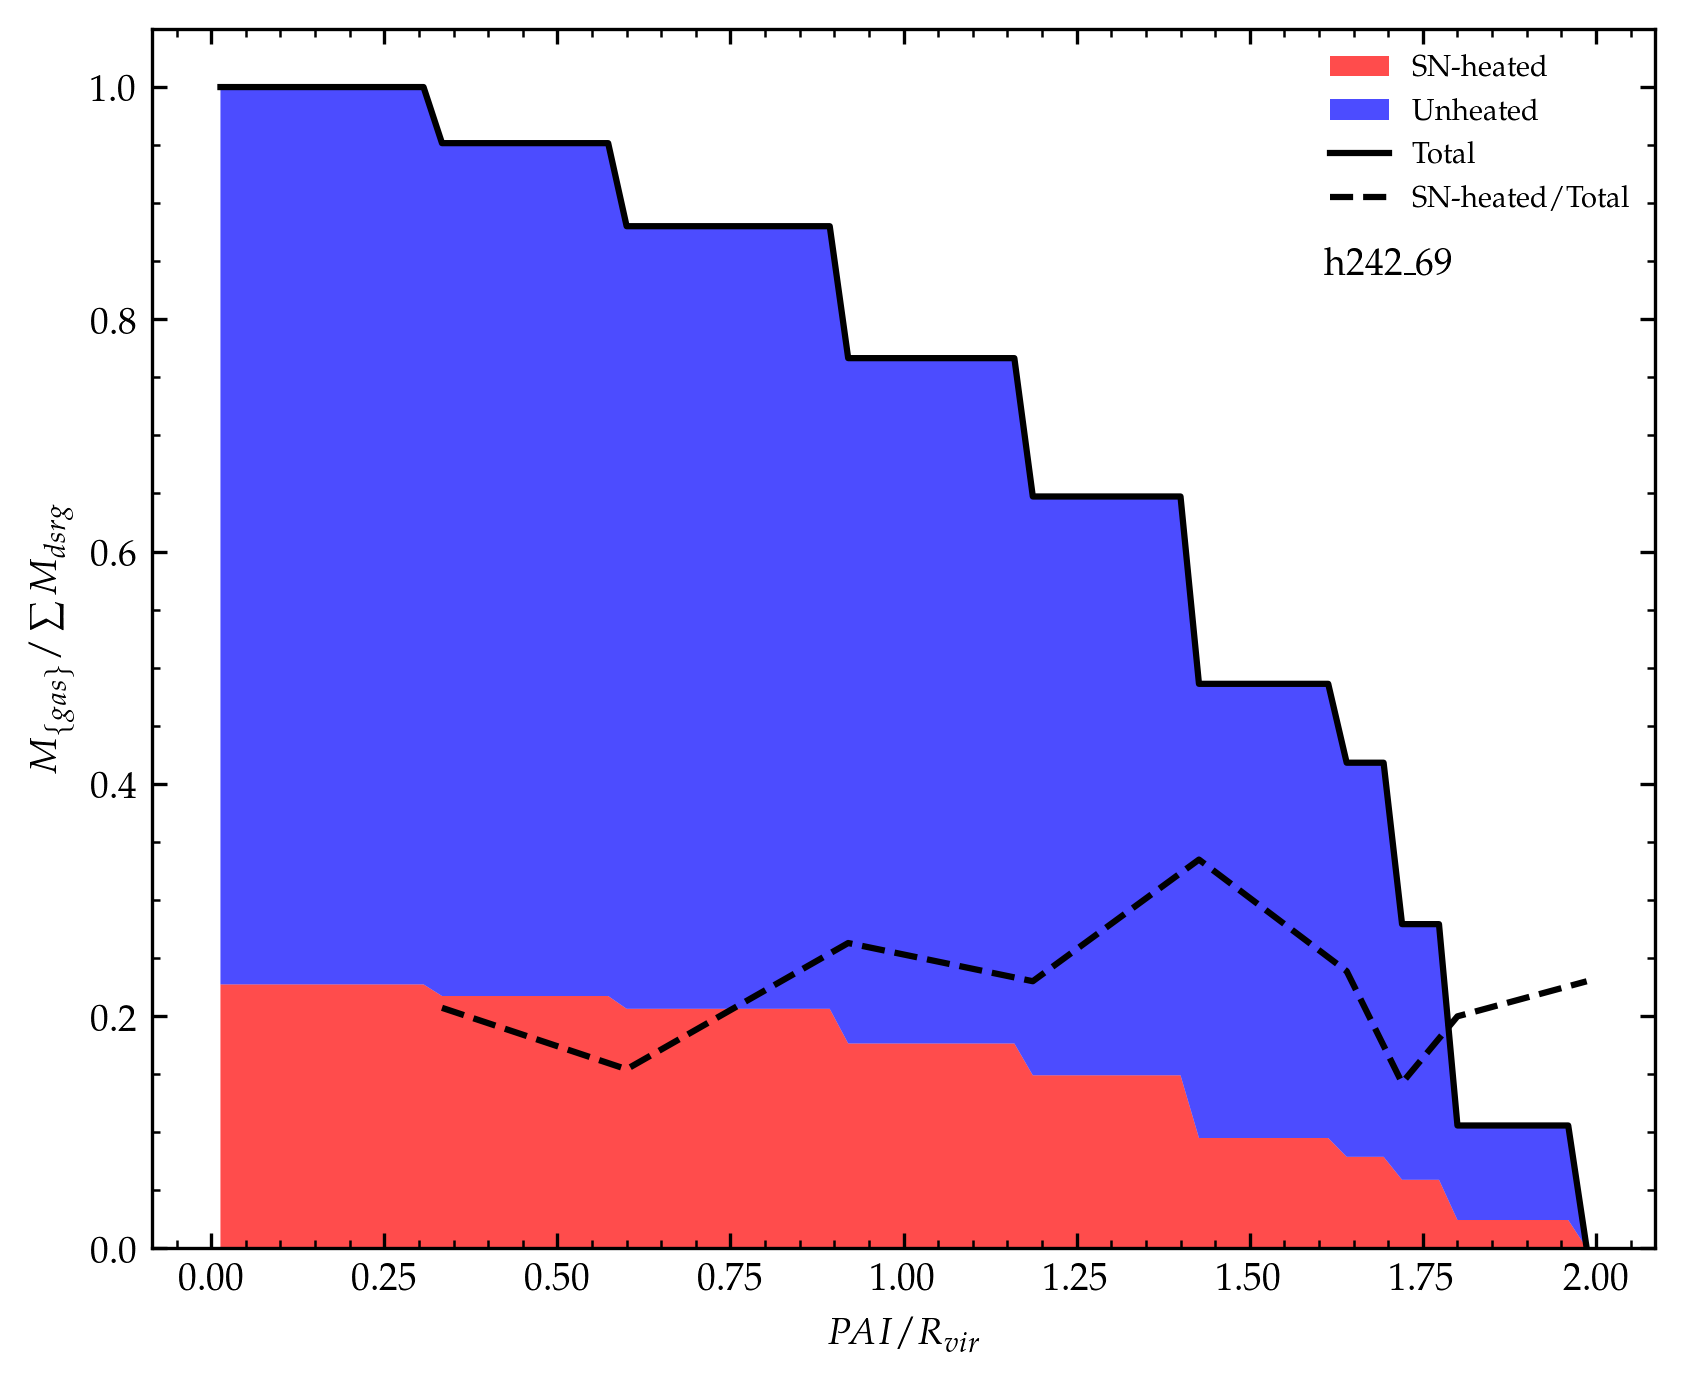

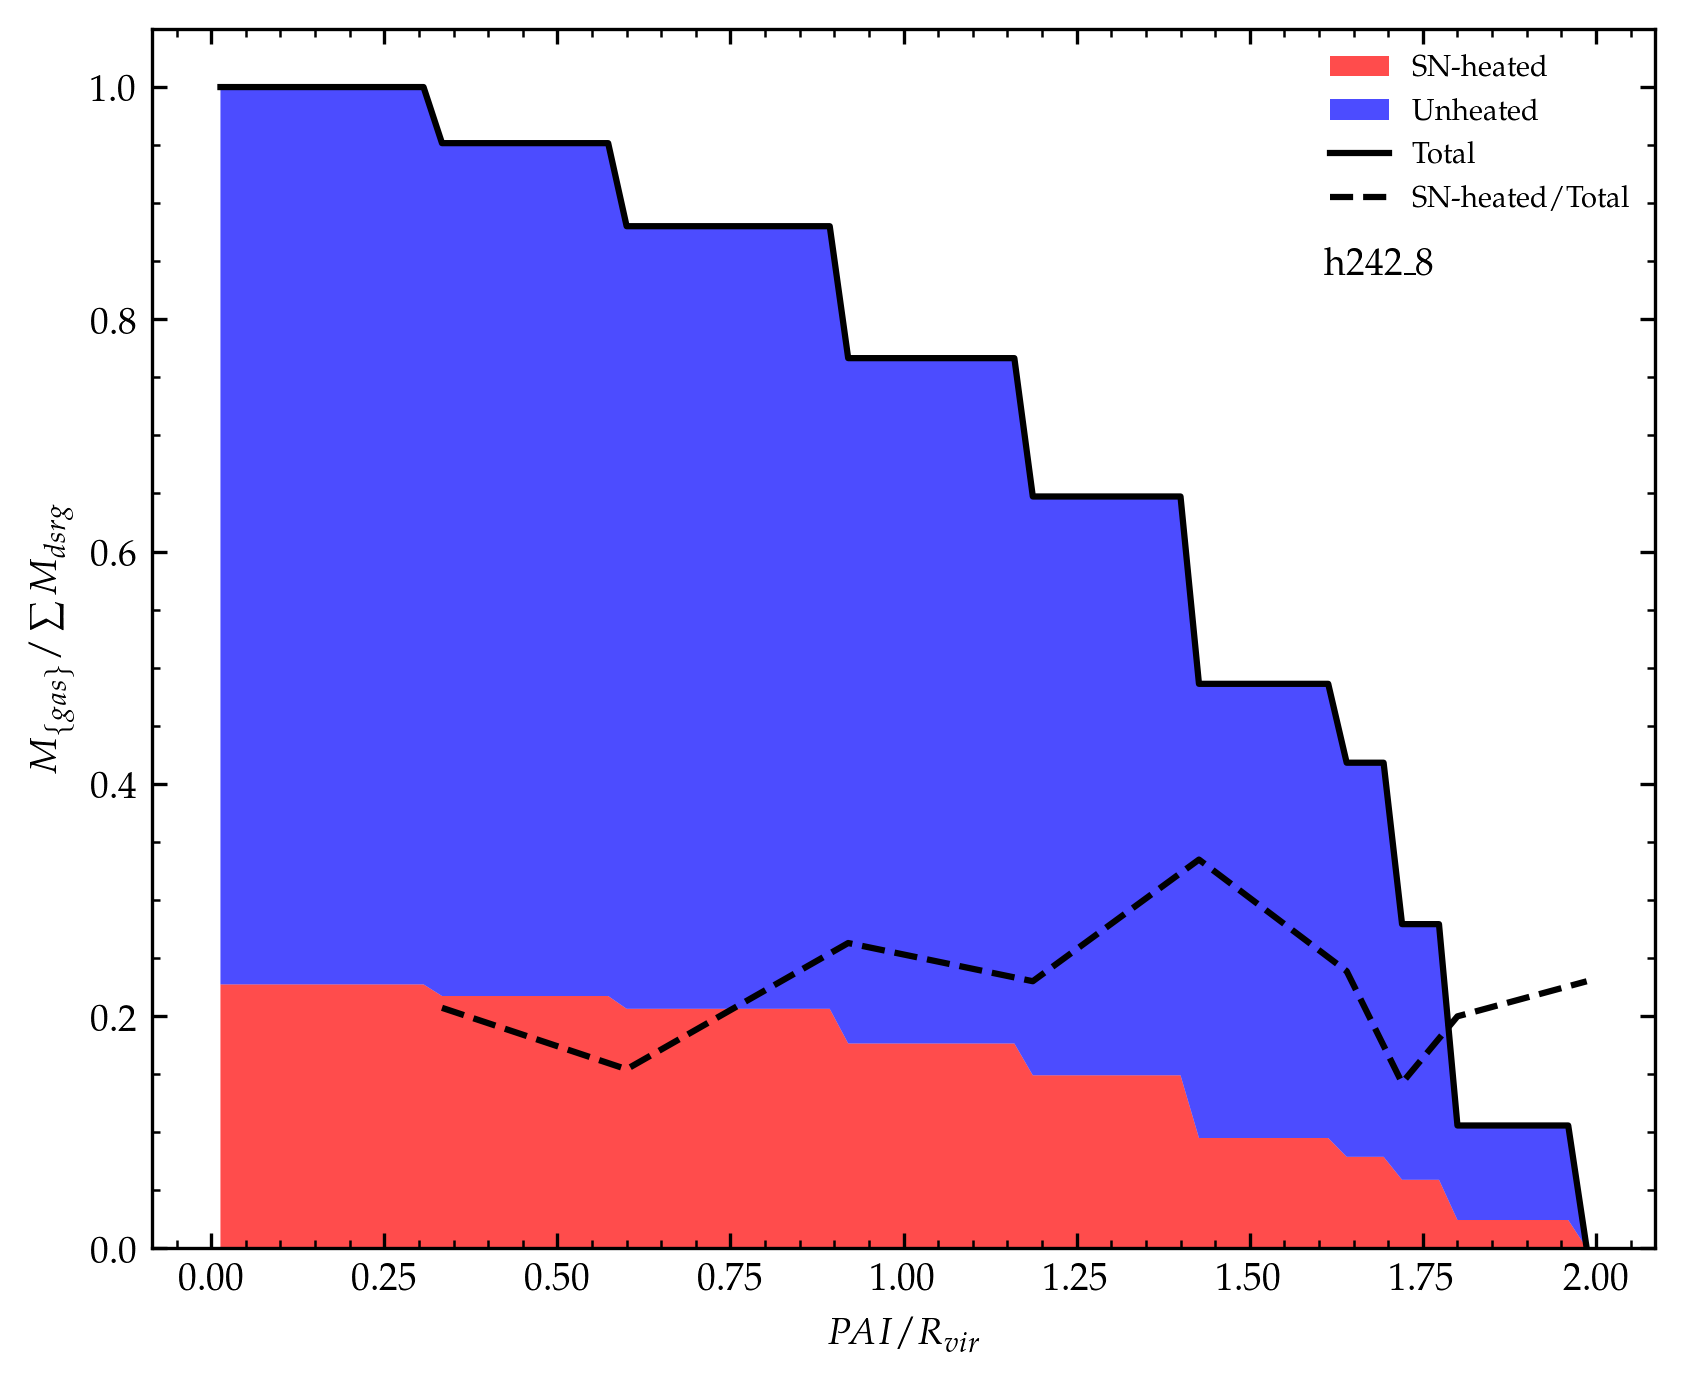

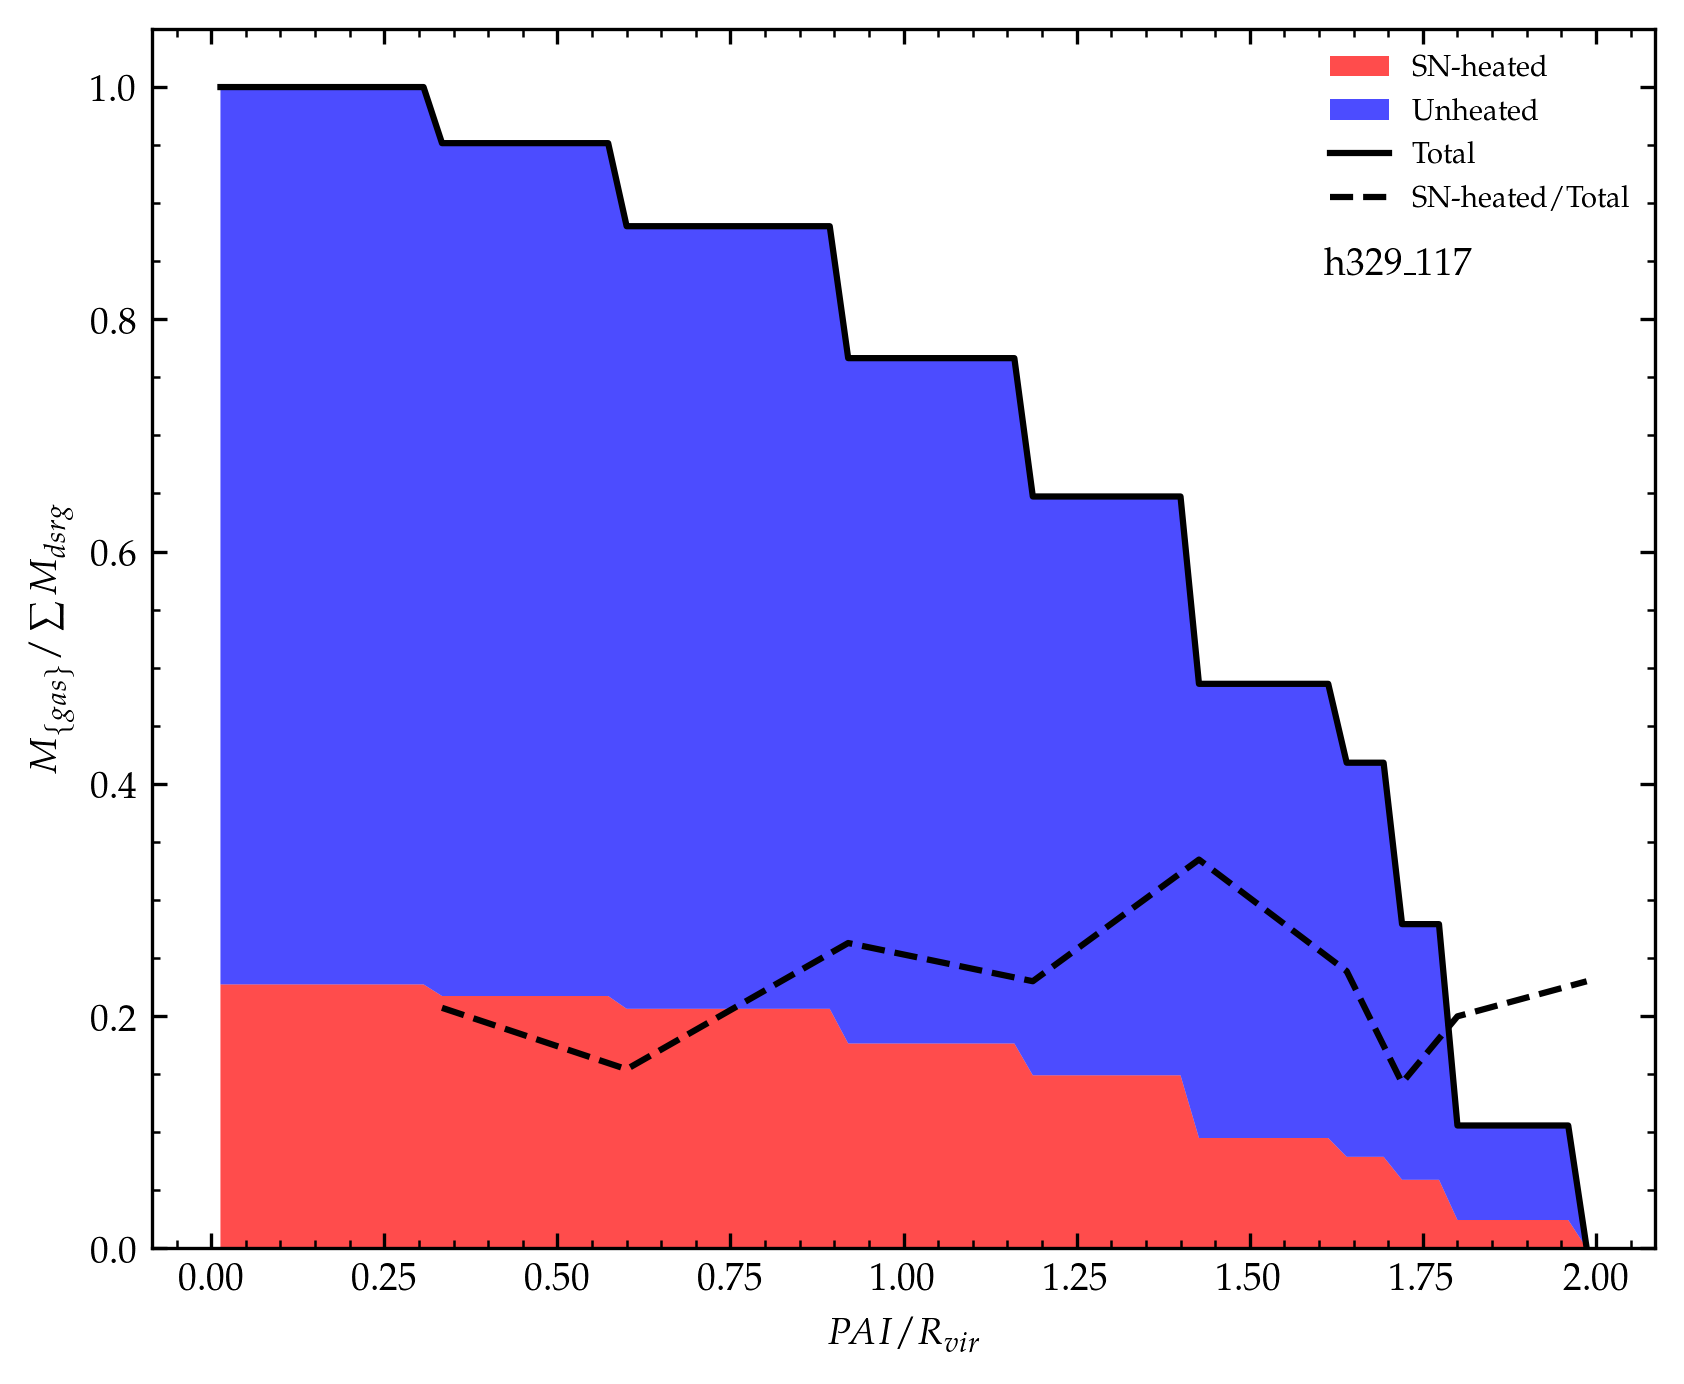

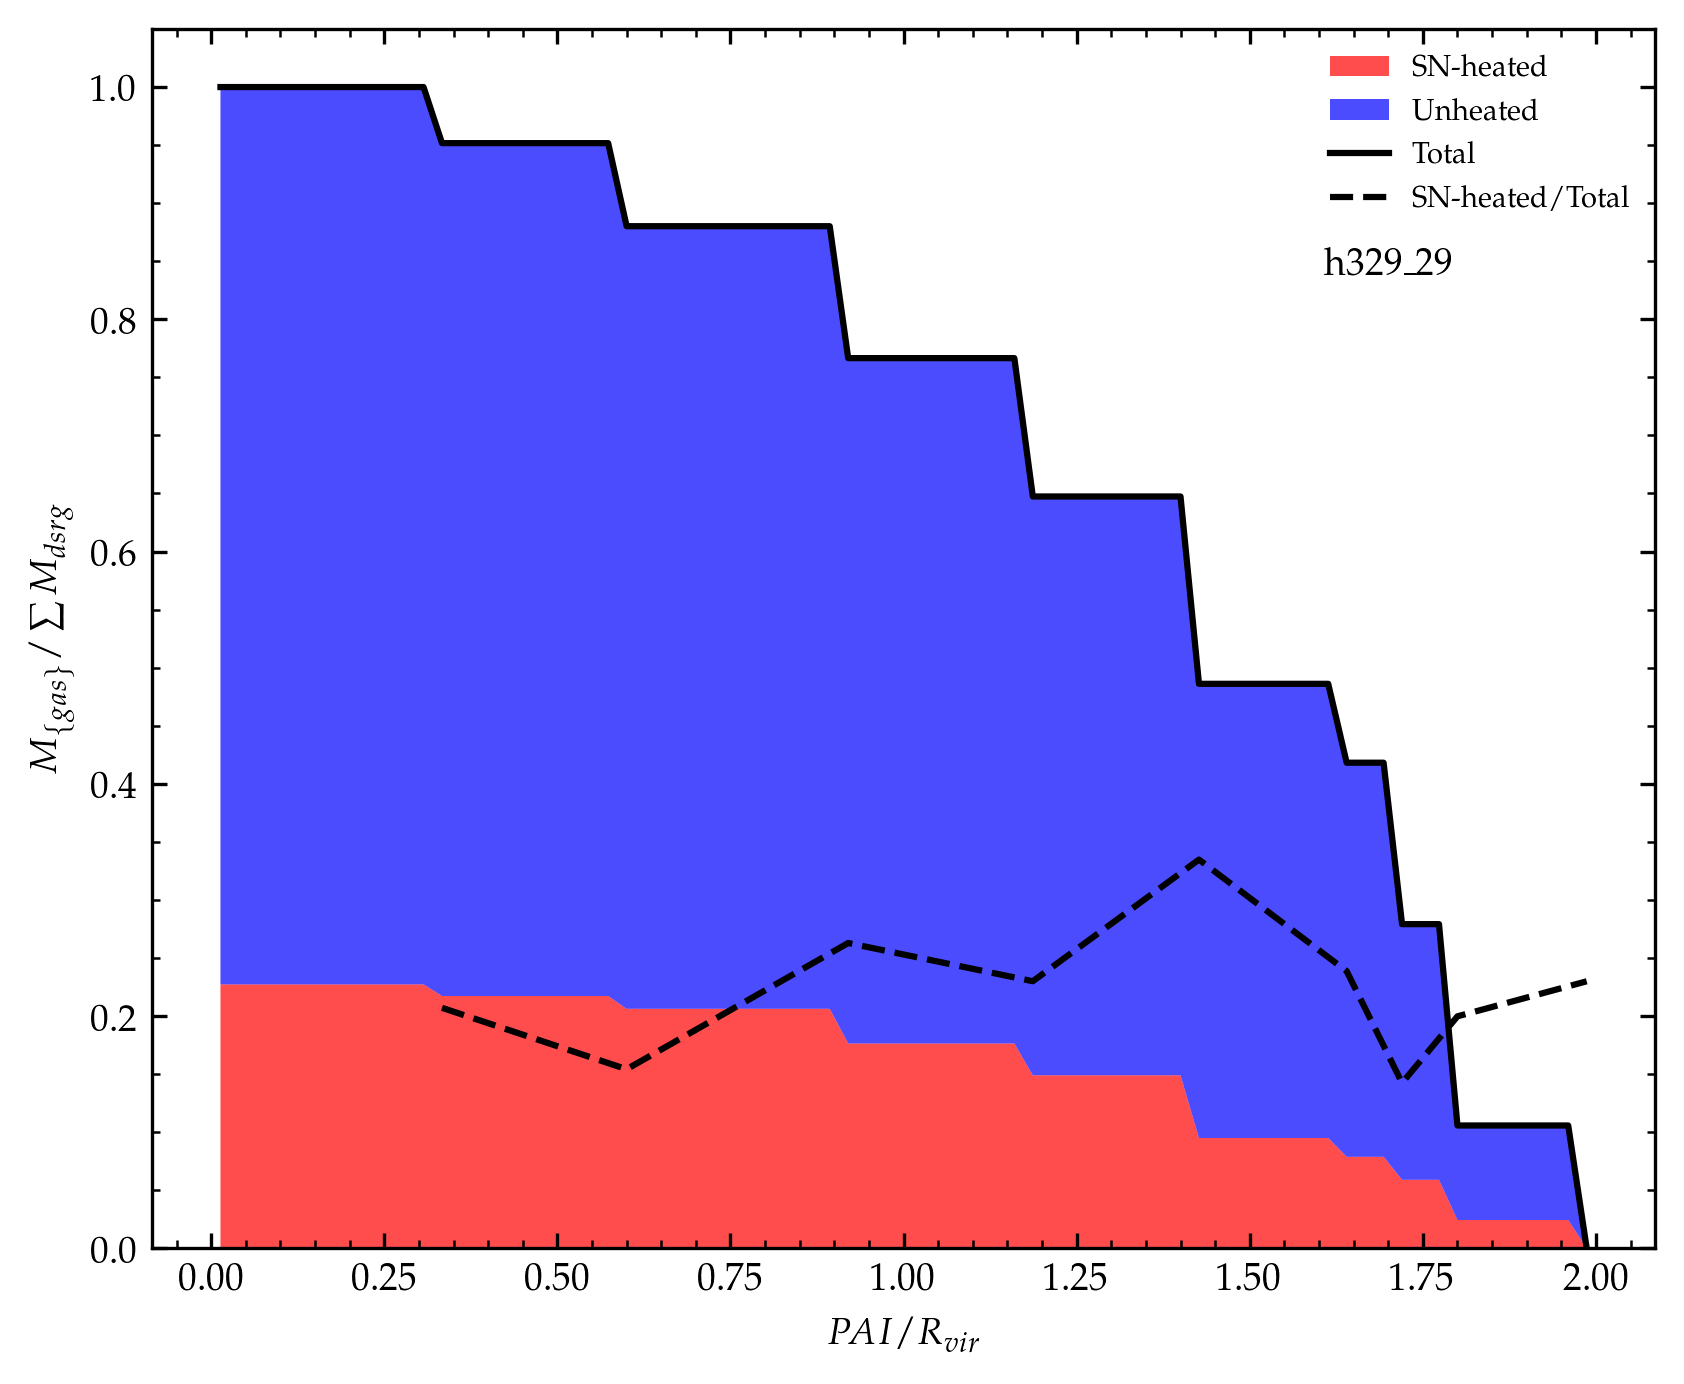

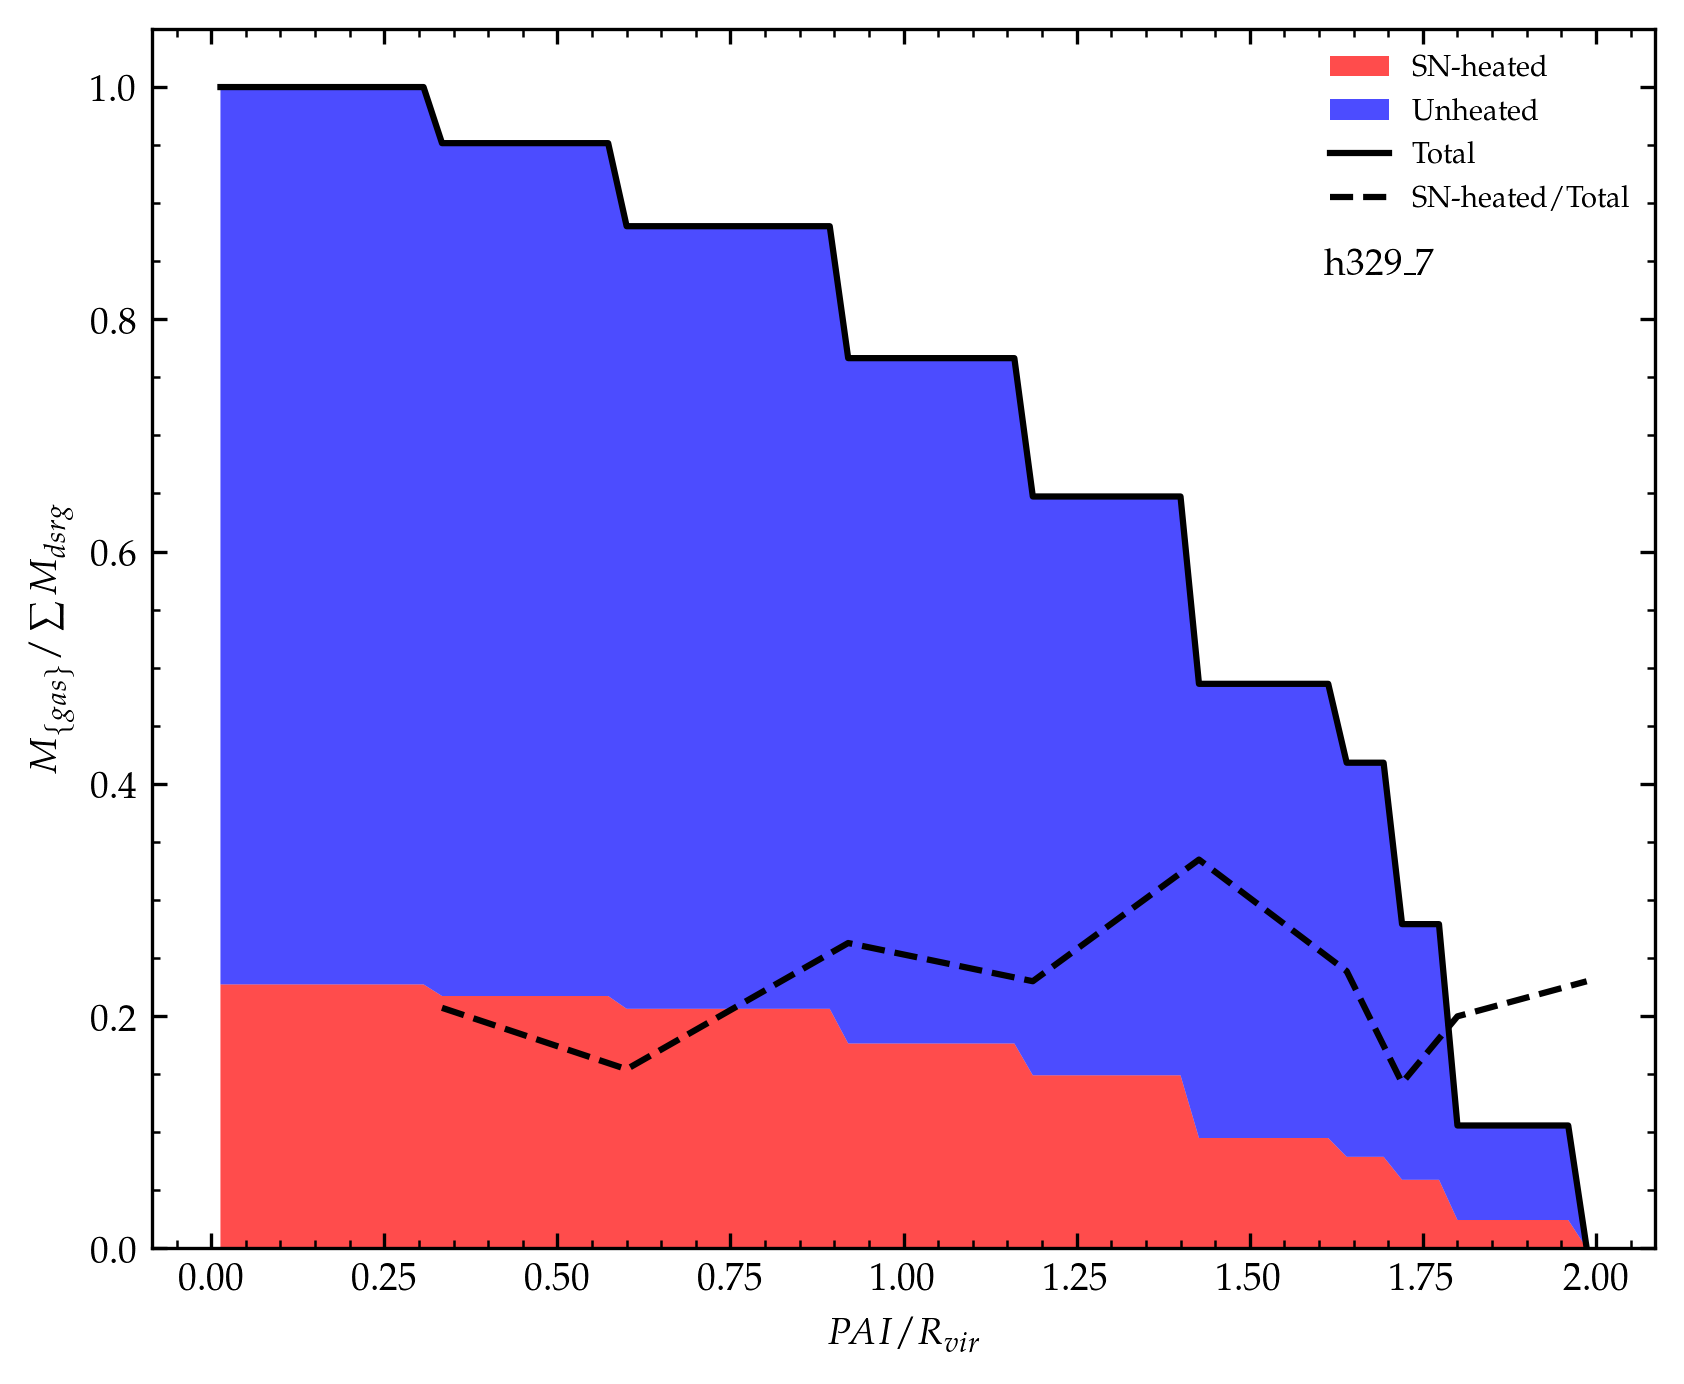

In [15]:
Etotalscaled# Gas loss based on PAI plot
### Plot for all satellites below ###

for key in keys:
    
    # Skip the ones I already have
    exclude = ['h148_10', 'h148_12', 'h148_249', 'h148_251', 'h148_27', 'h148_282', 'h148_3', 'h148_34',
               'h148_38', 'h148_4', 'h148_55','h148_6', 'h148_65', 'h229_14', 'h229_18', 'h229_20',
               'h229_22', 'h229_49']
    if key in exclude:
        continue
    
    # defining discharged dataset if not introduced
    if discharged is None:
        predischarged, discharged, hot_predischarged = read_one_discharged(key)
        # gas SN-heated/unheated prior to discharge.
        hot = discharged[discharged['snHeated']==True]  # heated.
        cold = discharged[discharged['snHeated']==False]  # unheated.
        print('Loaded:', key)
    
### Plot for all satellites above
    
    # identifying where discharged gas is removed to as a function of PAI.
    bins = 75
    fig, ax = plt.subplots(1,1, dpi=300, figsize=(5.5,4.5), sharex=True,
                           constrained_layout=False)

    y1, x = np.histogram(pai(hot), bins=bins, weights=wt(hot,discharged),
                         range=(0, 2))
    bincenters = 0.5*(x[1:] + x[:-1])
    sum1 = np.cumsum(y1)
    y2, x = np.histogram(pai(cold), bins=bins, weights=wt(cold,discharged),
                         range=(0, 2))
    sum2 = np.cumsum(y2)
    ax.stackplot(bincenters, sum1[-1]-sum1, sum2[-1]-sum2, alpha=0.7,
                 colors=['r', 'b'], labels=['SN-heated', 'Unheated'])         

    y3, x = np.histogram(pai(discharged), bins=bins, weights=wt(discharged),
                         range=(0, 2))
    bincenters = 0.5*(x[1:] + x[:-1])
    sum3 = np.cumsum(y3)
    ax.plot(bincenters, sum3[-1]-sum3, alpha=1.0, c='black', label='Total')

    ax.plot(bincenters[y3>0], (y1/y3)[y3>0], linestyle='--', c='black',
            label='SN-heated/Total')

    # ax.set_title('Gas Discharged Over Infall Distances', fontsize='medium')
    ax.set_xlabel(r'$PAI / R_{vir}$')
    ax.set_ylabel('$M_{\{gas\}} / \sum M_{dsrg}$')
    # # ax[1].set_xlim(-0.1,4)
    # ax[1].set_ylim(0,0.2)

    ax.tick_params(direction='in', which='both', top=True, right=True)
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
    # ax.grid(alpha=0.1, zorder=-1000)

    ax.legend(frameon=False, fontsize=7)
    ax.annotate(key, (0.78, 0.82), xycoords='axes fraction', va='top', zorder=1000)
    plt.savefig(f'plots/PAIperRvir_{key}.pdf')
    plt.show()

# Radial Distance, Velocity, Temperature Dependency
## h148_10 for instance

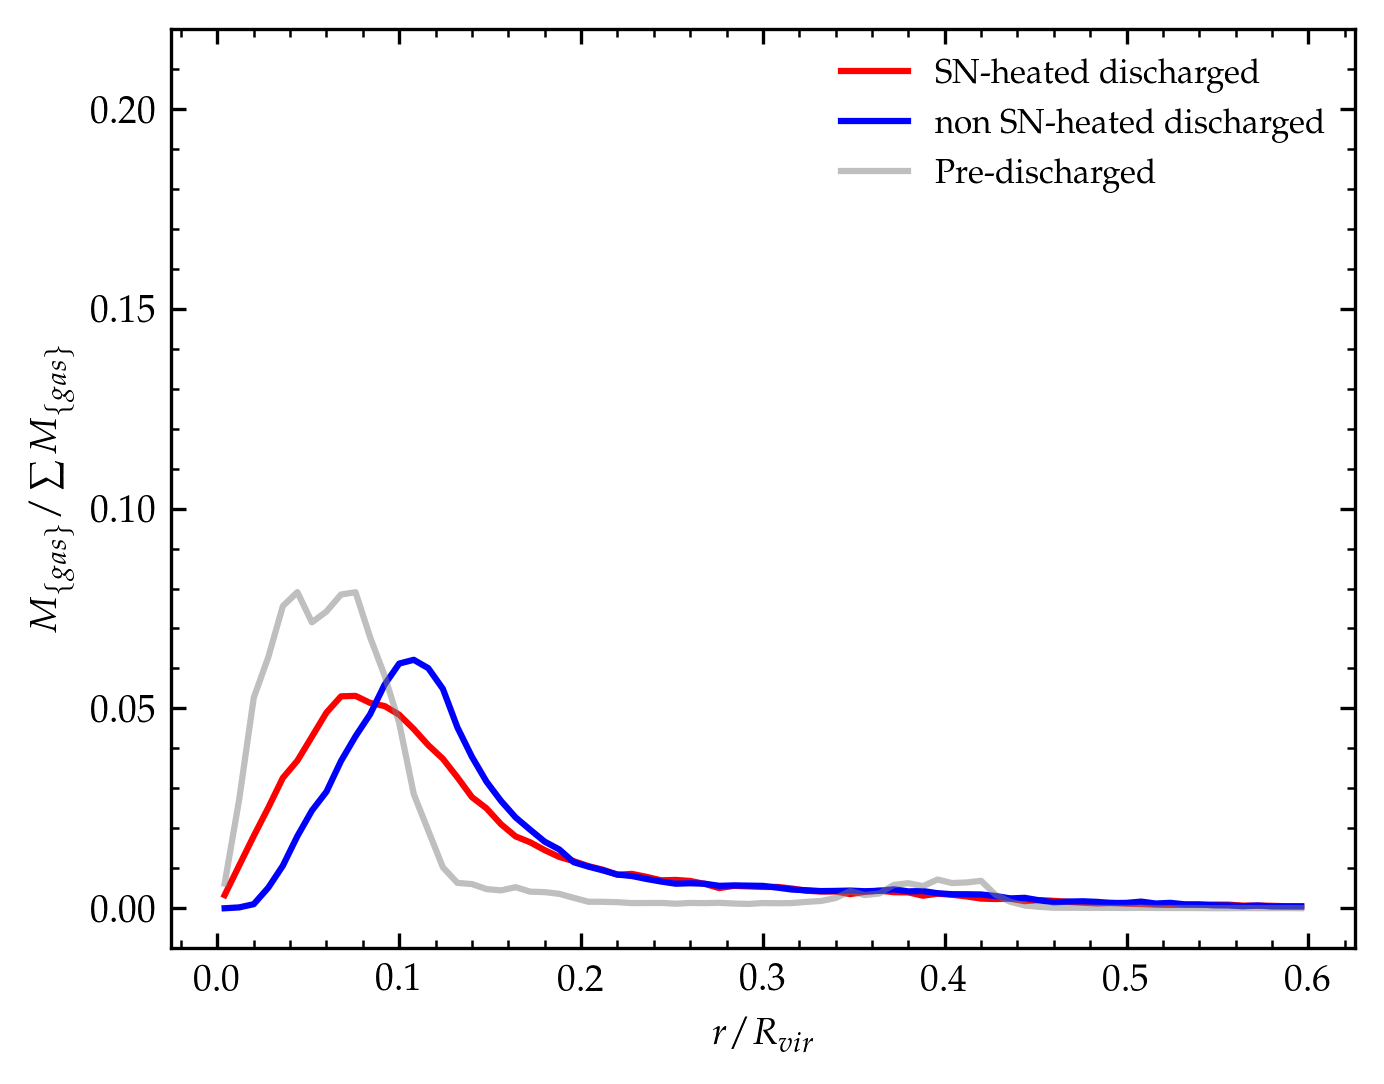

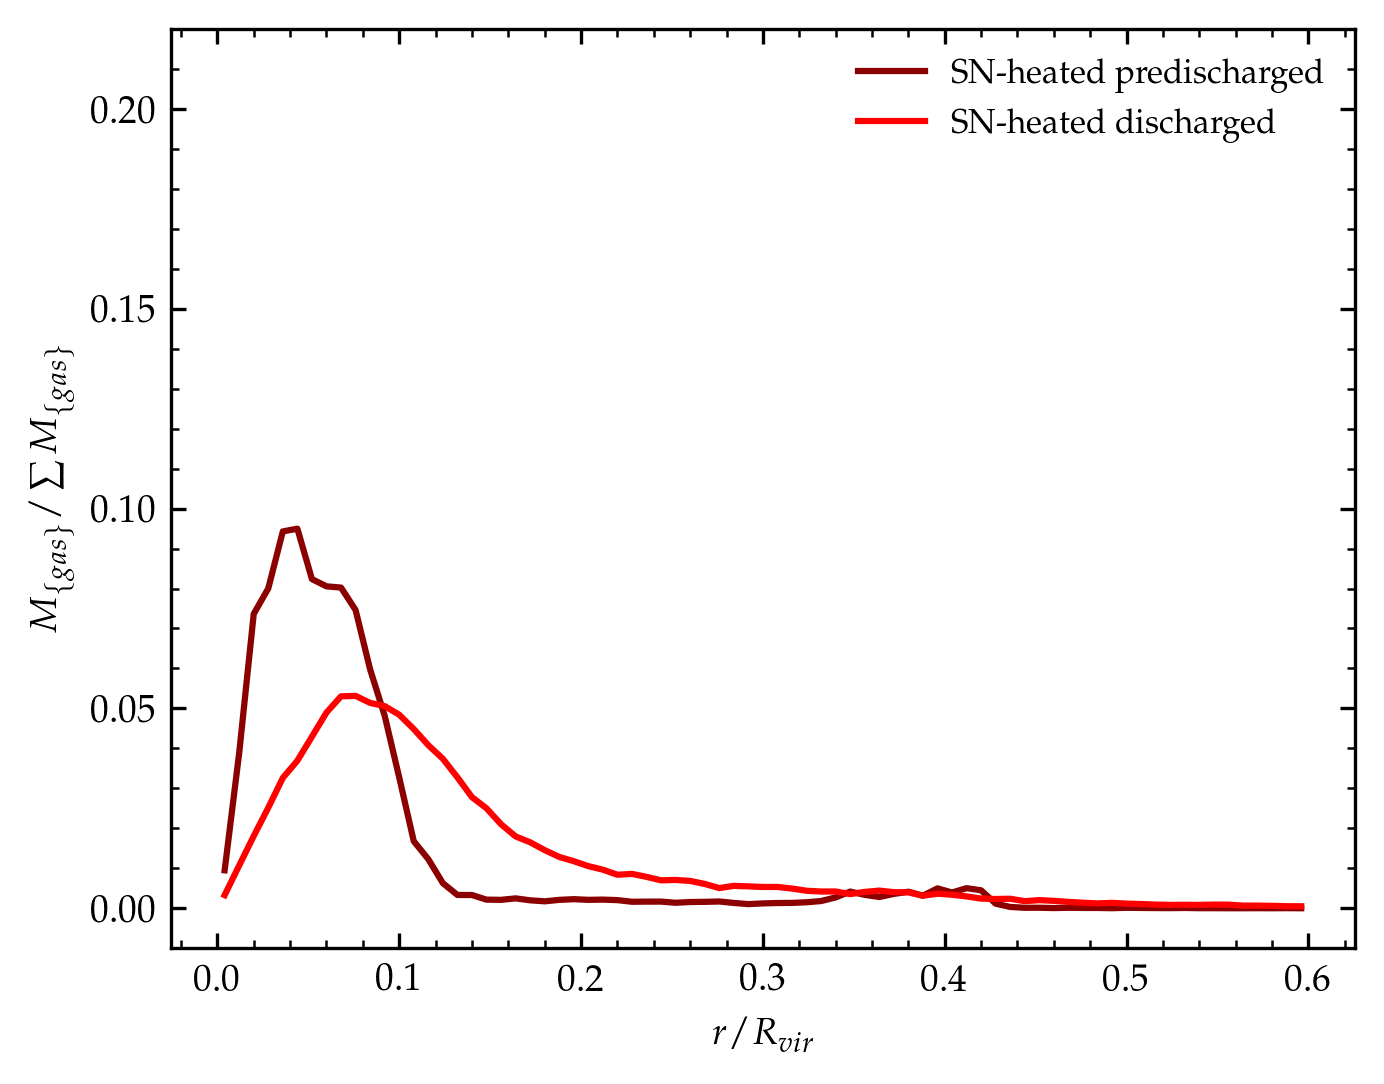

In [11]:
# compiling radial positions for each gas particle. data has precalculated key 
# 'r_per_Rvir', radial position normalized by the virial radius of the satellite, 
# that we will use for our position computations here.


##### plotting unheated vs. heated discharged gas #####
bins = 75
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(4.5,3.5), constrained_layout=True)

y1, x = np.histogram(hot.r_per_Rvir, bins=bins, weights=wt(hot), range=(0, 0.6))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='SN-heated discharged', color='r')

y2, x = np.histogram(cold.r_per_Rvir, bins=bins, weights=wt(cold), range=(0, 0.6))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y2, label='non SN-heated discharged', color='b')

y3, x = np.histogram(predischarged.r_per_Rvir, bins=bins, weights=wt(predischarged),
                     range=(0, 0.6))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y3, label='Pre-discharged', linestyle='-', color='grey', alpha=0.5)


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

# ax.set_title('(a) Discharged Gas Radial Position Distributions', fontsize='medium')
ax.set_xlabel(r'$r/R_{vir}$')
plt.ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
# ax.set_xlim(0,1)
ax.set_ylim(-0.01,0.22)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.02))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))


ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)

##plt.savefig('plots/rPerRvir_h148_10_general.pdf')



##### plotting discharged vs. pre-discharged, heated gas #####
# bins = 75
fig, ax = plt.subplots(1,1,dpi=300, figsize=(4.5,3.5), constrained_layout=True) # change to dpi=300 for printout.

y1, x = np.histogram(hot_predischarged.r_per_Rvir, bins=bins,
                     weights=wt(hot_predischarged), range=(0, 0.6))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='SN-heated predischarged', color='darkred')

y2, x = np.histogram(hot.r_per_Rvir, bins=bins, weights=wt(hot), range=(0, 0.6))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y2, label='SN-heated discharged', color='red')


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

# ax.set_title('(b) Positions pre/post SN-heated Gas Discharge', fontsize='medium')
ax.set_xlabel(r'$r/R_{vir}$')
plt.ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
# ax.set_xlim(0,1)
ax.set_ylim(-0.01,0.22)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.02))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)

##plt.savefig('plots/rPerRvir_h148_10_SN.pdf')

plt.show()

The first graph shows you the radial position distribution of SN-heated, non SN-heated, and gas particles that are just prior to the removal. Notice that SN-heated gas is discharged to a shorter distance away from the center than non SN-heated discharged gas. This could, however, be caused by those SN-heated gas originating closer to satellite's center than non SN-heated gas, but this is not something we can understand based on this analysis. When looking at gas removed to further distance away, difference b/w SN-heated or not is not big at all.

The second graph shows you the same distribution of SN-heated gas that are prior and after the removal. Notice that this shows a similar trend with the grey line to blue or red line in the revious graph.

In [13]:
# radial velocity distributions
# velocity is calculated by sqrt(G*M/r_{vir})

# gravitational constant in units of kpc km**2 Msol**-1 s**-2 (matching sim. units).
G = c.G.to('kpc km2 / (M_sun s2)')

# compiling virial velocities for each particle's respective satellite.
# all pre-discharged gas.
pre_vvir = np.sqrt(G * predischarged.sat_Mvir / predischarged.satRvir) 

# all discharged gas.
post_vvir = np.sqrt(G * discharged.sat_Mvir / discharged.satRvir)

# SN-heated, pre-discharged gas.
preHot_vvir = np.sqrt(G * hot_predischarged.sat_Mvir / hot_predischarged.satRvir)

# SN-heated and unheated discharged gas.
hot_vvir = np.sqrt(G * hot.sat_Mvir / hot.satRvir)
cold_vvir = np.sqrt(G * cold.sat_Mvir / cold.satRvir)

In [14]:
# creating callable key for effective velocity.
predischarged['v_per_Vvir'] = predischarged.v / pre_vvir
discharged['v_per_Vvir'] = discharged.v / post_vvir

hot_predischarged['v_per_Vvir'] = hot_predischarged.v / preHot_vvir
hot['v_per_Vvir'] = hot.v / hot_vvir
cold['v_per_Vvir'] = cold.v / cold_vvir

0.9984071854137037
0.9997997958518557


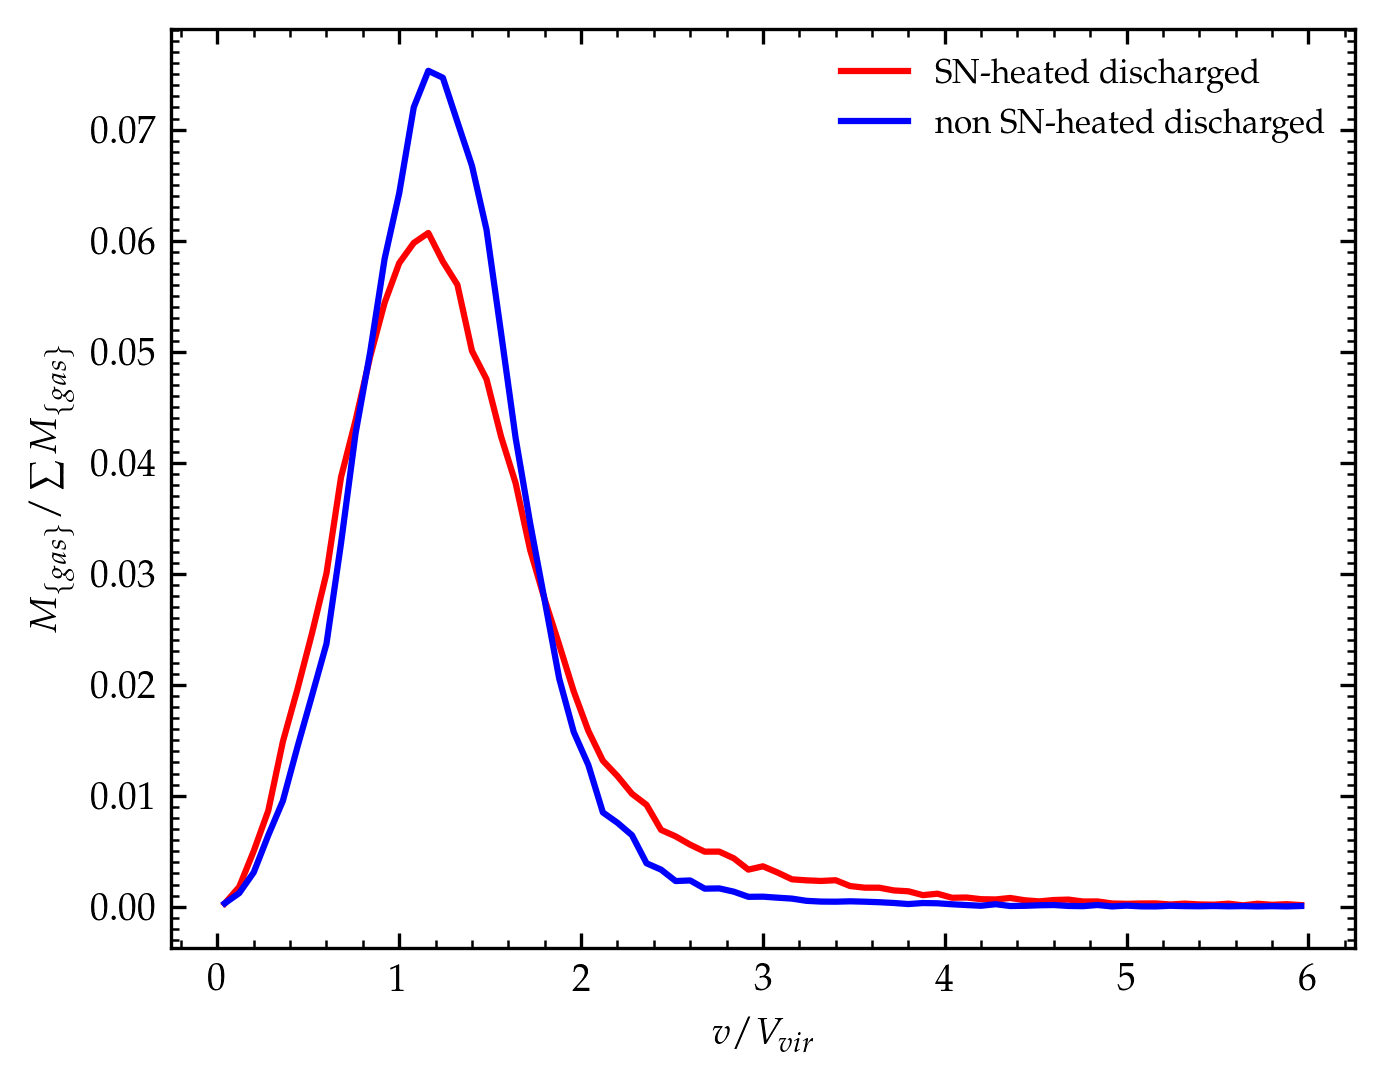

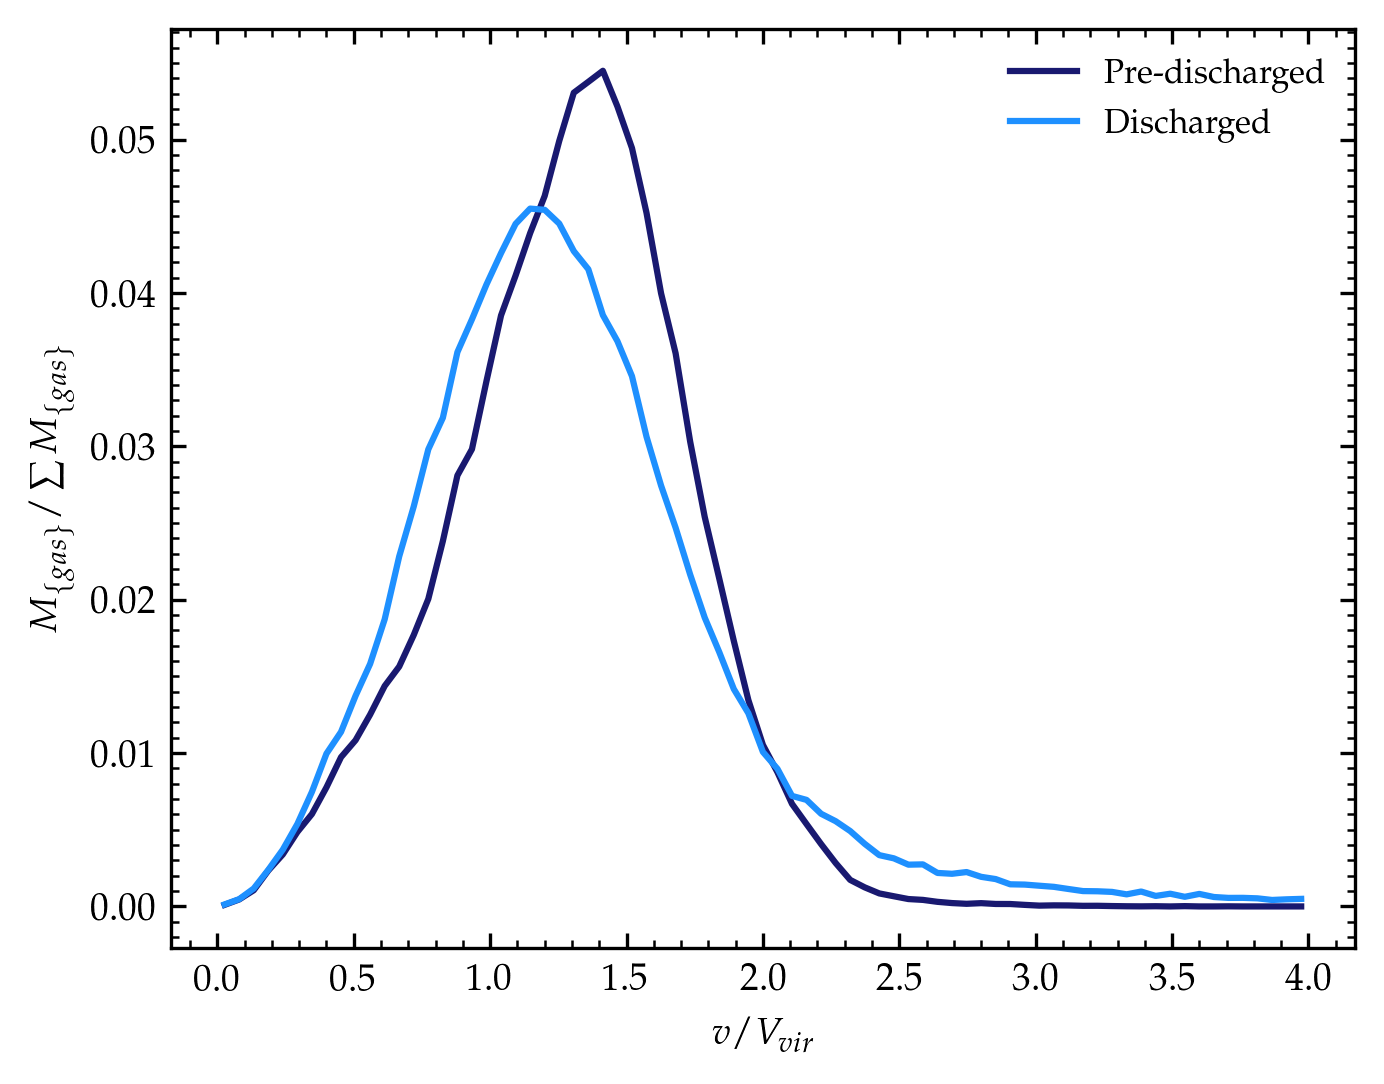

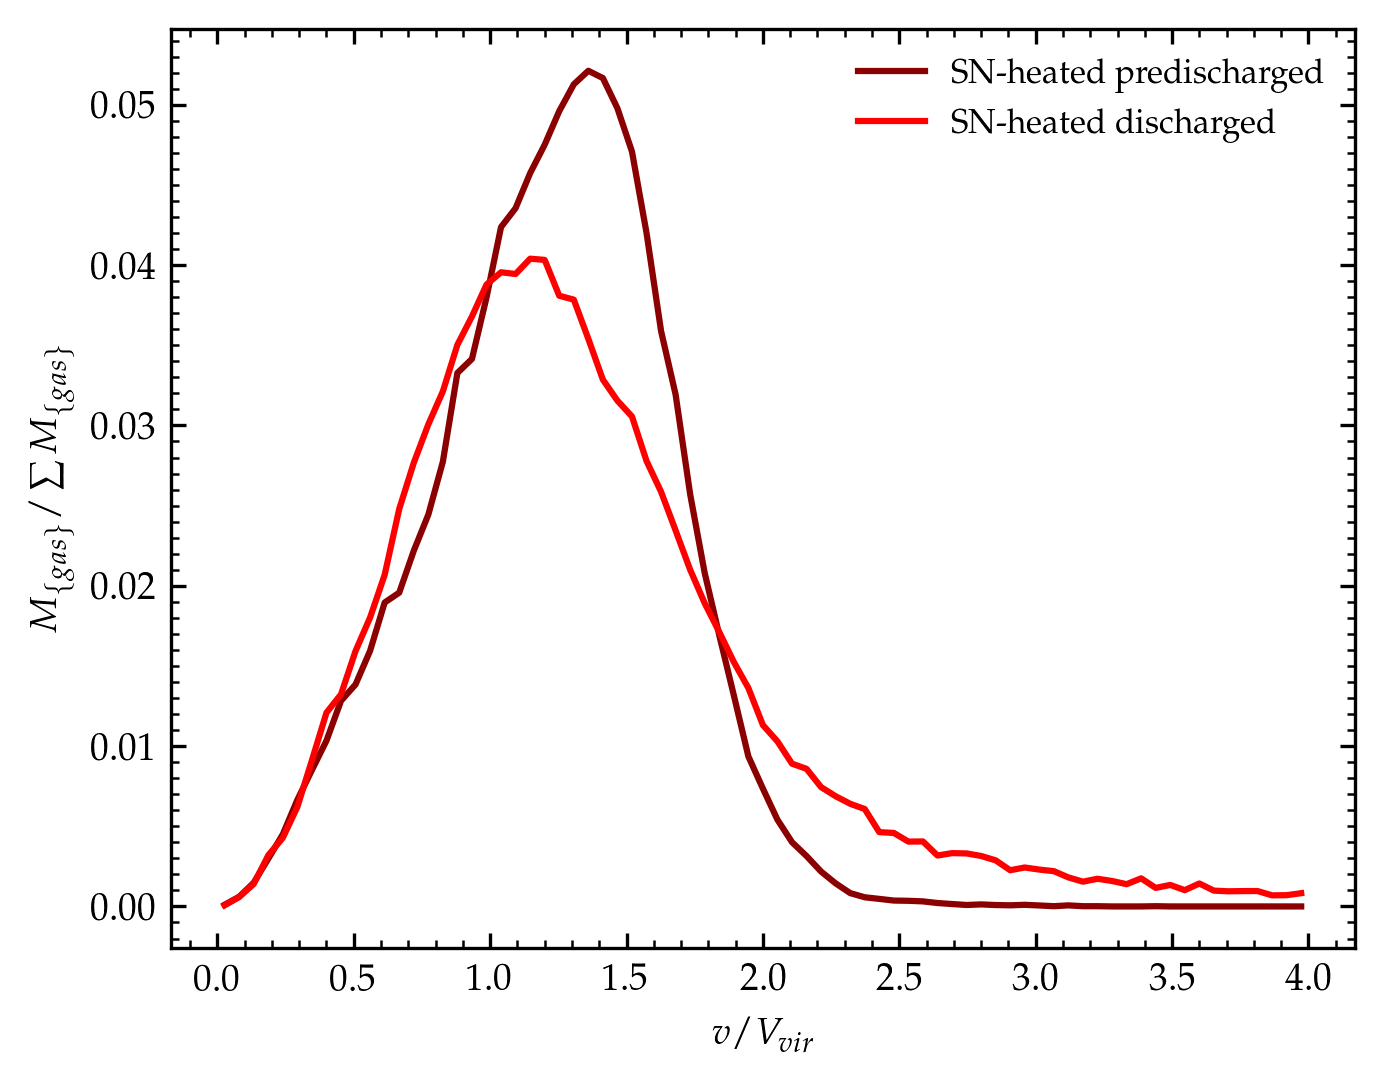

In [15]:
##### plotting all unheated vs. SN-heated, discharged gas #####
bins = 75
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(4.5,3.5), constrained_layout=True)

y1, x = np.histogram(hot.v_per_Vvir, bins=bins, weights=wt(hot),
                     range=(0, 6.0))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='SN-heated discharged', color='r')
print(np.sum(y1))

y2, x = np.histogram(cold.v_per_Vvir, bins=bins, weights=wt(cold),
                     range=(0, 6.0))
print(np.sum(y2))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y2, label='non SN-heated discharged', color='b')


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

# ax.set_title('$v/V_{vir}$ Distributions for Discharged Gas', fontsize='medium')
ax.set_xlabel(r'$v/V_{vir}$')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
# ax.set_xlim(-50,150)
# ax.set_ylim(-0.0025,0.08)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.001))
 
ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)

##plt.savefig('plots/vPerVvir_h148_10_SN.pdf')



##### plotting all discharged vs. gas pre-discharge #####
# bins = 75
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(4.5,3.5), constrained_layout=True)

y1, x = np.histogram(predischarged.v_per_Vvir, bins=bins, weights=wt(predischarged),
                     range=(0, 4.0))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Pre-discharged', color='midnightblue')

y1, x = np.histogram(discharged.v_per_Vvir, bins=bins, weights=wt(discharged), range=(0, 4.0))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Discharged', color='dodgerblue')


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

# ax.set_title('(a) $v/V_{vir}$ Dist. for Unheated Gas Pre/Post-discharge',
#              fontsize='medium')
ax.set_xlabel(r'$v/V_{vir}$')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
# ax.set_xlim(-50,150)
#ax.set_ylim(-0.0025,0.035)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.001))
 
ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)

##plt.savefig('plots/vPerVvir_h148_10_disc.pdf')



##### plotting SN-heated pre-discharged vs. SN-heated discharged gas #####
# bins = 75
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(4.5,3.5), constrained_layout=True)

y1, x = np.histogram(hot_predischarged.v_per_Vvir, bins=bins,
                     weights=wt(hot_predischarged), range=(0, 4.0))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='SN-heated predischarged', color='darkred')

y1, x = np.histogram(hot.v_per_Vvir, bins=bins, weights=wt(hot), range=(0, 4.0))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='SN-heated discharged', color='red')


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

# ax.set_title('(b) $v/V_{vir}$ Dist. for SN-heated Gas Pre/Post-discharge',
#              fontsize='medium')
ax.set_xlabel(r'$v/V_{vir}$')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
# ax.set_xlim(-50,150)
#ax.set_ylim(-0.0025,0.035)


ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.001))
 
ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)

##plt.savefig('plots/vPerVvir_h148_10_pre.pdf')

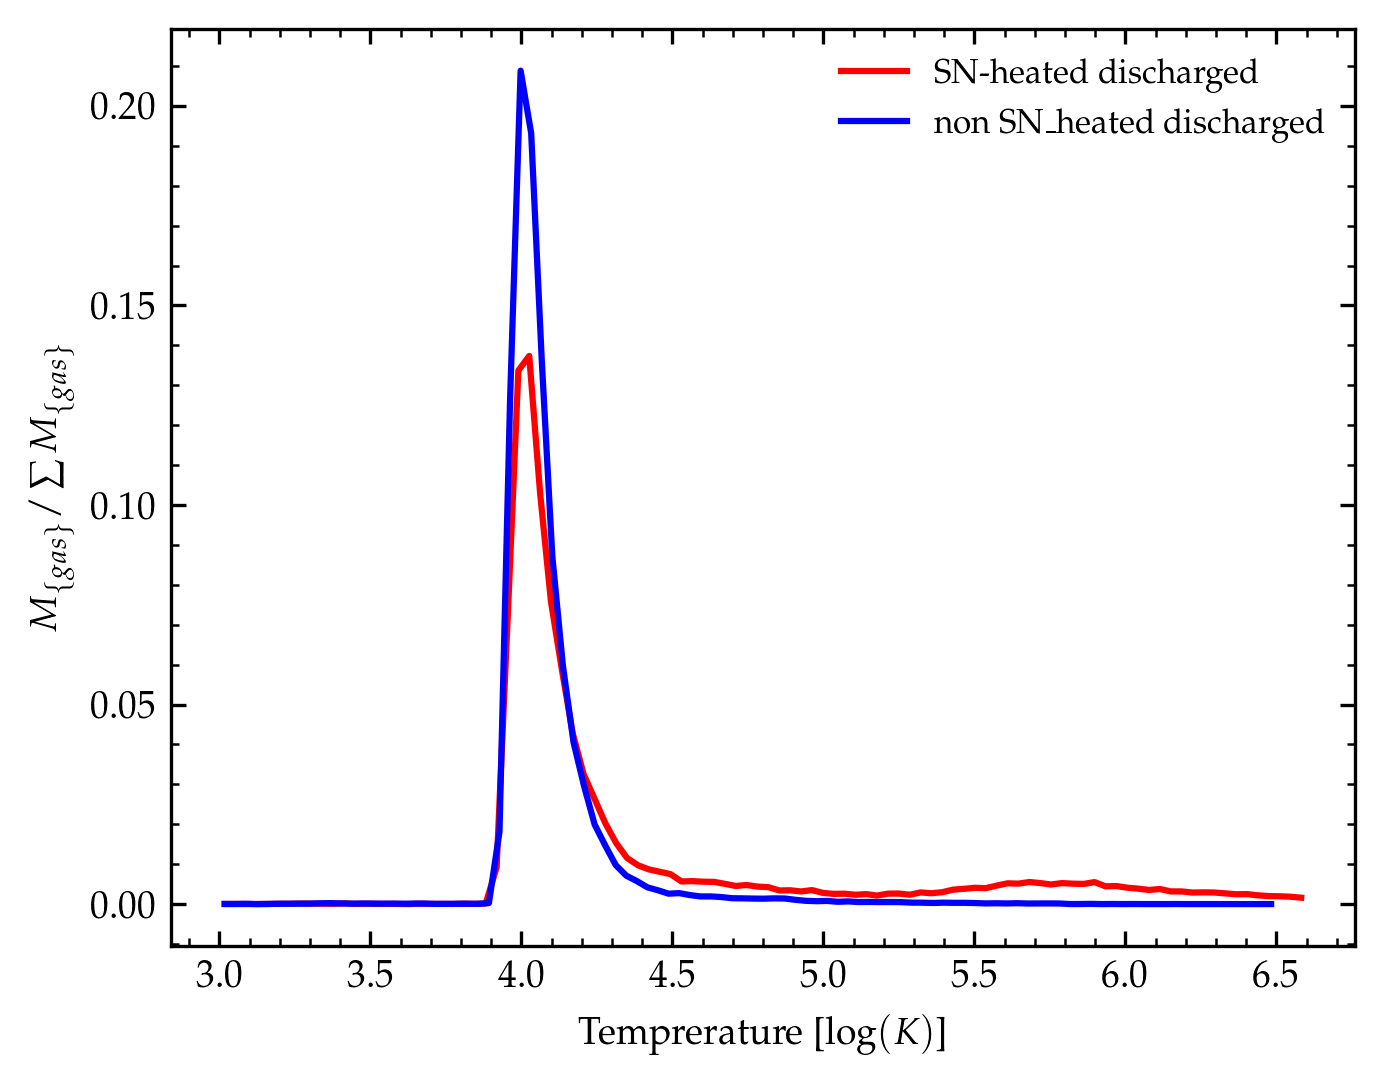

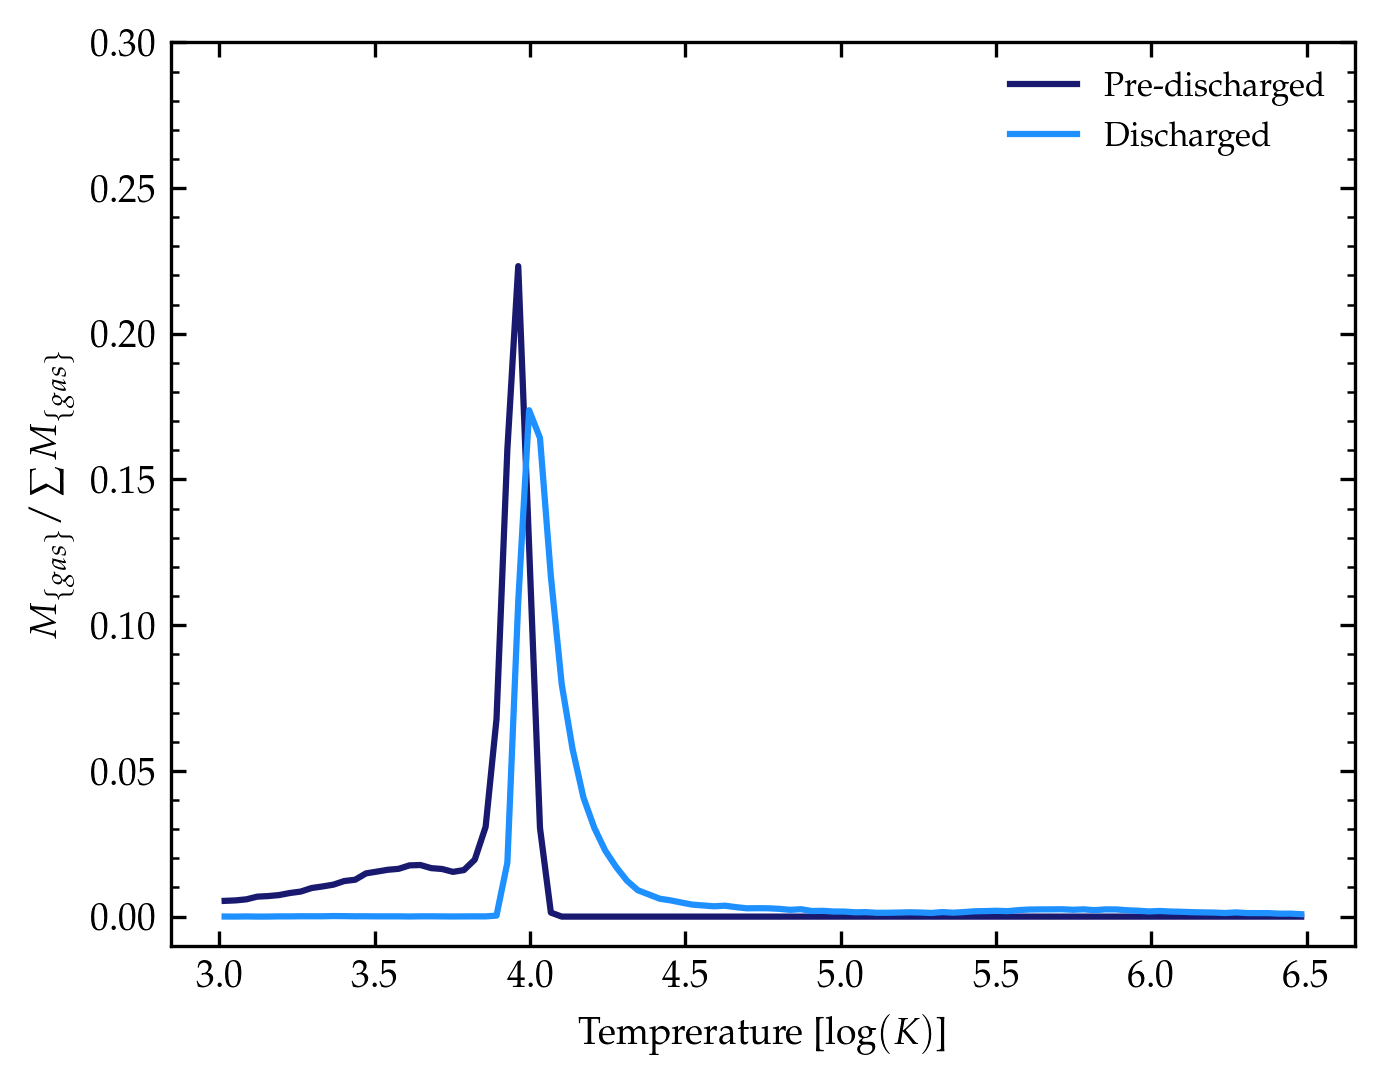

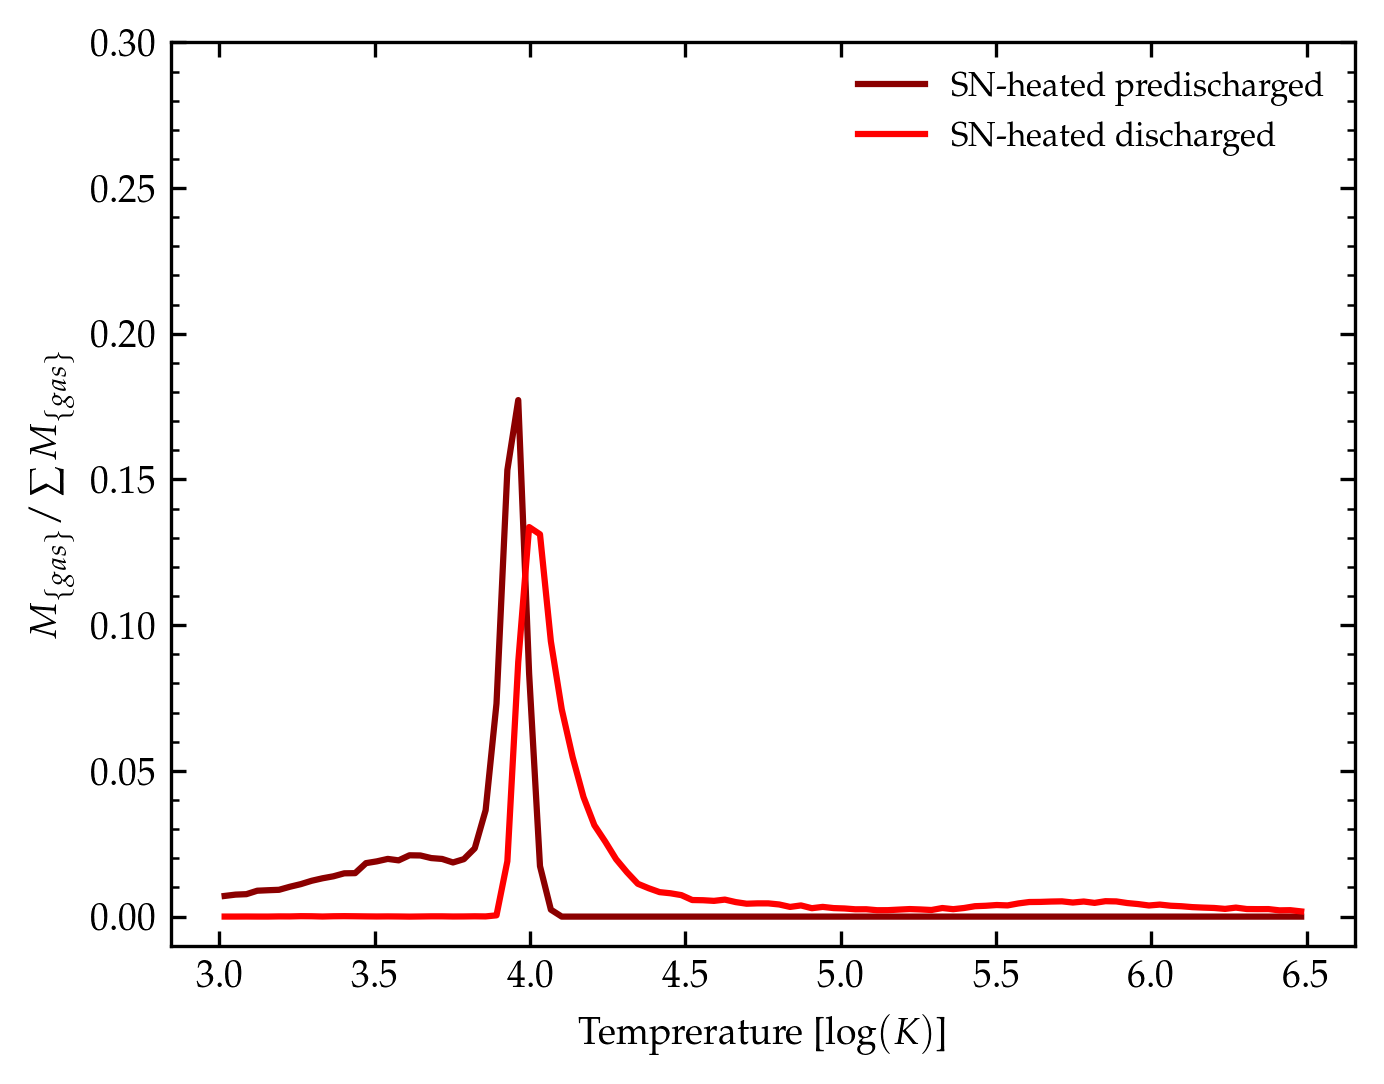

In [32]:
# temperature distribution

##### plotting discharged vs. heated gas #####
bins = 100
fig, ax = plt.subplots(1,1,dpi=300, figsize=(4.5,3.5), constrained_layout=True)

y1, x = np.histogram(np.log10(hot.temp), bins=bins, weights=wt(hot), range=(3.0,6.6))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='SN-heated discharged', c='r')

y2, x = np.histogram(np.log10(cold.temp), bins=bins, weights=wt(cold), range=(3.0,6.5))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y2, label='non SN_heated discharged', c='b')


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

# ax.set_title('Discharged Gas Temperature Distributions', fontsize='medium')
ax.set_xlabel(r'Temprerature [$\log(K)$]')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')

# ax.set_xlim(3,8)
#ax.set_ylim(-0.01,0.165)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)

plt.savefig('plots/T_dist_h148_10_SN.pdf')



##### plotting unheated discharged vs. pre-discharged gas #####
fig, ax = plt.subplots(1,1,dpi=300, figsize=(4.5,3.5), constrained_layout=True)

y1, x = np.histogram(np.log10(predischarged.temp), bins=bins, weights=wt(predischarged),
                     range=(3,6.5))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Pre-discharged', c='midnightblue')

y1, x = np.histogram(np.log10(discharged.temp), bins=bins, weights=wt(discharged), range=(3,6.5))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Discharged', c='dodgerblue')


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

# ax.set_title('(a) Unheated Gas Temperature Distributions', fontsize='medium')
ax.set_xlabel(r'Temprerature [$\log(K)$]')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')

# ax.set_xlim(2,7)
ax.set_ylim(-0.01,0.3)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(10))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)

plt.savefig('plots/T_dist_h148_10_disc.pdf')



##### plotting pre-discharge heated vs. heated gas #####
# bins = 100
fig, ax = plt.subplots(1,1,dpi=300, figsize=(4.5,3.5), constrained_layout=True)

y1, x = np.histogram(np.log10(hot_predischarged.temp), bins=bins,
                     weights=wt(hot_predischarged), range=(3,6.5))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='SN-heated predischarged', c='darkred')

y1, x = np.histogram(np.log10(hot.temp), bins=bins, weights=wt(hot), range=(3,6.5))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='SN-heated discharged', c='r')


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

# ax.set_title('(b) SN-heated Gas Temperature Distributions', fontsize='medium')
ax.set_xlabel(r'Temprerature [$\log(K)$]')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
# ax.set_xlim(2,8)
ax.set_ylim(-0.01,0.3)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(10))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))
ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)

plt.savefig('plots/T_dist_h148_10_pre.pdf')
plt.show()

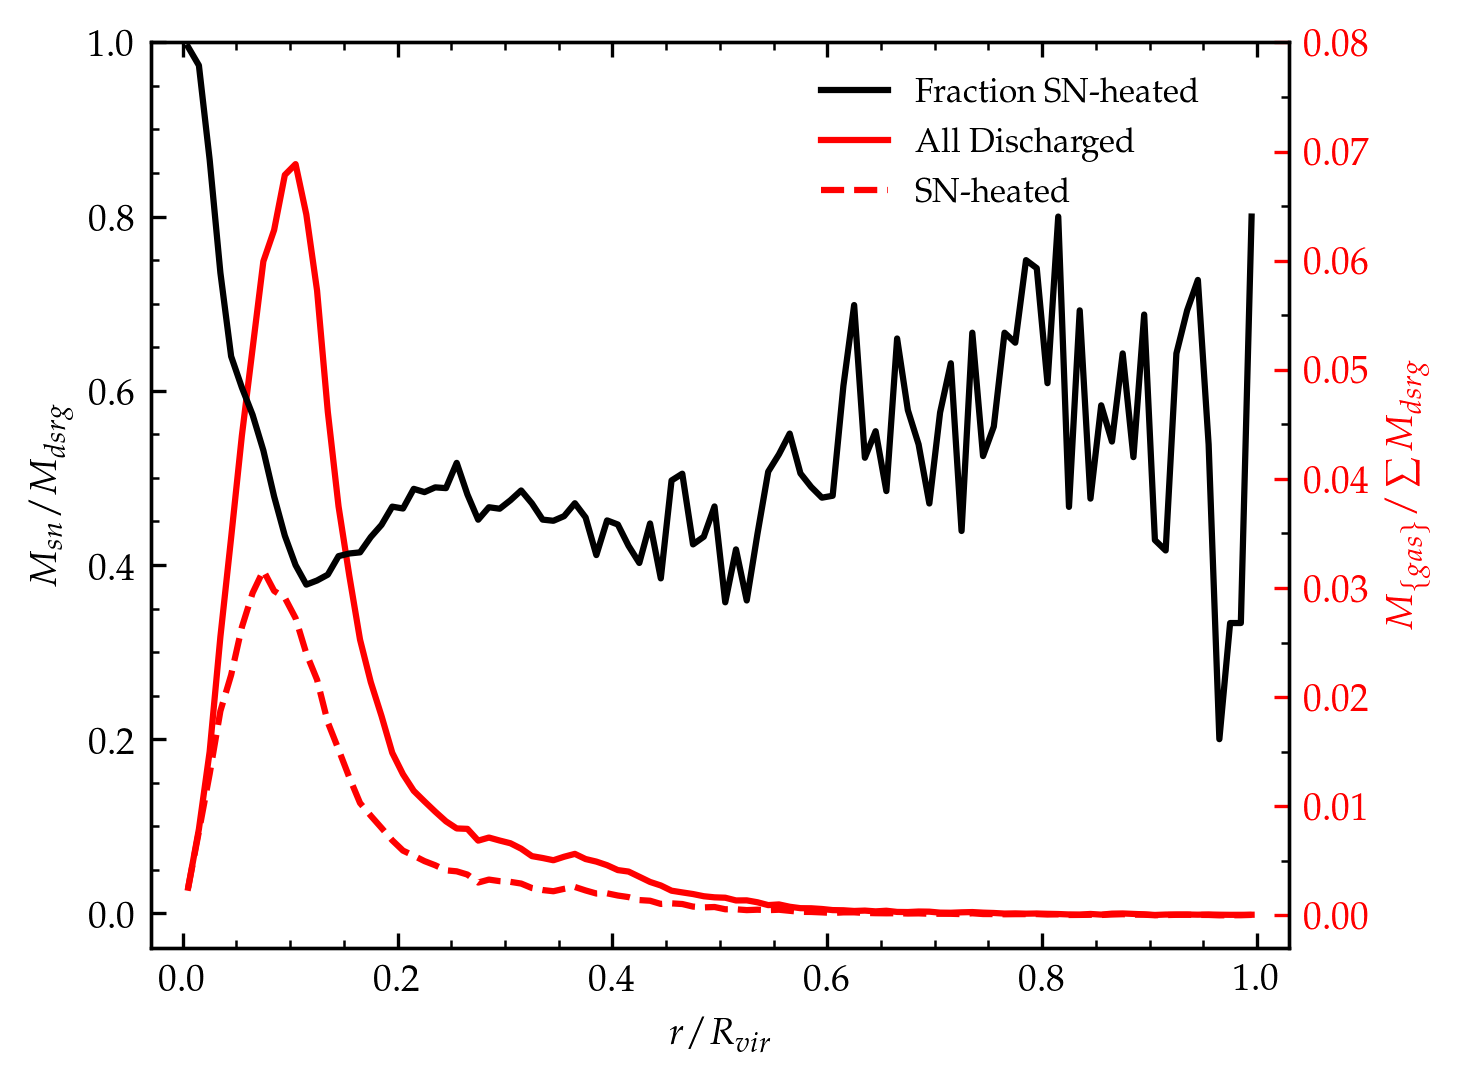

In [9]:
bins = 100
rangemax = 1.0

# assigning particles in each set to equal sets of bins.

# all discharged gas.
post, x = np.histogram(discharged.r_per_Rvir, bins=bins, range=(0,rangemax))

# SN-heated, discharged.
postHot, x = np.histogram(hot.r_per_Rvir, bins=bins, range=(0,rangemax))


# computing fraction heated/all at each radial position.
sn_ratio = np.array([])

for i in range(0, bins):
    ratio = postHot[i]/post[i]
    sn_ratio = np.append(sn_ratio, ratio)
    i += 1


### plotting fractions heated/discharged for different r/Rvir bins ###
# ax1 = plot of heated/discharged ratios;
# ax2 = plot for percent mass of discharged and SN-heated, discharged gas, respectively, 
# at different r/Rvir.
fig, ax1 = plt.subplots(1, 1, dpi=300, figsize=(4.75,3.5), constrained_layout=True)
ax2 = ax1.twinx()

# fraction sne/all:
bincenters = 0.5*(x[1:] + x[:-1])
ax1.plot(bincenters, sn_ratio, label='Fraction SN-heated', c='black')

# mass distributions:
y1, x = np.histogram(discharged.r_per_Rvir, bins=bins, weights=wt(discharged),
                     range=(0,rangemax))
bincenters = 0.5*(x[1:] + x[:-1])
ax2.plot(bincenters, y1, label='All Discharged', c='red')

y1, x = np.histogram(hot.r_per_Rvir, bins=bins, weights=wt(hot,discharged),
                     range=(0,rangemax))
bincenters = 0.5*(x[1:] + x[:-1])
ax2.plot(bincenters, y1, label='SN-heated', c='red', linestyle='--')


# ax1.set_title('Fraction of Discharged Gas SN-heated over Radial Distance',
#               fontsize='small')
ax1.set_xlabel(r'$r/R_{vir}$')
ax1.set_ylabel('% SN-heated')
ax1.set_ylabel('$M_{sn} / M_{dsrg}$')
ax2.set_ylabel('$M_{\{gas\}} / \sum M_{dsrg}$', color='red')

fig.legend(frameon=False, fontsize='8', bbox_to_anchor=(0.85, 0.97))

ax1.set_zorder(2)
ax2.set_zorder(1)
ax1.patch.set_visible(False)

ax1.set_xlim(-0.03,1.03)
ax1.set_ylim(-0.04,1)
ax2.set_ylim(-0.003,0.08)

ax1.tick_params(direction='in',which='both',top=True)
ax1.tick_params(axis ='y') 
ax2.tick_params(axis ='y', colors='red')
ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax1.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax2.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.005))

ax1.ticklabel_format(axis="y", style="plain",scilimits=(0,0))

plt.savefig('plots/sn_fraction_h148_10.pdf')

plt.show()

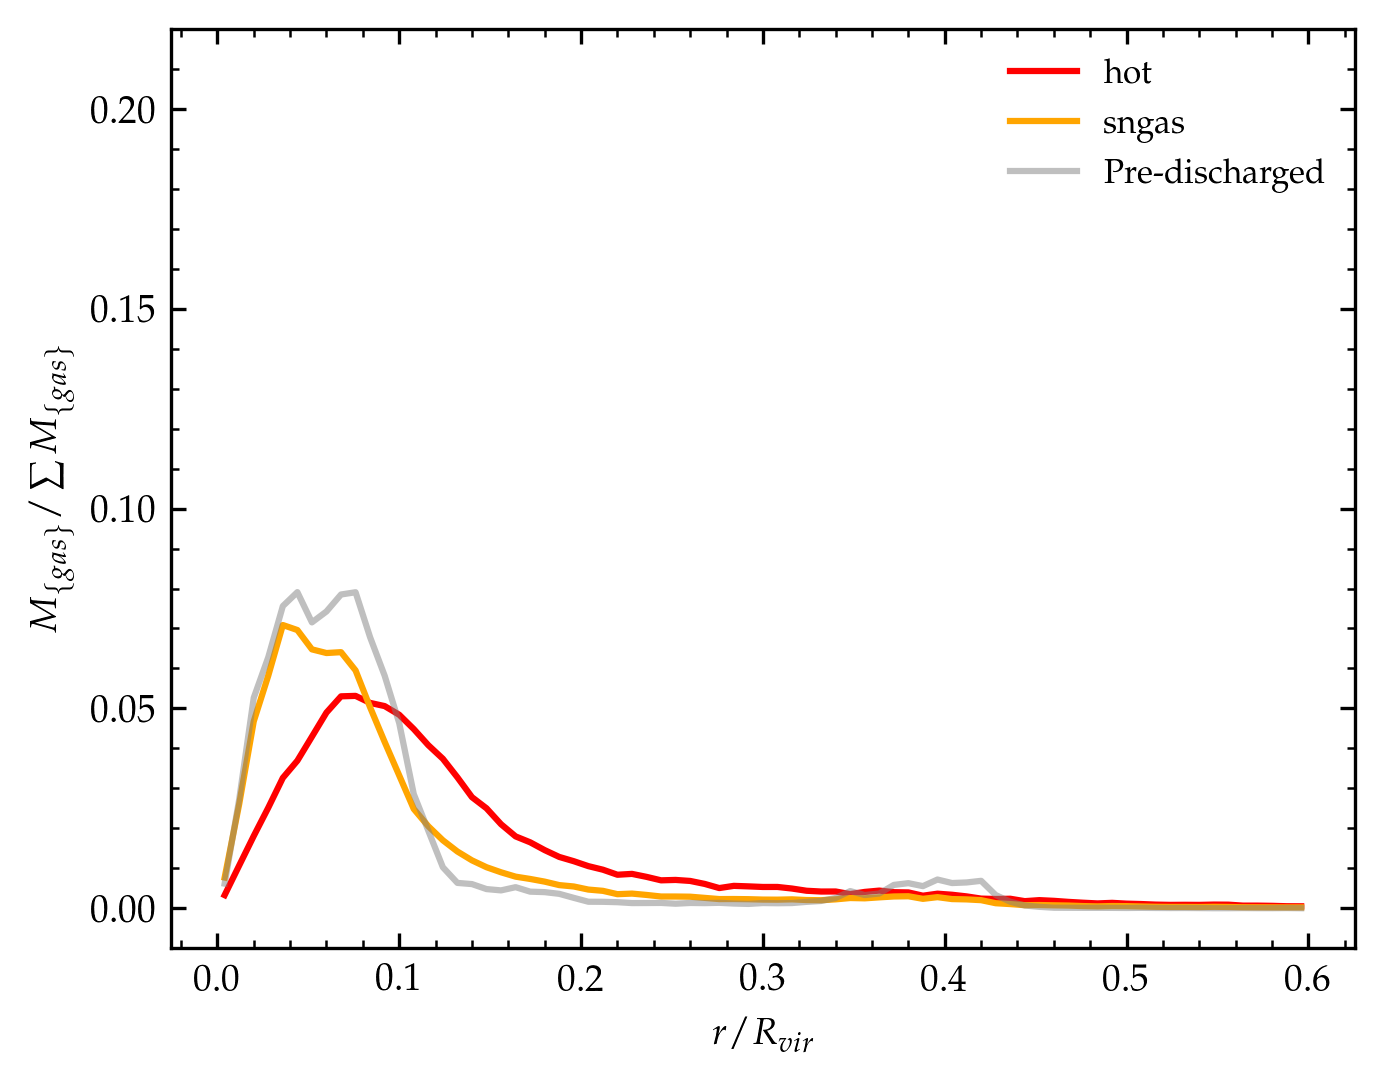

In [17]:
##test sngas and hot distance distribution

##### plotting unheated vs. heated discharged gas #####
bins = 75
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(4.5,3.5), constrained_layout=True)

y1, x = np.histogram(hot.r_per_Rvir, bins=bins, weights=wt(hot), range=(0, 0.6))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='hot', color='r')

y2, x = np.histogram(sngas.r_per_Rvir, bins=bins, weights=wt(sngas), range=(0, 0.6))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y2, label='sngas', color='orange')

y3, x = np.histogram(predischarged.r_per_Rvir, bins=bins, weights=wt(predischarged),
                     range=(0, 0.6))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y3, label='Pre-discharged', linestyle='-', color='grey', alpha=0.5)


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

# ax.set_title('(a) Discharged Gas Radial Position Distributions', fontsize='medium')
ax.set_xlabel(r'$r/R_{vir}$')
plt.ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
# ax.set_xlim(0,1)
ax.set_ylim(-0.01,0.22)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.02))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))


ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)

'sngas' dataset aren't correctly calculate the SN-heated gas. Therefore, I will not use it for future analysis.

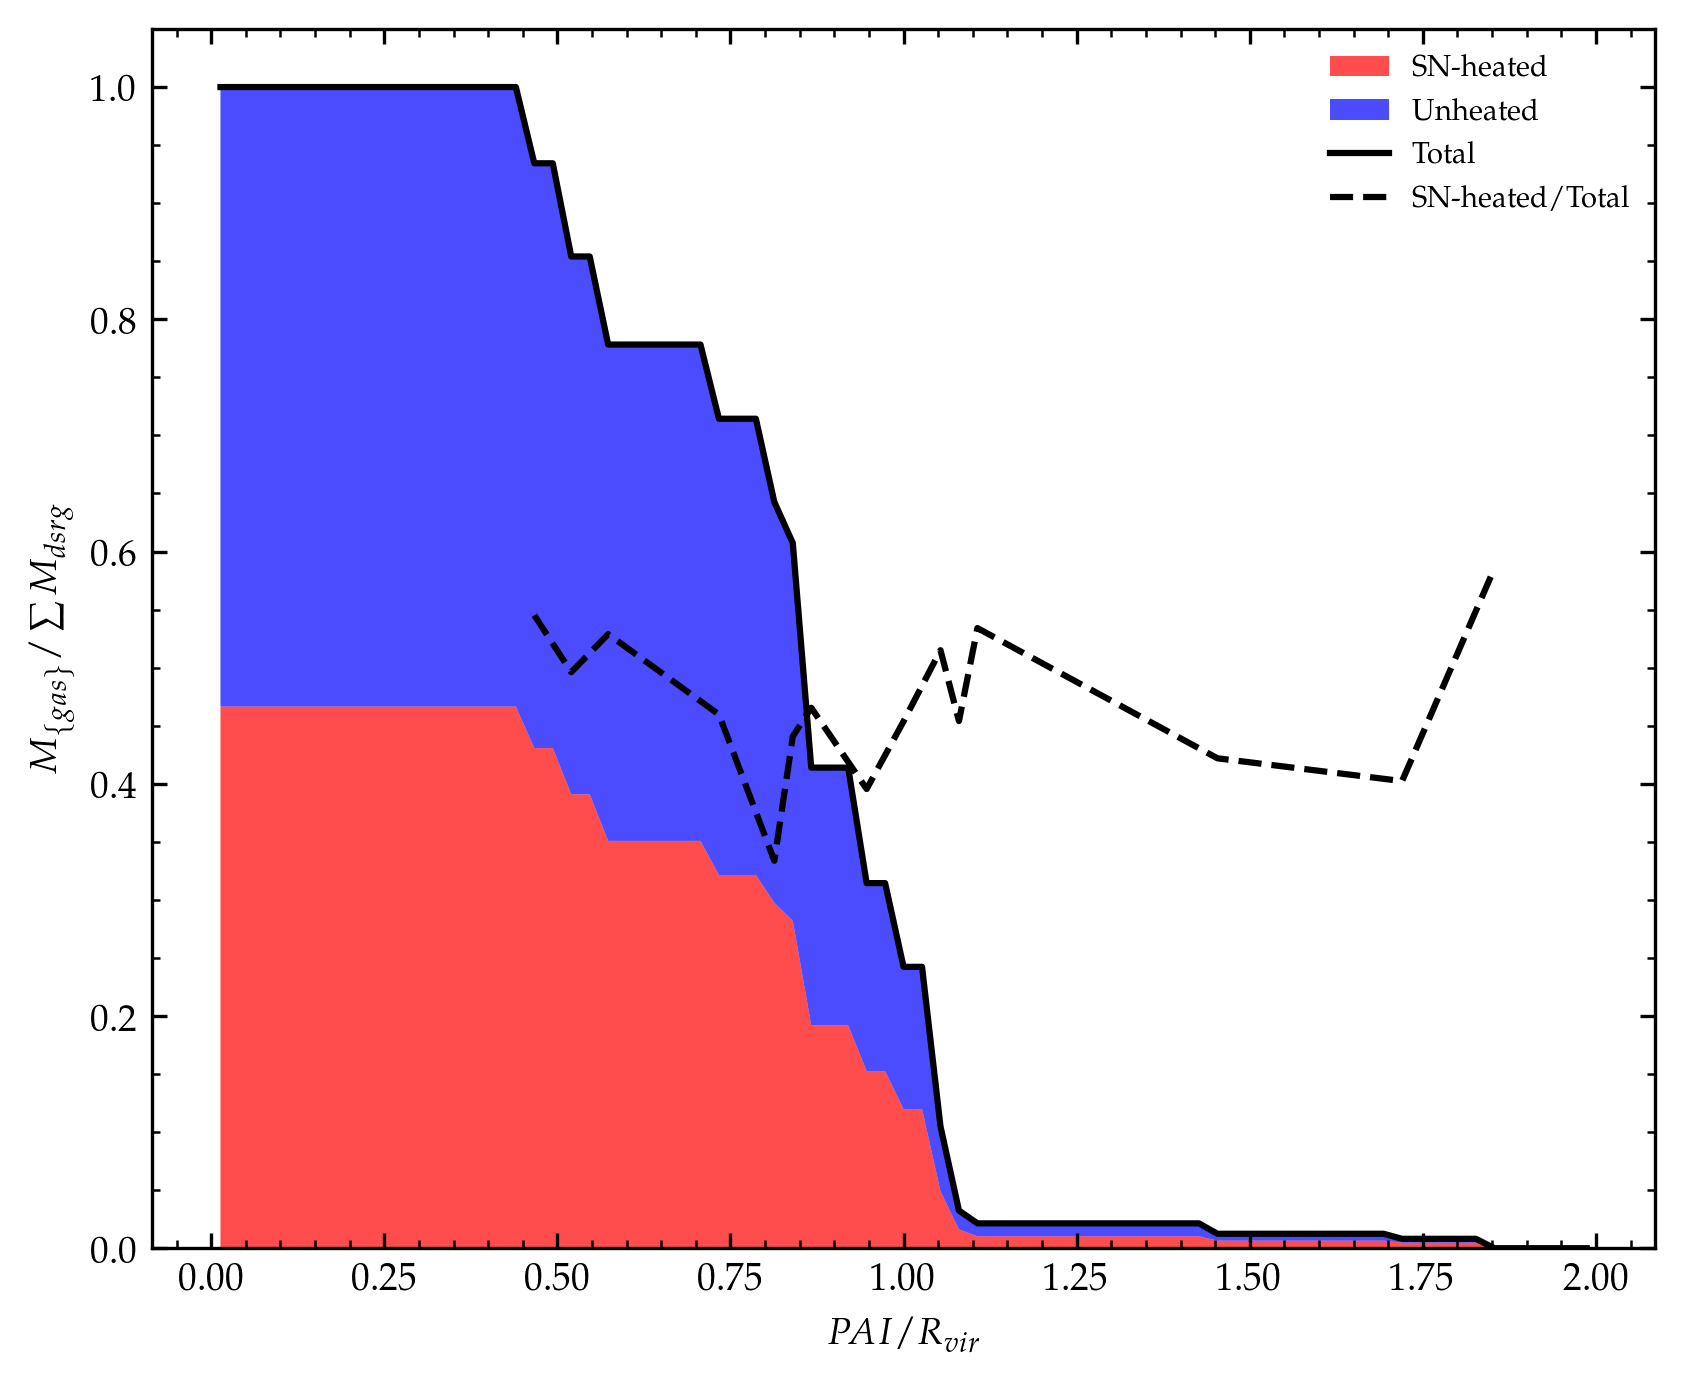

In [19]:
# identifying where discharged gas is removed to as a function of PAI.
bins = 75
fig, ax = plt.subplots(1,1, dpi=300, figsize=(5.5,4.5), sharex=True,
                       constrained_layout=False)

y1, x = np.histogram(pai(hot), bins=bins, weights=wt(hot,discharged),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)
y2, x = np.histogram(pai(cold), bins=bins, weights=wt(cold,discharged),
                     range=(0, 2))
sum2 = np.cumsum(y2)
ax.stackplot(bincenters, sum1[-1]-sum1, sum2[-1]-sum2, alpha=0.7,
             colors=['r', 'b'], labels=['SN-heated', 'Unheated'])         

y3, x = np.histogram(pai(discharged), bins=bins, weights=wt(discharged),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum3 = np.cumsum(y3)
ax.plot(bincenters, sum3[-1]-sum3, alpha=1.0, c='black', label='Total')

ax.plot(bincenters[y3>0], (y1/y3)[y3>0], linestyle='--', c='black',
        label='SN-heated/Total')

# ax.set_title('Gas Discharged Over Infall Distances', fontsize='medium')
ax.set_xlabel(r'$PAI / R_{vir}$')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{dsrg}$')
# # ax[1].set_xlim(-0.1,4)
# ax[1].set_ylim(0,0.2)

ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
# ax.grid(alpha=0.1, zorder=-1000)

ax.legend(frameon=False, fontsize=7)

plt.savefig('plots/PAIperRvir_h148_10.pdf')
plt.show()

Just realized how big the portion of SN-heated gas loss is. Maybe this satellite is helpful to truly understand the unique characteristics of SN-heated gas.

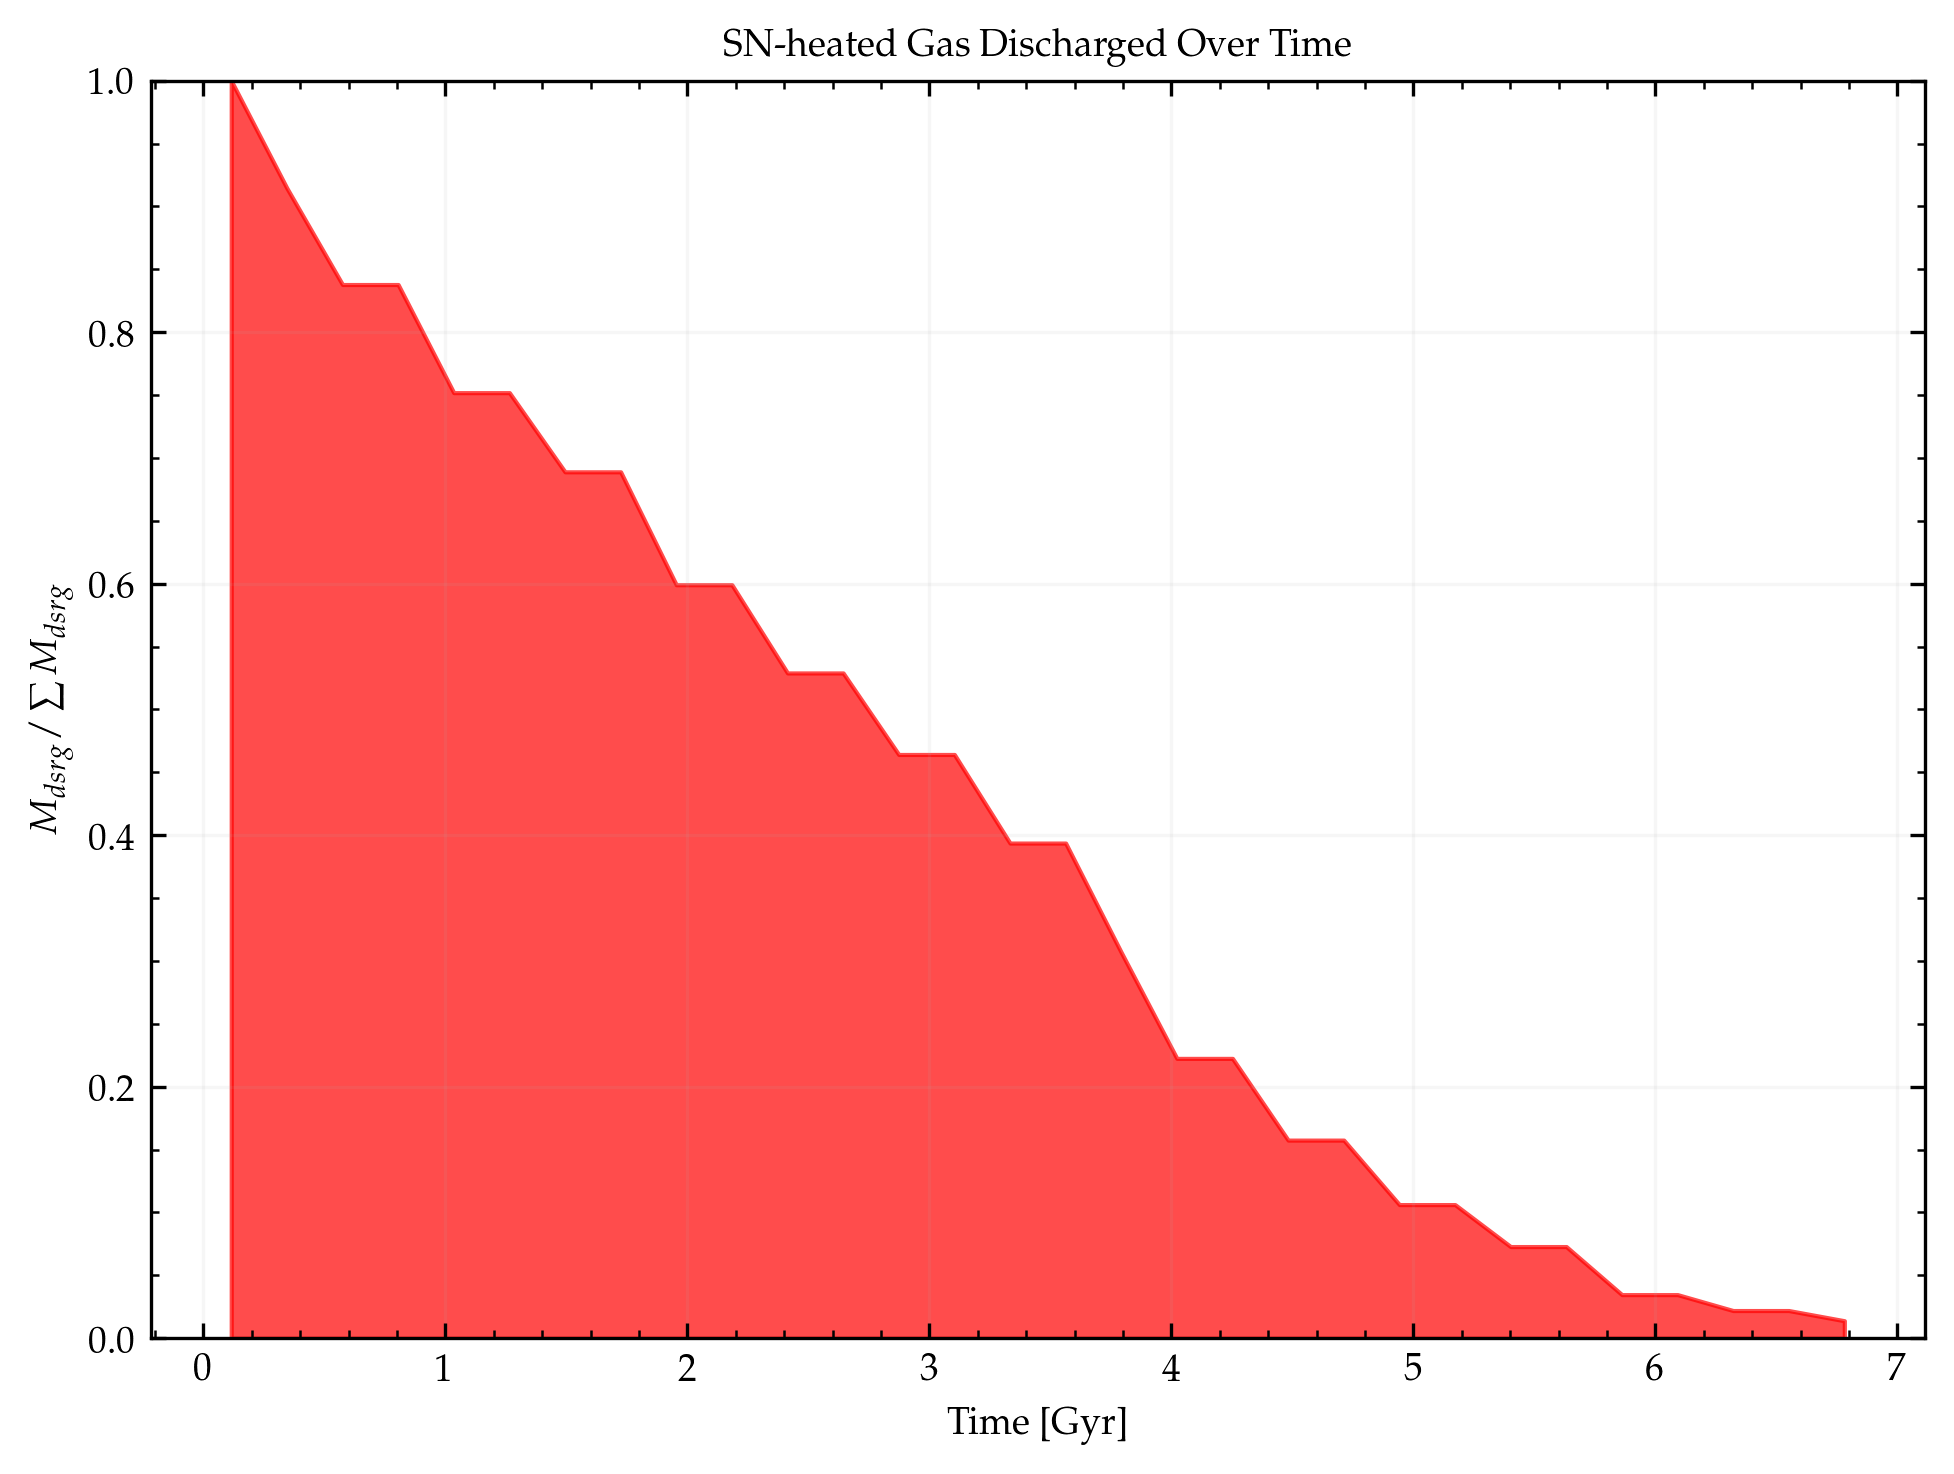

In [27]:
bins = 30
fig, ax = plt.subplots(1, 1, dpi=300, constrained_layout=True)

y1, x = np.histogram(hot.time, bins=bins, weights=wt(hot))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)
     
ax.stackplot(13.8007975-bincenters, sum1, alpha=0.7, color='r')    

ax.set_title('SN-heated Gas Discharged Over Time',
              fontsize='medium')
                                                                                    
ax.grid(alpha=0.1, zorder=-1000)

ax.set_xlabel('Time [Gyr]')
ax.set_ylabel('$M_{dsrg} / \sum M_{dsrg}$')
ax.set_ylim(0,1)
                                                                                    
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))

plt.savefig('plots/PAIperRvir_snfrac_h148_10.pdf')
plt.show()

## Import all data

In [16]:
# importing all data.
predischarged, discharged = read_all_discharged() # hot_predischarged, 
## all_accreted, reaccreted = read_accreted()

# gas SN-heated/unheated prior to discharge.
hot = discharged[discharged['snHeated']==True]  # heated.
cold = discharged[discharged['snHeated']==False]  # unheated.

found the keys, starting with:  h148_10
> Returning (predischarged, discharged) for all satellites <


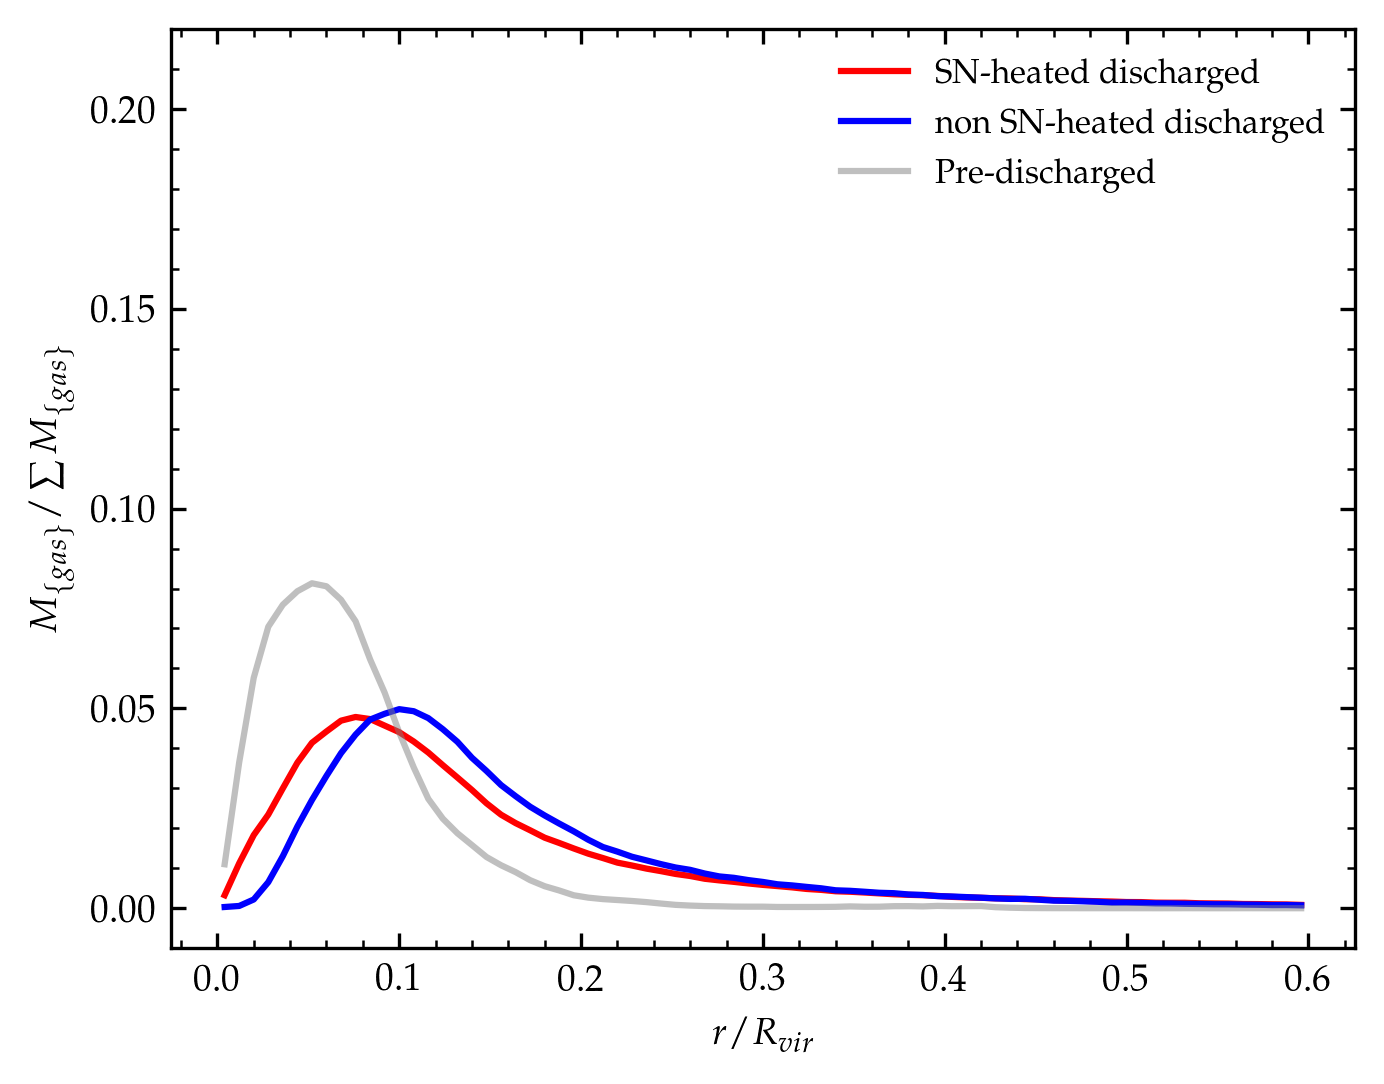

In [17]:
##### plotting unheated vs. heated discharged gas #####
bins = 75
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(4.5,3.5), constrained_layout=True)

y1, x = np.histogram(hot.r_per_Rvir, bins=bins, weights=wt(hot), range=(0, 0.6))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='SN-heated discharged', color='r')

y2, x = np.histogram(cold.r_per_Rvir, bins=bins, weights=wt(cold), range=(0, 0.6))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y2, label='non SN-heated discharged', color='b')

y3, x = np.histogram(predischarged.r_per_Rvir, bins=bins, weights=wt(predischarged),
                     range=(0, 0.6))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y3, label='Pre-discharged', linestyle='-', color='grey', alpha=0.5)


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

# ax.set_title('(a) Discharged Gas Radial Position Distributions', fontsize='medium')
ax.set_xlabel(r'$r/R_{vir}$')
plt.ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
# ax.set_xlim(0,1)
ax.set_ylim(-0.01,0.22)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.02))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))


ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)

plt.savefig('plots/rPerRvir_all.pdf')

In [18]:
# radial velocity distributions
# velocity is calculated by sqrt(G*M/r_{vir})

# gravitational constant in units of kpc km**2 Msol**-1 s**-2 (matching sim. units).
G = c.G.to('kpc km2 / (M_sun s2)')

# compiling virial velocities for each particle's respective satellite.
# all pre-discharged gas.
pre_vvir = np.sqrt(G * predischarged.sat_Mvir / predischarged.satRvir) 

# all discharged gas.
post_vvir = np.sqrt(G * discharged.sat_Mvir / discharged.satRvir)

# SN-heated, pre-discharged gas.
preHot_vvir = np.sqrt(G * hot_predischarged.sat_Mvir / hot_predischarged.satRvir)

# SN-heated and unheated discharged gas.
hot_vvir = np.sqrt(G * hot.sat_Mvir / hot.satRvir)
cold_vvir = np.sqrt(G * cold.sat_Mvir / cold.satRvir)

In [19]:
# creating callable key for effective velocity.
predischarged['v_per_Vvir'] = predischarged.v / pre_vvir
discharged['v_per_Vvir'] = discharged.v / post_vvir

hot_predischarged['v_per_Vvir'] = hot_predischarged.v / preHot_vvir
hot['v_per_Vvir'] = hot.v / hot_vvir
cold['v_per_Vvir'] = cold.v / cold_vvir

0.9966948800150361
0.9945009341140997


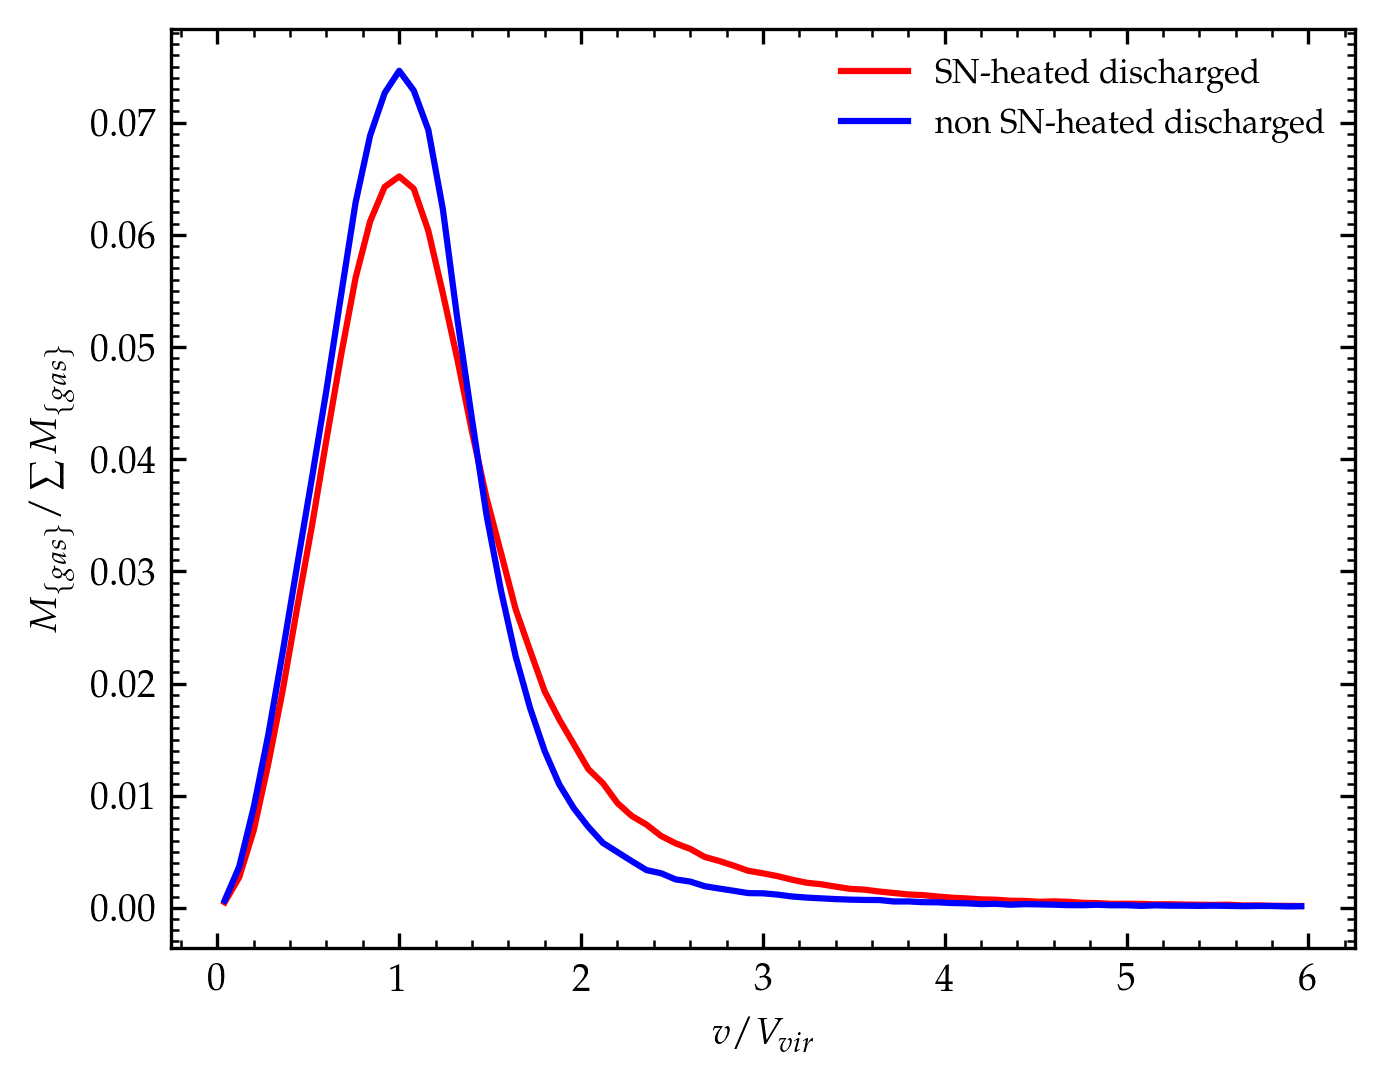

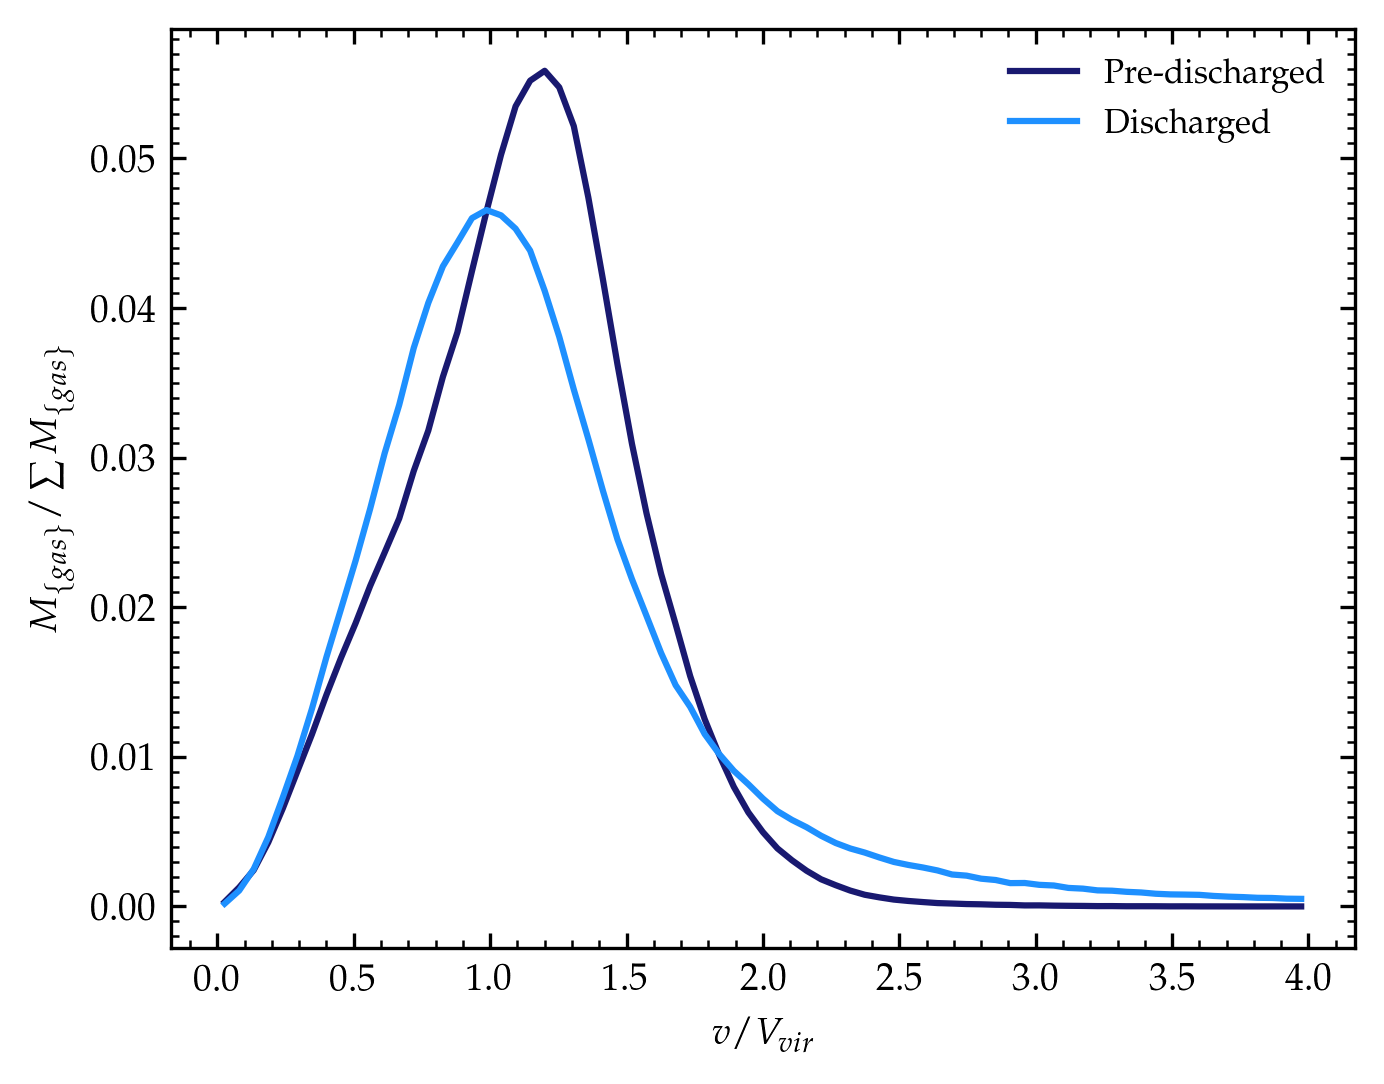

In [20]:
##### plotting all unheated vs. SN-heated, discharged gas #####
bins = 75
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(4.5,3.5), constrained_layout=True)

y1, x = np.histogram(hot.v_per_Vvir, bins=bins, weights=wt(hot),
                     range=(0, 6.0))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='SN-heated discharged', color='r')
print(np.sum(y1))

y2, x = np.histogram(cold.v_per_Vvir, bins=bins, weights=wt(cold),
                     range=(0, 6.0))
print(np.sum(y2))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y2, label='non SN-heated discharged', color='b')


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

# ax.set_title('$v/V_{vir}$ Distributions for Discharged Gas', fontsize='medium')
ax.set_xlabel(r'$v/V_{vir}$')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
# ax.set_xlim(-50,150)
# ax.set_ylim(-0.0025,0.08)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.001))
 
ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)

plt.savefig('plots/vPerVvir_all_SN.pdf')



##### plotting all discharged vs. gas pre-discharge #####
# bins = 75
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(4.5,3.5), constrained_layout=True)

y1, x = np.histogram(predischarged.v_per_Vvir, bins=bins, weights=wt(predischarged),
                     range=(0, 4.0))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Pre-discharged', color='midnightblue')

y1, x = np.histogram(discharged.v_per_Vvir, bins=bins, weights=wt(discharged), range=(0, 4.0))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Discharged', color='dodgerblue')


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

# ax.set_title('(a) $v/V_{vir}$ Dist. for Unheated Gas Pre/Post-discharge',
#              fontsize='medium')
ax.set_xlabel(r'$v/V_{vir}$')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
# ax.set_xlim(-50,150)
#ax.set_ylim(-0.0025,0.035)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.001))
 
ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)

plt.savefig('plots/vPerVvir_all_disc.pdf')

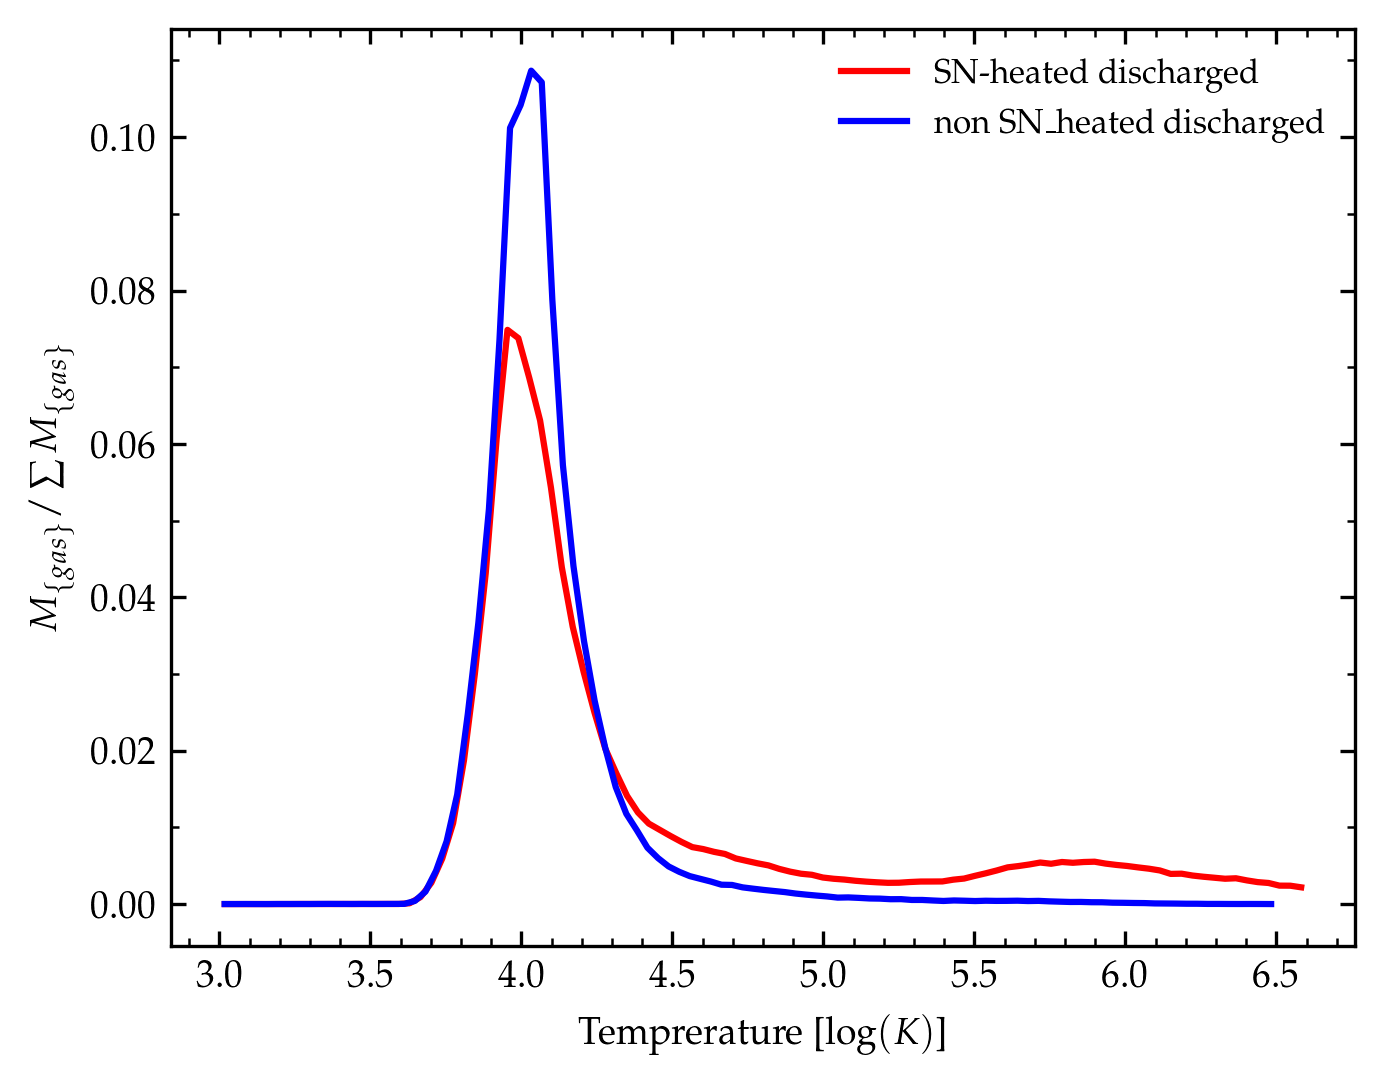

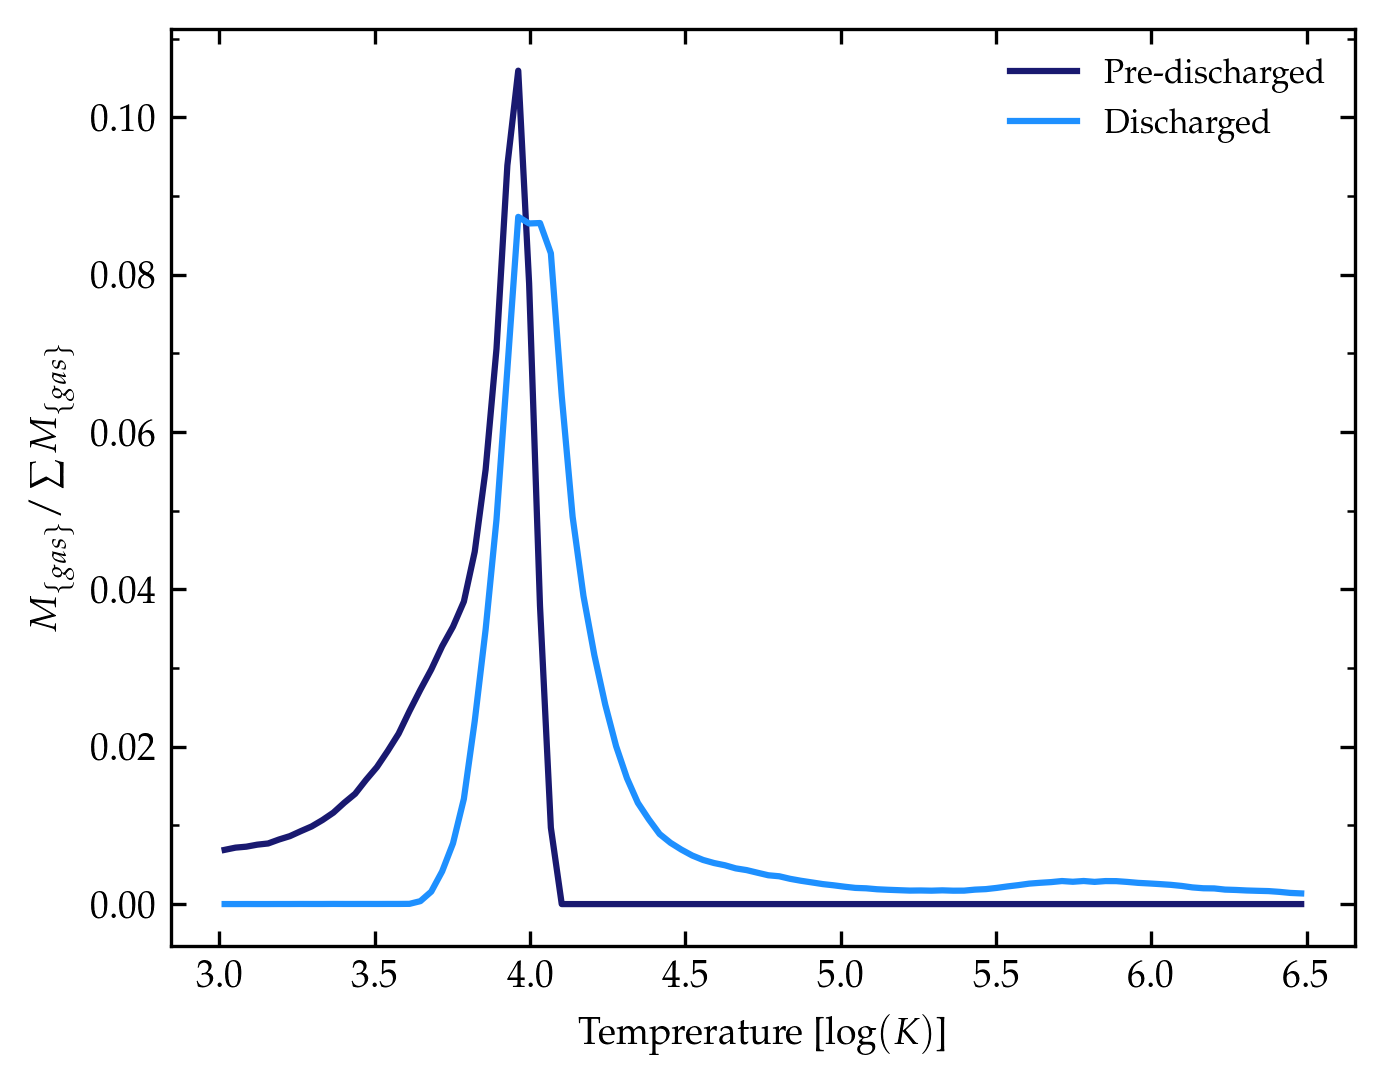

In [21]:
# temperature distribution

##### plotting discharged vs. heated gas #####
bins = 100
fig, ax = plt.subplots(1,1,dpi=300, figsize=(4.5,3.5), constrained_layout=True)

y1, x = np.histogram(np.log10(hot.temp), bins=bins, weights=wt(hot), range=(3.0,6.6))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='SN-heated discharged', c='r')

y2, x = np.histogram(np.log10(cold.temp), bins=bins, weights=wt(cold), range=(3.0,6.5))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y2, label='non SN_heated discharged', c='b')


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

# ax.set_title('Discharged Gas Temperature Distributions', fontsize='medium')
ax.set_xlabel(r'Temprerature [$\log(K)$]')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')

# ax.set_xlim(3,8)
#ax.set_ylim(-0.01,0.165)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)

plt.savefig('plots/T_dist_all_SN.pdf')



##### plotting unheated discharged vs. pre-discharged gas #####
fig, ax = plt.subplots(1,1,dpi=300, figsize=(4.5,3.5), constrained_layout=True)

y1, x = np.histogram(np.log10(predischarged.temp), bins=bins, weights=wt(predischarged),
                     range=(3,6.5))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Pre-discharged', c='midnightblue')

y1, x = np.histogram(np.log10(discharged.temp), bins=bins, weights=wt(discharged), range=(3,6.5))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Discharged', c='dodgerblue')


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

# ax.set_title('(a) Unheated Gas Temperature Distributions', fontsize='medium')
ax.set_xlabel(r'Temprerature [$\log(K)$]')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')

# ax.set_xlim(2,7)
#ax.set_ylim(-0.01,0.3)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(10))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)

plt.savefig('plots/T_dist_all_disc.pdf')
plt.show()

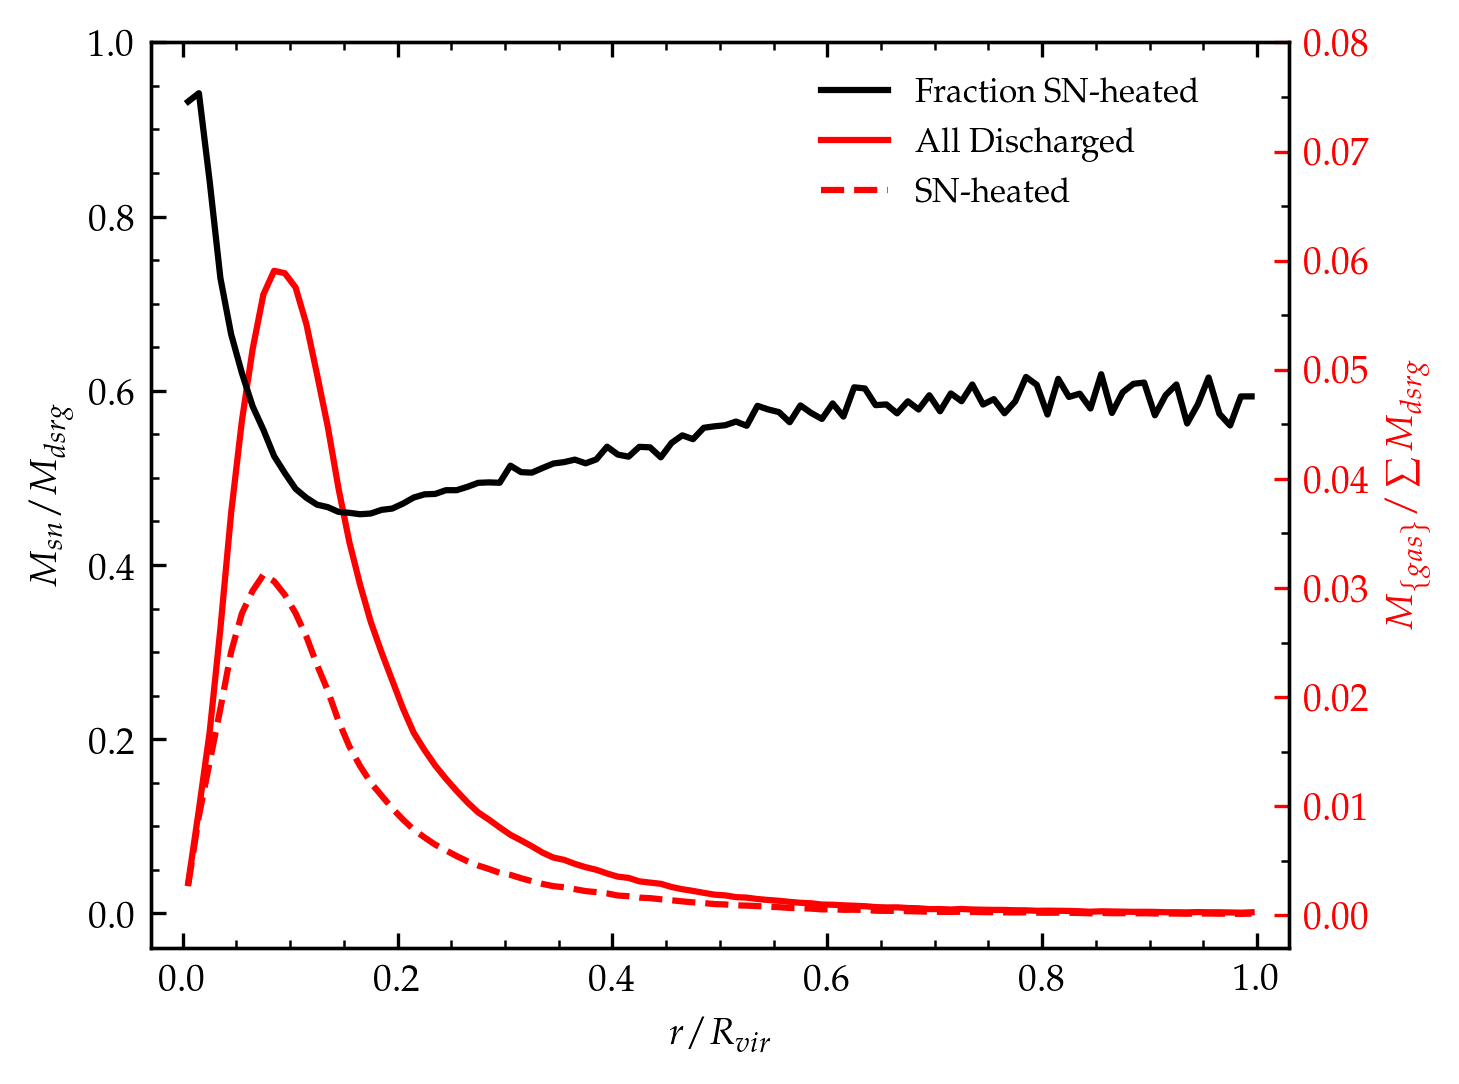

In [22]:
bins = 100
rangemax = 1.0

# assigning particles in each set to equal sets of bins.

# all discharged gas.
post, x = np.histogram(discharged.r_per_Rvir, bins=bins, range=(0,rangemax))

# SN-heated, discharged.
postHot, x = np.histogram(hot.r_per_Rvir, bins=bins, range=(0,rangemax))


# computing fraction heated/all at each radial position.
sn_ratio = np.array([])

for i in range(0, bins):
    ratio = postHot[i]/post[i]
    sn_ratio = np.append(sn_ratio, ratio)
    i += 1


### plotting fractions heated/discharged for different r/Rvir bins ###
# ax1 = plot of heated/discharged ratios;
# ax2 = plot for percent mass of discharged and SN-heated, discharged gas, respectively, 
# at different r/Rvir.
fig, ax1 = plt.subplots(1, 1, dpi=300, figsize=(4.75,3.5), constrained_layout=True)
ax2 = ax1.twinx()

# fraction sne/all:
bincenters = 0.5*(x[1:] + x[:-1])
ax1.plot(bincenters, sn_ratio, label='Fraction SN-heated', c='black')

# mass distributions:
y1, x = np.histogram(discharged.r_per_Rvir, bins=bins, weights=wt(discharged),
                     range=(0,rangemax))
bincenters = 0.5*(x[1:] + x[:-1])
ax2.plot(bincenters, y1, label='All Discharged', c='red')

y1, x = np.histogram(hot.r_per_Rvir, bins=bins, weights=wt(hot,discharged),
                     range=(0,rangemax))
bincenters = 0.5*(x[1:] + x[:-1])
ax2.plot(bincenters, y1, label='SN-heated', c='red', linestyle='--')


# ax1.set_title('Fraction of Discharged Gas SN-heated over Radial Distance',
#               fontsize='small')
ax1.set_xlabel(r'$r/R_{vir}$')
ax1.set_ylabel('% SN-heated')
ax1.set_ylabel('$M_{sn} / M_{dsrg}$')
ax2.set_ylabel('$M_{\{gas\}} / \sum M_{dsrg}$', color='red')

fig.legend(frameon=False, fontsize='8', bbox_to_anchor=(0.85, 0.97))

ax1.set_zorder(2)
ax2.set_zorder(1)
ax1.patch.set_visible(False)

ax1.set_xlim(-0.03,1.03)
ax1.set_ylim(-0.04,1)
ax2.set_ylim(-0.003,0.08)

ax1.tick_params(direction='in',which='both',top=True)
ax1.tick_params(axis ='y') 
ax2.tick_params(axis ='y', colors='red')
ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax1.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax2.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.005))

ax1.ticklabel_format(axis="y", style="plain",scilimits=(0,0))

plt.savefig('plots/sn_fraction_all.pdf')

plt.show()